In [1]:
import os
import time
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [4]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

new_sample_data = manager.list()
new_sample_labels = manager.list()

# Non shared resources
filename = 'hoasa-comal'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [5]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BULDING DATASET

In [8]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, data, labels, tokenizer, label2id, aspect_list, max_length=48):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = len(aspect_list)  # Total number of labels
        self.aspect_list = aspect_list
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.max_length = max_length
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        original_labels = torch.tensor([[self.label2id[label] for label in labels] for labels in self.gt_labels], dtype=torch.float32)
        encoded_labels = torch.tensor([[1 if label == 1 else 0 for label in labels] for labels in original_labels], dtype=torch.float32)
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * encoded_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx] 
        original_labels = torch.tensor([self.label2id[label] for label in self.gt_labels[idx]], dtype=torch.float32)
        encoded_labels = torch.tensor([1 if label == 1 else 0 for label in original_labels], dtype=torch.float32)

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)
        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample 

        inputs_list = [text_inputs, encoded_labels, idx, sampler_loss_weight, self.all_labeled_mask[idx], text, original_labels]
        return inputs_list

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, data, labels, aspects, indices, tokenizer, label2id, max_length):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = 2
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.aspects = aspects
        self.indices = indices
        self.max_length = max_length
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * self.gt_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.data[idx] 

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        if isinstance(self.gt_labels[idx], str):
            self.gt_labels[idx] = self.label2id[self.gt_labels[idx]]
        elif torch.is_tensor(self.gt_labels[idx]):
            self.gt_labels[idx] = int(self.gt_labels[idx].item())

        encoded_label = 1 if self.gt_labels[idx] == 2 else self.gt_labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)
        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample 
        original_label = torch.tensor(self.gt_labels[idx], dtype=torch.long)
        aspect = self.aspects[idx]

        inputs_list = [text_inputs, one_hot_label, idx, sampler_loss_weight, self.all_labeled_mask[idx], text, original_label, aspect, self.indices[idx]]
        return inputs_list

In [11]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, tokenizer, label_mapping, aspect_list, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, tokenizer, label_mapping, aspect_list, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [12]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    with torch.no_grad():
        for batch in train_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            
            outputs = aspect_detection_model(inputs_list)
            preds = torch.sigmoid(outputs[0]).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch[5][i])
                        train_labels.append(batch[6][i][j])
                        train_indices.append(batch[2][i])
            
        # Transform validation set
        for batch in val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            
            outputs = aspect_detection_model(inputs_list)
            preds = torch.sigmoid(outputs[0]).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch[5][i])
                        val_labels.append(batch[6][i][j])
                        val_indices.append(batch[2][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, tokenizer, label_mapping, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, tokenizer, label_mapping, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# DEFINE THE MODEL

In [13]:
class IndoBERT_Backbone(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Backbone, self).__init__()
        self.label_num = label_num
        self.encoder = IndoBERT_Encoder(label_num)
        model_config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
        self.clf = nn.Linear(model_config.hidden_size, label_num)
        nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, inputs):
        encoder_out = self.encoder(inputs)
        out = self.clf(encoder_out)
        return out, encoder_out

class IndoBERT_Encoder(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Encoder, self).__init__()
        self.label_num = label_num
        self.encoder = BertModel.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=self.label_num,
        )
        
        self.encoder_init()

    def encoder_init(self):
        all_layers = ['embeddings', 'layer.0', 'layer.1', 'layer.2', 'layer.3', 'layer.4', 'layer.5', 'layer.6',
                      'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11', 'pooler']
        unfreeze_layers = all_layers[7:]
        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
            for ele in unfreeze_layers:
                if ele in name:
                    param.requires_grad = True
                    break

    def forward(self, inputs):
        # Ensure each component in inputs is a tensor
        input_ids = torch.tensor(inputs[0]) if not isinstance(inputs[0], torch.Tensor) else inputs[0]
        token_type_ids = torch.tensor(inputs[1]) if not isinstance(inputs[1], torch.Tensor) else inputs[1]
        attention_mask = torch.tensor(inputs[2]) if not isinstance(inputs[2], torch.Tensor) else inputs[2]
        
        input_ids = input_ids.view(-1, input_ids.size(-1))  # Ensuring batch_size, sequence_length
        token_type_ids = token_type_ids.view(input_ids.size(0), -1)  # Reshaping to [batch_size, sequence_length]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        
        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        cls_output = outputs.pooler_output
        return cls_output

In [14]:
class MLP_VAE(nn.Module):
    def __init__(self, hidden_size, device, label_num):
        super(MLP_VAE, self).__init__()
        self.device = device
        self.label_num = label_num
        self.cl_neg_mode = 2
        self.proto_size = 64
        self.hidden_size = hidden_size
        
        # Initial fully connected layer to project input to higher-dimensional space for each label
        self.fc0 = nn.Linear(self.hidden_size, self.label_num * 512)
        self.fc1 = nn.Linear(512, self.proto_size)  # Dimensionality reduction for prototypes

        # Adjust the number of label representations based on contrastive learning mode
        if self.cl_neg_mode == 0:
            cl_label_num = self.label_num  # Standard label number
        elif self.cl_neg_mode == 1:
            cl_label_num = self.label_num + 1  # Add one for negative prototype handling
            self.ins_neg_cnt = torch.zeros(1).to(device)
        elif self.cl_neg_mode == 2:
            cl_label_num = self.label_num * 2  # Double for positive and negative prototypes
            self.ins_neg_cnt = torch.zeros(self.label_num).to(device)
        self.cl_label_num = cl_label_num

        # Register buffer for label prototypes, aligned with CoMAL's prototype-based sampling
        self.register_buffer("prototypes", torch.zeros(self.cl_label_num, self.proto_size))
        self.ins_pos_cnt = torch.zeros(self.label_num).to(device)  # Track count of positive instances

        # Decoder and final aggregation layers
        self.fc3 = nn.Linear(self.proto_size, 512)
        self.agg = nn.Linear(self.label_num * 512, self.hidden_size)
        self.clf = nn.Linear(self.hidden_size, self.label_num)  # Classification layer

    def get_protos(self):
        return self.prototypes  # Return the prototypes for external use

    def reparameterize(self, mu, logvar):
        # VAE reparameterization trick for latent space sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def reset_proto(self):
        # Reset prototype and count buffers
        self.ins_pos_cnt *= 0
        self.ins_neg_cnt *= 0
        self.prototypes *= 0

    def forward(self, x, labels=None, weights=None, reset_proto=False):
        if reset_proto:
            self.reset_proto()
        
        # Project input into sub-representations per label
        sub_rep_ori = self.fc0(x)
        sr_shape = sub_rep_ori.shape
        sub_rep_ori = sub_rep_ori.view(sr_shape[0], self.label_num, -1)  # Split per label

        # Further reduction to prototype size and decoding step
        sub_rep = self.fc1(sub_rep_ori)
        dec_sub_rep = self.fc3(sub_rep)

        dist_1 = None
        sub_rep_norm = F.normalize(sub_rep.data, dim=-1)  # Normalize for distance calculations

        if labels is not None and weights is not None:
            # Generate masks for positive and negative samples
            pos_mask = labels * weights
            neg_mask = (1 - labels) * weights
            pos_mask = pos_mask.unsqueeze(-1)
            neg_mask = neg_mask.unsqueeze(-1)

            # Update positive instance counts
            self.ins_pos_cnt += torch.sum(pos_mask.squeeze(-1), dim=0)

            # Update prototypes based on positive and negative samples
            feat = torch.sum(sub_rep_norm * pos_mask, dim=0)
            self.prototypes[:self.label_num] = self.prototypes[:self.label_num] * self.ins_pos_cnt.unsqueeze(-1) + feat

            # Handle different contrastive learning modes
            if self.cl_neg_mode == 2:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                self.ins_neg_cnt += torch.sum(neg_mask.squeeze(-1), dim=0)
                self.prototypes[self.label_num:] = self.prototypes[self.label_num:] * self.ins_neg_cnt.unsqueeze(-1) + feat_neg
            elif self.cl_neg_mode == 1:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                feat_neg = torch.sum(feat_neg, dim=0)
                self.ins_neg_cnt += torch.sum(neg_mask)
                self.prototypes[-1] = self.prototypes[-1] * self.ins_neg_cnt + feat_neg
            
            self.prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Calculate distances between sub-representations and prototypes
        if self.cl_neg_mode == 2:
            dist_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[:self.label_num]])
            # print(dist_1[:3])
            dist_neg_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[self.label_num:]])
            dist_1 = torch.cat([dist_1, dist_neg_1], dim=1)  # Combine distances for positive and negative prototypes

        else:
            dist_1 = sub_rep_norm @ self.prototypes.T  

        # Decode and classify reconstructed input
        concat_sub_rep = dec_sub_rep.contiguous().view(dec_sub_rep.shape[0], -1)
        recon_x = self.agg(concat_sub_rep)
        recon_x_clf = self.clf(recon_x)

        return recon_x, sub_rep, recon_x_clf, dist_1  # Return reconstruction, sub-representation, classification, and distances

In [15]:
def get_cl_labels(labels, label_num, weight, cl_neg_mode=2):
    cl_labels = torch.zeros_like(labels, dtype=torch.long)
    cl_labels.fill_(label_num)
    example_idx, label_idx = torch.where(labels>=0.5)
    cl_labels[example_idx, label_idx] = label_idx #.float()
    cl_labels = cl_labels * weight + label_num * (1 - weight)
    if cl_neg_mode == 2:
        example_idx, label_idx = torch.where(labels < 0.5)
        cl_neg_labels = label_idx + label_num
        cl_labels[example_idx, label_idx] = cl_neg_labels.float()
        cl_labels = cl_labels * weight + 2 * label_num * (1 - weight)
    cl_labels = cl_labels.to(torch.int)
    return cl_labels

def get_cl_mask(cl_labels, label_num, batch_size, cl_neg_mode=2):
    mask = torch.eq(cl_labels[:batch_size], cl_labels.T).float()
    if cl_neg_mode == 0:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 1:
        neg_idx, _ = torch.where(cl_labels[:batch_size] > label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 2:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num * 2)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    else:
        neg_mask = torch.ones_like(mask)
    return mask, neg_mask

# DEFINE LOSSES

In [16]:
class SupConLoss(nn.Module):
    """Following Supervised Contrastive Learning:
        https://arxiv.org/pdf/2004.11362.pdf."""

    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, mask, neg_mask=None, batch_size=-1, device=None, other_features=None):
        if mask is not None:
            # SupCon loss (Partial Label Mode)
            mask = mask.float().detach()
            # compute logits
            if other_features is None:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], features.T),
                    self.temperature)
            else:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], other_features.T),
                    self.temperature)

            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # mask-out self-contrast cases
            if neg_mask is None:
                logits_mask = torch.ones_like(mask)
            else:
                logits_mask = torch.scatter(
                    neg_mask,
                    1,
                    torch.arange(batch_size).view(-1, 1).to(device),
                    0
                )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.mean()
        else:
            q = features[:batch_size]
            k = features[batch_size:batch_size * 2]
            queue = features[batch_size * 2:]
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,kc->nk', [q, queue])
            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= self.temperature

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
            loss = F.cross_entropy(logits, labels)

        return loss

# MODEL TRAINING AND TESTING

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [18]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [20]:
def concat_test_result(outputs):
    outputs[0] = np.concatenate(outputs[0], axis=0)
    outputs[1] = np.concatenate(outputs[1], axis=0)
    outputs[2] = np.concatenate(outputs[2], axis=0)
    outputs[3] = np.concatenate(outputs[3], axis=0)
    outputs[4] = np.concatenate(outputs[4], axis=0)
    return outputs

def neaten_test_result(outputs, logits, labels, test_type):
    labels = labels.data.cpu().numpy()
    prob, pred = torch.topk(logits, 6 if test_type == 'aspect' else 2)
    prob = torch.sigmoid(prob).data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    logits = torch.sigmoid(logits).data.cpu().numpy()
    pred_labels = np.zeros(logits.shape)
    pred_labels[logits >= 0.5] = 1
    outputs[0].append(labels)
    outputs[1].append(pred)
    outputs[2].append(prob)
    outputs[3].append(logits)
    outputs[4].append(pred_labels)
    
    return outputs

In [21]:
def train_total_sep2(aspect_datasets, dataloaders, trials, aspect_metrics, sentiment_metrics, metrics, current_train_size, label_num=-1, seed=42, total_patience=3):
    set_seed(seed)
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)
    
    tasks = ['aspect', 'sentiment']
    sentiment_val_loader = None

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    for task in tasks:
        accelerator.print("--------------------------------------------------")
        if task == 'sentiment':
            accelerator.print("SENTIMENT ANALYSIS")
        else:
            accelerator.print("ASPECT DETECTION")
            
        accelerator.wait_for_everyone()
        best_score = {
            'accuracy': 0,
            'f1_micro': 0,
            'f1_macro': 0
        }  # Track best score for first phase
        best_score2 = {
            'accuracy': 0,
            'f1_micro': 0,
            'f1_macro': 0
        }  # Track best score for second phase
        second_phase = False  # Control flag for switching between training phases
        total_patience_cnt = 0
        models = {}

        # Initialize backbone model for task learning
        label_num = 10 if task == 'aspect' else 2
        models['backbone'] = IndoBERT_Backbone(label_num)
        optim_backbone = torch.optim.AdamW(models['backbone'].parameters(), lr=2e-5, weight_decay=0.01)

        # Initialize VAE module if specified (aligns with CoMAL's contrastive and auxiliary module)
        models['vae_module'] = MLP_VAE(768, device, label_num=label_num)
        optim_module = torch.optim.AdamW(models['vae_module'].parameters(), lr=2e-5, weight_decay=0.01)

        if task == 'sentiment':
            best_aspect_model = IndoBERT_Backbone(10)
            best_aspect_model.load_state_dict(torch.load(f"{filename}-aspect-p1-backbone-{trials+1}-{percentage}.pth"))
            train_loader, val_loader, _, _ = build_sentiment_dataset(
                device, aspect_datasets['train'], aspect_datasets['val'], best_aspect_model, tokenizer, max_length=sequence_length
            )
            sentiment_val_loader = val_loader
            
        else:
            train_loader = dataloaders['labeled']
            val_loader = dataloaders['test']

        accelerator.wait_for_everyone()
        models['backbone'], models['vae_module'], train_loader, val_loader = accelerator.prepare(
            models['backbone'], models['vae_module'], train_loader, val_loader
        )

        # Loop over epochs
        for epoch in range(1, epochs+1):
            if second_phase:
                models['backbone'].eval()  # Backbone frozen in second phase
            else:
                models['backbone'].train()
            models['vae_module'].train()

            # Iterate over labeled data for training
            total_loss = 0
            for data in train_loader:
                # Zero the gradients for all optimizers
                optim_backbone.zero_grad()
                optim_module.zero_grad()

                # Prepare inputs and labels for training
                labels, idx, loss_weight = [x.to(device) for x in data[1:4]]
                input_ids, input_type_ids, input_mask = [x.to(device) for x in data[0]]
                inputs_list = [input_ids, input_type_ids, input_mask, None]

                loss = 0

                # Forward pass through backbone model
                clf_out, encoder_cls = models['backbone'](inputs_list)

                # VAE training logic (aligns with CoMAL's multi-label decoupling and contrastive learning)
                loss2 = 0
                module_cls = encoder_cls.detach()  # Detach to prevent gradient flow to backbone

                # Forward pass through VAE module
                recon_x, latent_rep, recon_x_clf, _ = models['vae_module'](module_cls, labels=labels, weights=loss_weight, reset_proto=True)

                # Compute contrastive loss if enabled (aligns with CoMAL's use of contrastive learning)
                cl_labels = get_cl_labels(labels, label_num, loss_weight).view(-1)
                cl_labels_total = cl_labels.unsqueeze(-1)
                proj_total = latent_rep.view(-1, latent_rep.shape[-1])
                proj_total = F.normalize(proj_total, dim=-1)  # Normalize latent representation
                batch_size = clf_out.shape[0] * label_num
                mask, neg_mask = get_cl_mask(cl_labels_total, label_num, batch_size)

                criterion_cl = SupConLoss()  # Supervised contrastive loss function
                cl_loss = criterion_cl(proj_total, mask, neg_mask, batch_size, device)
                loss2 += cl_loss  # Add contrastive loss

                # Compute reconstruction and classification loss
                criterion_mse = nn.MSELoss()
                recon_mse_loss = criterion_mse(recon_x, module_cls)
                criterion_bce = nn.BCEWithLogitsLoss()
                recon_bce_loss = criterion_bce(recon_x_clf, labels.float())
                
                loss2 += recon_mse_loss + recon_bce_loss
                
                # Compute classification loss for the backbone (first phase)
                if not second_phase:
                    criterion = nn.BCEWithLogitsLoss()
                    clf_loss = criterion(clf_out, labels.float())
                    loss += clf_loss  # Add classification loss to total loss

                # Add VAE loss to total loss
                loss += loss2
                # Backpropagation step
                accelerator.backward(loss)
                
                total_loss += loss

                # Update weights based on current phase
                if second_phase:
                    optim_module.step()
                else:
                    optim_module.step()
                    optim_backbone.step()

            # Scheduler step for learning rate adjustment
            # if second_phase:
            #     accelerator.print('in second')
            
            result = {}
            outputs_clf = [[], [], [], [], []]
            outputs_dual = [[], [], [], [], []]
            match task:
                case 'aspect':
                    with torch.no_grad():
                        for data in val_loader:
                            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
                            labels = data[1].to(device)
                            out = [input_ids, input_type_ids, input_mask, None]
                
                            clf_out, encoder_cls = models['backbone'](out)
                            outputs_clf = neaten_test_result(outputs_clf, clf_out, labels, task)

                            if 'vae_module' in models.keys():
                                _, _, recon_x_clf, _ = models['vae_module'](encoder_cls, reset_proto=False)
                                outputs_dual = neaten_test_result(outputs_dual, recon_x_clf, labels, task)

                    if second_phase:
                        outputs_dual = concat_test_result(outputs_dual)
                        preds = torch.tensor(outputs_dual[4], device=device)
                        labels = torch.tensor(outputs_dual[0], device=device)
                    else:
                        outputs_clf = concat_test_result(outputs_clf)
                        preds = torch.tensor(outputs_clf[4], device=device)
                        labels = torch.tensor(outputs_clf[0], device=device)

                    preds = accelerator.gather_for_metrics(preds)
                    labels = accelerator.gather_for_metrics(labels)
                        
                    result = compute_metrics(
                        type('EvalOutput', (object,), {'predictions': preds.cpu().numpy(), 'label_ids': labels.cpu().numpy()}),
                        None,
                        aspect_list,
                    )
                case 'sentiment':
                    sentiment_val_outputs = []
                    with torch.no_grad():
                        for data in val_loader:
                            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
                            labels = data[1].to(device)
                            out = [input_ids, input_type_ids, input_mask, None]
                        
                            clf_out, encoder_cls = models['backbone'](out)
                            clf_out = torch.sigmoid(clf_out)
                        
                            if 'vae_module' in models.keys():
                                _, _, recon_x_clf, _ = models['vae_module'](encoder_cls, reset_proto=False)
                                recon_x_clf = torch.sigmoid(recon_x_clf)

                            for i in range(len(clf_out)):
                                val_output = {
                                    'label': data[1][i],
                                    'aspect': data[7][i],
                                    'ori_indices': data[2][i],
                                    'pred': np.argmax(clf_out[i].cpu().numpy() if not second_phase else recon_x_clf[i].cpu().numpy()),
                                }
                                sentiment_val_outputs.append(val_output)

                    sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
                    unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
                    sentiment_val_outputs = list(unique_val_outputs.values())

                    result = compute_metrics(
                        type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
                        [0, 1],
                        ['negative', 'positive']
                    )

            # if second_phase:
            #     if result["f1_micro"] >= best_score2['f1_micro']:
            #         total_patience_cnt = 0
            #         best_score2 = result
                    
            #         accelerator.wait_for_everyone()
            #         unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
            #         if accelerator.is_local_main_process:
            #             accelerator.save(unwrapped_vae.state_dict(), f"{filename}-{task}-p2-vae-{trials+1}-{percentage}.pth")
            #     else:
            #         total_patience_cnt += 1
            #         if total_patience_cnt >= total_patience:
            #             break
            # else:
            if result["f1_micro"] >= best_score['f1_micro']:
                best_score = result

                accelerator.wait_for_everyone()
                unwrapped_backbone = accelerator.unwrap_model(models['backbone'])
                unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
                
                if accelerator.is_local_main_process:
                    accelerator.save(unwrapped_backbone.state_dict(), f"{filename}-{task}-p1-backbone-{trials+1}-{percentage}.pth")
                    accelerator.save(unwrapped_vae.state_dict(), f"{filename}-{task}-p1-vae-{trials+1}-{percentage}.pth")
            # else:
            #     total_patience_cnt += 1
            #     if total_patience_cnt >= total_patience:
            #         total_patience_cnt = 0
            #         second_phase = True
                
            accelerator.print(f"EPOCH {epoch} | LOSS: {total_loss / len(dataloaders['labeled'])} | ACCURACY: {round(result['accuracy'], 4)} | F1 MACRO: {round(result['f1_macro'], 4)} | F1 MICRO: {round(result['f1_micro'], 4)}")

        if accelerator.is_local_main_process:
            if task == 'aspect':
                aspect_metrics[0].append(best_score['accuracy'])
                aspect_metrics[1].append(best_score['f1_micro'])
                aspect_metrics[2].append(best_score['f1_macro'])
            elif task == 'sentiment':
                sentiment_metrics[0].append(best_score['accuracy'])
                sentiment_metrics[1].append(best_score['f1_micro'])
                sentiment_metrics[2].append(best_score['f1_macro'])
        
        accelerator.print(f"{task}: ACCURACY {round(best_score['accuracy'], 4)} | F1 MACRO {round(best_score['f1_macro'], 4)} | F1 MICRO {round(best_score['f1_micro'], 4)}")
        accelerator.print(best_score['report'])

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []

    accelerator.wait_for_everyone()

    best_aspect_model = IndoBERT_Backbone(10)
    best_sentiment_model = IndoBERT_Backbone(2)

    best_aspect_model.load_state_dict(torch.load(f"{filename}-aspect-p1-backbone-{trials+1}-{percentage}.pth"))
    best_sentiment_model.load_state_dict(torch.load(f"{filename}-sentiment-p1-backbone-{trials+1}-{percentage}.pth"))

    best_aspect_model, best_sentiment_model, val_loader = accelerator.prepare(best_aspect_model, best_sentiment_model, dataloaders['test'])

    with torch.no_grad():
        for batch in val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            clf_out, encoder_cls = best_aspect_model(inputs_list)
            preds = torch.sigmoid(clf_out).round()

            aspect_indices.append(accelerator.gather(batch[2]))
            aspect_labels.append(accelerator.gather(batch[6]))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            clf_out, encoder_cls = best_sentiment_model(inputs_list)
            preds = torch.sigmoid(clf_out).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch[7][i],
                    'ori_indices': batch[8][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
            
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])

# QUERY STRATEGY

In [22]:
def query_samples(filename, dataset, labeled_set, unlabeled_indices, num_labels, trials, sampling_dur, new_sample_data, new_sample_labels,
                  label_cardinality=None, labeled_subset=None, save_path=None, cl_neg_mode=2, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device

    models = {}
    tasks = ['aspect', 'sentiment']
    
    current_train_size = len(dataset.get_labeled_set())

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    for task in tasks:
        backbone = IndoBERT_Backbone(10 if task == 'aspect' else 2)
        vae = MLP_VAE(768, device, 10 if task == 'aspect' else 2)
        backbone.load_state_dict(torch.load(f"{filename}-{task}-p1-backbone-{trials+1}-{percentage}.pth"))
        models[f'{task}_backbone'] = backbone
        
        if os.path.exists(f'/kaggle/working/{filename}-{task}-p2-vae-{trials+1}.pth'):
            vae.load_state_dict(torch.load(f"{filename}-{task}-p2-vae-{trials+1}-{percentage}.pth"))
        else:
            vae.load_state_dict(torch.load(f"{filename}-{task}-p1-vae-{trials+1}-{percentage}.pth"))
        models[f'{task}_vae_module'] = vae

    # Set all models to evaluation mode to freeze parameters during sampling
    for model_name in models.keys():
        models[model_name].to(device)
        models[model_name].eval()

    # Initialize lists to store outputs used for sampling calculations
    aspect_outputs = {}
    sentiment_outputs = {}
    
    labeled_distances = []
    labeled_ground_truths = []
    
    labeled_aspects = []
    labeled_labels = []
    labeled_indices = []
    labeled_texts = []

    unlabeled_aspects = []
    unlabeled_labels = []
    unlabeled_ori_indices = []
    unlabeled_texts = []

    # DataLoader for labeled data subset, sampled randomly
    labeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=False,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )

    start_time = time.time()

    # Process labeled data to extract features and distances for sampling criteria
    for batch in labeled_dataloader:
        text_inputs = batch[0]
        gt_label = batch[1]
        idx = batch[2]
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            predictions, encoded_cls = models['aspect_backbone']([input_ids, token_type_ids, attention_mask, None])

            for i in range(len(predictions)):
                indices = idx[i].item()
                for j in range(len(predictions[i])):
                    if int(predictions[i][j].round()) != 1:
                        labeled_aspects.append(aspect_list[j])
                        labeled_labels.append(gt_label[i][j])
                        labeled_texts.append(batch[5][i])
                        labeled_indices.append(indices)
                    
            _, sub_representation, _, vae_distance = models['aspect_vae_module'](encoded_cls)
            vae_distance = vae_distance.cpu().data
            labeled_distances.extend(vae_distance)

    # print(vae_distance[:10])

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)
    labeled_distances = torch.stack(labeled_distances)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        # Compute self-prototype distances based on CoMAL's contrastive learning mode
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
        elif cl_neg_mode == 2:
            # Split distances into positive and negative based on contrastive learning mode
            positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
            positive_distances = positive_distances * labeled_ground_truths
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # DataLoader for unlabeled data to compute sampling scores
        unlabeled_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            shuffle=False,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(unlabeled_indices)))
        )
    
        # Process unlabeled data to get sampling scores
        for batch in unlabeled_dataloader:
            text_inputs = batch[0]
            labels = batch[1]
            idx = batch[2]
            loss_weight = batch[3]
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['aspect_backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                
                for i in range(len(predictions)):
                    indices = idx[i].item()
                    
                    if indices not in aspect_outputs.keys():
                        aspect_outputs[indices] = {}
                        
                    aspect_outputs[indices]['backbone_predictions'] = predictions[i]
                    aspect_outputs[indices]['loss_weight'] = loss_weight[i]
                    
                    # Collect non neutral aspect for sentiment analysis
                    for j in range(len(predictions[i])):
                        if int(torch.sigmoid(predictions[i][j]).round()) != 1:
                            unlabeled_aspects.append(aspect_list[j])
                            unlabeled_labels.append(labels[i][j])
                            unlabeled_texts.append(batch[5][i])
                            unlabeled_ori_indices.append(indices)
    
                # Get latent representations, reconstructions, and distances
                _, _, _, vae_distance = models['aspect_vae_module'](encoded_cls)

                for i in range(len(vae_distance)):
                    aspect_outputs[idx[i].item()]['backbone_distances'] = vae_distance[i].cpu().data

        # Convert lists to tensors for further computation
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in aspect_outputs.keys()])
        sample_weights = torch.stack([aspect_outputs[key]['loss_weight'] for key in aspect_outputs.keys()])
        distance_matrix = torch.stack([aspect_outputs[key]['backbone_distances'] for key in aspect_outputs.keys()])
    
        # Convert predictions to probability and adjust masks for scoring
        backbone_predictions = torch.stack([aspect_outputs[key]['backbone_predictions'] for key, val in aspect_outputs.items()])
        probability_predictions = torch.zeros_like(backbone_predictions) + backbone_predictions
        probability_predictions = torch.sigmoid(probability_predictions)
        unlabeled_mask = torch.ones_like(sample_weights)
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        
        if cl_neg_mode == 2:
            positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
        elif cl_neg_mode == 1:
            positive_prototype_distances = distance_matrix[:, :, :-1]
            positive_prototype_distances = positive_prototype_distances * torch.eye(num_labels)
            positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2

        # Create a mask for nonzero elements
        nonzero_mask = score_weight > 0
    
        # Sum only nonzero elements per row
        sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
        
        # Count nonzero elements per row
        count_nonzero = nonzero_mask.sum(dim=-1)
        
        # Avoid division by zero (optional, but recommended)
        count_nonzero = count_nonzero.clamp(min=1)
        
        # Compute mean
        score_weight = sum_nonzero / count_nonzero
        adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_scores = torch.mean(final_scores, dim=-1).cpu().numpy()

        z = 0
        for key in aspect_outputs.keys():
            aspect_outputs[key]['score'] = average_scores[z]
            z += 1

    # -------- SENTIMENT ANALYSIS ---------
    accelerator.wait_for_everyone()
    labeled_sentiment_dataset = SentimentAnalysisDataset(labeled_texts, labeled_labels, labeled_aspects, labeled_indices, tokenizer, label_mapping, max_length=sequence_length)
    unlabeled_sentiment_dataset = SentimentAnalysisDataset(unlabeled_texts, unlabeled_labels, unlabeled_aspects, unlabeled_ori_indices, tokenizer, label_mapping, max_length=sequence_length)
    
    labeled_loader = torch.utils.data.DataLoader(
        labeled_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    labeled_ground_truths = []
    labeled_distances = []
    for batch in labeled_loader:
        text_inputs = batch[0]
        gt_label = batch[1]
        gt_label /= 2
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            predictions, encoded_cls = models['sentiment_backbone']([input_ids, token_type_ids, attention_mask, None])
                    
            _, sub_representation, _, vae_distance = models['sentiment_vae_module'](encoded_cls)
            labeled_distances.extend(vae_distance.cpu().data)

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)
    labeled_distances = torch.stack(labeled_distances)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
        elif cl_neg_mode == 2:
            # Split distances into positive and negative based on contrastive learning mode
            positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
            positive_distances = positive_distances * labeled_ground_truths
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # Process unlabeled data to get sampling scores
        for batch in unlabeled_loader:
            text_inputs = batch[0]
            idx = batch[8]
            loss_weight = batch[3]
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['sentiment_backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                    
                for i in range(len(predictions)):
                    indices = idx[i].item()
                    if indices not in sentiment_outputs.keys():
                        sentiment_outputs[indices] = {}
                        sentiment_outputs[idx[i].item()]['backbone_predictions'] = [predictions[i]]
                        sentiment_outputs[idx[i].item()]['loss_weight'] = [loss_weight[i]]
                    else:
                        sentiment_outputs[idx[i].item()]['backbone_predictions'].append(predictions[i])
                        sentiment_outputs[idx[i].item()]['loss_weight'].append(loss_weight[i])
    
                # Get latent representations, reconstructions, and distances
                _, _, _, vae_distance = models['sentiment_vae_module'](encoded_cls)

                for i in range(len(vae_distance)):
                    indices = idx[i].item()
                    if 'backbone_distances' not in sentiment_outputs[indices].keys():
                        sentiment_outputs[indices]['backbone_distances'] = [vae_distance[i].cpu().data]
                    else:
                        sentiment_outputs[indices]['backbone_distances'].append(vae_distance[i].cpu().data)

        # print(len(unlabeled_sentiment_dataset), length, len(sentiment_outputs))
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in sentiment_outputs.keys()])

        sample_weights = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['loss_weight']), dim=0).round() 
            for key in sentiment_outputs
        ])
        distance_matrix = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['backbone_distances']), dim=0)
            for key in sentiment_outputs
        ])
        backbone_predictions = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['backbone_predictions']), dim=0) 
            for key in sentiment_outputs
        ])
        
        # Convert predictions to probability and adjust masks for scoring
        probability_predictions = torch.zeros_like(backbone_predictions) + backbone_predictions
        probability_predictions = torch.sigmoid(probability_predictions)
        unlabeled_mask = torch.ones_like(sample_weights)
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        negative_distance_mask = ((probability_predictions < 0.5) * unlabeled_mask).float()

        if cl_neg_mode == 2:
            positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
        elif cl_neg_mode == 1:
            positive_prototype_distances = distance_matrix[:, :, :-1]
            positive_prototype_distances = positive_prototype_distances * torch.eye(2)
            positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2
        score_weight_negative = negative_distance_mask * (negative_prototype_distances + 1) / 2
        score_weight = score_weight + score_weight_negative
        # Create a mask for nonzero elements
        nonzero_mask = score_weight > 0
    
        # Sum only nonzero elements per row
        sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
        
        # Count nonzero elements per row
        count_nonzero = nonzero_mask.sum(dim=-1)
        
        # Avoid division by zero (optional, but recommended)
        count_nonzero = count_nonzero.clamp(min=1)
        
        # Compute mean
        score_weight = sum_nonzero / count_nonzero
        adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_sentiment_scores = torch.mean(final_scores, dim=-1).cpu().numpy()

        z = 0
        for key in sentiment_outputs.keys():
            aspect_outputs[key]['score'] = (average_sentiment_scores[z] + aspect_outputs[key]['score']) / 2
            z += 1

        scores = np.array([output['score'] for output in aspect_outputs.values()])

        ranked_indices = np.argsort(scores)
        ranked_indices = ranked_indices[::-1]
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in aspect_outputs.keys()])
        
        # Select top samples for annotation
        threshold = np.percentile(scores, 90)
        items_greater_than_threshold = scores[scores >= threshold]
        num_of_candidates = min(math.ceil(0.1 * len(scores)), len(items_greater_than_threshold))
    
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:max(n_samples, num_of_candidates)]
        else:
            selected_indices = ranked_indices[:nearest_cp - current_train_size]
            
            temp = dataset.get_labeled_set()
            temp.extend([unlabeled_indices[int(i)] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
    
            acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        for x in selected_indices:
            new_sample_data.append(unlabeled_indices[int(x)])
        new_sample_labels = None
        
        end_time = time.time()
        duration = end_time - start_time
    
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
        sampling_dur.append(duration)

def pred_part_stat(pred, threshold=0.0):
    part_1 = torch.where(pred >= threshold)[0]
    part_0 = torch.where(pred < threshold)[0]
    return part_0, part_1

# PLOT RESULT

In [23]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# MAIN LOOP

In [24]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_sample_data = manager.list()
    new_sample_labels = manager.list()
    
    current_train_size = initial_train_size
    start_time = time.time()
    set_seed(seeds[i])

    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seeds[i])
    
    # Load label information and dataset
    label_num = 10
    _, _, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length)
    
    # Shuffle and initialize labeled and unlabeled sets
    indices = list(range(len(aspect_train_dataset)))
    random.shuffle(indices)
    labeled_set = indices[:initial_train_size]  # Random initial labeled set
    unlabeled_set = [x for x in indices if x not in labeled_set]  # Define the unlabeled set
    
    # Update dataset with initial labeled set
    aspect_train_dataset.update_data(labeled_set, init_time=True)
    
    # Prepare data loaders for labeled and test sets
    labeled_loader = DataLoader(
        aspect_train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )
    test_loader = DataLoader(
        aspect_val_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )

    models = {}

    while current_train_size < checkpoints[len(checkpoints) - 1]:
        dataloaders = {
            'labeled': labeled_loader,
            'test': test_loader
        }
        aspect_datasets = {
            'train': aspect_train_dataset,
            'val': aspect_val_dataset
        }
    
        # Train model
        train_args = (
            aspect_datasets,
            dataloaders, 
            i, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            current_train_size, 
            label_num,
            seed
        )
        notebook_launcher(train_total_sep2, train_args, num_processes=2)
        
        query_set = list(set(unlabeled_set))
        # random.shuffle(query_set)
    
        # Query samples for next cycle, using appropriate selection strategy
        new_sample_data = manager.list()
        new_sample_labels = manager.list()
        sampling_args = (
            filename,
            aspect_train_dataset, 
            labeled_set,
            query_set, 
            label_num,
            i,
            sampling_dur,
            new_sample_data,
            new_sample_labels,
            aspect_train_dataset.get_label_Cardinality()
        )
        notebook_launcher(query_samples, sampling_args, num_processes=2)
        new_sample_data = list(new_sample_data)
        new_sample_labels = list(new_sample_labels)

        # print(len(new_sample_data))
        aspect_train_dataset.update_data(new_sample_data, None)
        labeled_set = aspect_train_dataset.get_labeled_set()
        unlabeled_set = [x for x in indices if x not in labeled_set]
    
        # Refresh data loader with new labeled set
        labeled_loader = DataLoader(
            aspect_train_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(labeled_set)))
        )
        
        # Update current train size
        current_train_size = len(labeled_set)
        print("New train size:", current_train_size)
    
    # DataLoader dictionary to be used for training and testing
    dataloaders = {
        'labeled': labeled_loader,
        'test': test_loader
    }
    
    # Train last iteration
    train_args = (
        aspect_datasets,
        dataloaders, 
        i, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        current_train_size, 
        label_num,
        seed
    )
    notebook_launcher(train_total_sep2, train_args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
        
    # Log results
    end_time = time.time()
    duration = end_time - start_time

    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")

    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [25]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 2.634326934814453 | ACCURACY: 0.7993 | F1 MACRO: 0.8835 | F1 MICRO: 0.8882
EPOCH 2 | LOSS: 2.4003515243530273 | ACCURACY: 0.8009 | F1 MACRO: 0.8848 | F1 MICRO: 0.8893
EPOCH 3 | LOSS: 2.2699365615844727 | ACCURACY: 0.8069 | F1 MACRO: 0.883 | F1 MICRO: 0.8909
EPOCH 4 | LOSS: 2.227466344833374 | ACCURACY: 0.8057 | F1 MACRO: 0.8855 | F1 MICRO: 0.8909
EPOCH 5 | LOSS: 2.180629253387451 | ACCURACY: 0.8111 | F1 MACRO: 0.8889 | F1 MICRO: 0.8938
EPOCH 6 | LOSS: 2.154116630554199 | ACCURACY: 0.8174 | F1 MACRO: 0.8894 | F1 MICRO: 0.8958
EPOCH 7 | LOSS: 2.098590135574341 | ACCURACY: 0.8264 | F1 MACRO: 0.8936 | F1 MICRO: 0.9005
EPOCH 8 | LOSS: 2.0661301612854004 | ACCURACY: 0.838 | F1 MACRO: 0.8997 | F1 MICRO: 0.9064
EPOCH 9 | LOSS: 2.035855531692505 | ACCURACY: 0.8545 | F1 MACRO: 0.9072 | F1 MICRO: 0.9145
EPOCH 10 | LOSS: 2.0289220809936523 | ACCURACY: 0.8656 | F1 MACRO: 0.9152 | F1 MICRO: 0.9211
aspect: ACCURACY 0.8656 | F1 MACRO 0.9152 | F1 MICRO 0.9211
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 36.67333984375 | ACCURACY: 0.8464 | F1 MACRO: 0.8077 | F1 MICRO: 0.8464
EPOCH 2 | LOSS: 32.01436233520508 | ACCURACY: 0.8691 | F1 MACRO: 0.851 | F1 MICRO: 0.8691
EPOCH 3 | LOSS: 29.21852684020996 | ACCURACY: 0.8901 | F1 MACRO: 0.8755 | F1 MICRO: 0.8901
EPOCH 4 | LOSS: 26.855894088745117 | ACCURACY: 0.8778 | F1 MACRO: 0.8483 | F1 MICRO: 0.8778
EPOCH 5 | LOSS: 26.18638801574707 | ACCURACY: 0.8709 | F1 MACRO: 0.8555 | F1 MICRO: 0.8709
EPOCH 6 | LOSS: 24.81321144104004 | ACCURACY: 0.897 | F1 MACRO: 0.8792 | F1 MICRO: 0.897
EPOCH 7 | LOSS: 23.56327247619629 | ACCURACY: 0.9127 | F1 MACRO: 0.8981 | F1 MICRO: 0.9127
EPOCH 8 | LOSS: 22.366249084472656 | ACCURACY: 0.904 | F1 MACRO: 0.8836 | F1 MICRO: 0.904
EPOCH 9 | LOSS: 21.621549606323242 | ACCURACY: 0.9023 | F1 MACRO: 0.8825 | F1 MICRO: 0.9023
EPOCH 10 | LOSS: 21.340023040771484 | ACCURACY: 0.9058 | F1 MACRO: 0.8882 | F1 MICRO: 0.9058
sentiment: ACCURACY 0.9127 | F1 MACRO 0.8981 | F1 MICRO 0.9127
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.0264487266540527
Samples above threshold: 215
Acquired samples: 215
Sampling duration: 19.898888111114502 seconds
New train size: 357
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.3164050579071045 | ACCURACY: 0.8038 | F1 MACRO: 0.8792 | F1 MICRO: 0.8889
EPOCH 2 | LOSS: 2.076404094696045 | ACCURACY: 0.8092 | F1 MACRO: 0.886 | F1 MICRO: 0.8923
EPOCH 3 | LOSS: 1.98997962474823 | ACCURACY: 0.8332 | F1 MACRO: 0.8974 | F1 MICRO: 0.9042
EPOCH 4 | LOSS: 1.9314370155334473 | ACCURACY: 0.8656 | F1 MACRO: 0.9145 | F1 MICRO: 0.9209
EPOCH 5 | LOSS: 1.932686686515808 | ACCURACY: 0.8851 | F1 MACRO: 0.9268 | F1 MICRO: 0.9318
EPOCH 6 | LOSS: 1.8658835887908936 | ACCURACY: 0.901 | F1 MACRO: 0.9361 | F1 MICRO: 0.9407
EPOCH 7 | LOSS: 1.8080122470855713 | ACCURACY: 0.9104 | F1 MACRO: 0.9413 | F1 MICRO: 0.9459
EPOCH 8 | LOSS: 1.7843356132507324 | ACCURACY: 0.9187 | F1 MACRO: 0.9466 | F1 MICRO: 0.9505
EPOCH 9 | LOSS: 1.776684045791626 | ACCURACY: 0.9274 | F1 MACRO: 0.9517 | F1 MICRO: 0.9557
EPOCH 10 | LOSS: 1.7094539403915405 | ACCURACY: 0.9267 | F1 MACRO: 0.9516 | F1 MICRO: 0.9553
aspect: ACCURACY 0.9274 | F1 MACRO 0.9517 | F1 MICRO 0.9557
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 21.07130241394043 | ACCURACY: 0.8293 | F1 MACRO: 0.7489 | F1 MICRO: 0.8293
EPOCH 2 | LOSS: 18.283710479736328 | ACCURACY: 0.8556 | F1 MACRO: 0.8077 | F1 MICRO: 0.8556
EPOCH 3 | LOSS: 17.421483993530273 | ACCURACY: 0.8725 | F1 MACRO: 0.8272 | F1 MICRO: 0.8725
EPOCH 4 | LOSS: 16.57415199279785 | ACCURACY: 0.8662 | F1 MACRO: 0.813 | F1 MICRO: 0.8662
EPOCH 5 | LOSS: 15.830284118652344 | ACCURACY: 0.8757 | F1 MACRO: 0.8381 | F1 MICRO: 0.8757
EPOCH 6 | LOSS: 14.9603271484375 | ACCURACY: 0.8588 | F1 MACRO: 0.8208 | F1 MICRO: 0.8588
EPOCH 7 | LOSS: 14.321020126342773 | ACCURACY: 0.8714 | F1 MACRO: 0.8265 | F1 MICRO: 0.8714
EPOCH 8 | LOSS: 14.113704681396484 | ACCURACY: 0.8894 | F1 MACRO: 0.8594 | F1 MICRO: 0.8894
EPOCH 9 | LOSS: 12.968122482299805 | ACCURACY: 0.8851 | F1 MACRO: 0.8541 | F1 MICRO: 0.8851
EPOCH 10 | LOSS: 13.17054557800293 | ACCURACY: 0.8862 | F1 MACRO: 0.8502 | F1 MICRO: 0.8862
sentiment: ACCURACY 0.8894 | F1 MACRO 0.8594 | F1 MICRO 0.8894
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 357: Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.7241
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.95      0.92      0.93        97
     neutral       0.98      0.99      0.98       459
    positive       0.87      0.87      0.87        15

    accuracy                           0.97       571
   macro avg       0.93      0.92      0.93       571
weighted avg       0.97      0.97      0.97       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.79      0.84        86
     neutral       0.96      0.96      0.96       475
    positive       0.10      0.20      0.13        10

    accuracy                           0.92       571
   macro avg       0.65      0.65      0.65       571
weighted avg       0.94      0.92      0.93       571

Aspect bau report:
          

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.2449166774749756 | ACCURACY: 0.8043 | F1 MACRO: 0.8845 | F1 MICRO: 0.8904
EPOCH 2 | LOSS: 1.998048186302185 | ACCURACY: 0.8278 | F1 MACRO: 0.8944 | F1 MICRO: 0.9016
EPOCH 3 | LOSS: 1.8973509073257446 | ACCURACY: 0.8819 | F1 MACRO: 0.9238 | F1 MICRO: 0.9298
EPOCH 4 | LOSS: 1.860874891281128 | ACCURACY: 0.9064 | F1 MACRO: 0.9377 | F1 MICRO: 0.9433
EPOCH 5 | LOSS: 1.7967031002044678 | ACCURACY: 0.9189 | F1 MACRO: 0.9462 | F1 MICRO: 0.9506
EPOCH 6 | LOSS: 1.7324984073638916 | ACCURACY: 0.9262 | F1 MACRO: 0.9506 | F1 MICRO: 0.9548
EPOCH 7 | LOSS: 1.683814525604248 | ACCURACY: 0.9302 | F1 MACRO: 0.9538 | F1 MICRO: 0.9574
EPOCH 8 | LOSS: 1.6704508066177368 | ACCURACY: 0.9342 | F1 MACRO: 0.9561 | F1 MICRO: 0.9597
EPOCH 9 | LOSS: 1.6001689434051514 | ACCURACY: 0.9375 | F1 MACRO: 0.9577 | F1 MICRO: 0.9615
EPOCH 10 | LOSS: 1.5482873916625977 | ACCURACY: 0.9365 | F1 MACRO: 0.9578 | F1 MICRO: 0.961
aspect: ACCURACY 0.9375 | F1 MACRO 0.9577 | F1 MICRO 0.9615
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 14.754106521606445 | ACCURACY: 0.8476 | F1 MACRO: 0.8153 | F1 MICRO: 0.8476
EPOCH 2 | LOSS: 12.884568214416504 | ACCURACY: 0.8715 | F1 MACRO: 0.8379 | F1 MICRO: 0.8715
EPOCH 3 | LOSS: 12.283978462219238 | ACCURACY: 0.8811 | F1 MACRO: 0.8522 | F1 MICRO: 0.8811
EPOCH 4 | LOSS: 11.769525527954102 | ACCURACY: 0.884 | F1 MACRO: 0.8583 | F1 MICRO: 0.884
EPOCH 5 | LOSS: 11.006316184997559 | ACCURACY: 0.8945 | F1 MACRO: 0.8716 | F1 MICRO: 0.8945
EPOCH 6 | LOSS: 10.74611759185791 | ACCURACY: 0.8926 | F1 MACRO: 0.872 | F1 MICRO: 0.8926
EPOCH 7 | LOSS: 10.236953735351562 | ACCURACY: 0.8734 | F1 MACRO: 0.8366 | F1 MICRO: 0.8734
EPOCH 8 | LOSS: 9.539749145507812 | ACCURACY: 0.8744 | F1 MACRO: 0.8472 | F1 MICRO: 0.8744
EPOCH 9 | LOSS: 9.468511581420898 | ACCURACY: 0.8926 | F1 MACRO: 0.8703 | F1 MICRO: 0.8926
EPOCH 10 | LOSS: 9.071538925170898 | ACCURACY: 0.8936 | F1 MACRO: 0.8739 | F1 MICRO: 0.8936
sentiment: ACCURACY 0.8945 | F1 MACRO 0.8716 | F1 MICRO 0.8945
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 550: Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.7917
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.88      0.81      0.84        86
     neutral       0.97      0.98      0.97       475
    positive       0.45      0.50      0.48        10

    accuracy                           0.95       571
   macro avg       0.77      0.76      0.76       571
weighted avg       0.95      0.95      0.95       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 11.394373893737793 | ACCURACY: 0.8346 | F1 MACRO: 0.7971 | F1 MICRO: 0.8346
EPOCH 2 | LOSS: 9.818774223327637 | ACCURACY: 0.8641 | F1 MACRO: 0.8346 | F1 MICRO: 0.8641
EPOCH 3 | LOSS: 9.255121231079102 | ACCURACY: 0.8678 | F1 MACRO: 0.8314 | F1 MICRO: 0.8678
EPOCH 4 | LOSS: 9.104999542236328 | ACCURACY: 0.8678 | F1 MACRO: 0.8303 | F1 MICRO: 0.8678
EPOCH 5 | LOSS: 8.692171096801758 | ACCURACY: 0.878 | F1 MACRO: 0.8502 | F1 MICRO: 0.878
EPOCH 6 | LOSS: 8.476385116577148 | ACCURACY: 0.8725 | F1 MACRO: 0.8493 | F1 MICRO: 0.8725
EPOCH 7 | LOSS: 8.098068237304688 | ACCURACY: 0.89 | F1 MACRO: 0.8656 | F1 MICRO: 0.89
EPOCH 8 | LOSS: 7.688117027282715 | ACCURACY: 0.8771 | F1 MACRO: 0.8498 | F1 MICRO: 0.8771
EPOCH 9 | LOSS: 7.427541255950928 | ACCURACY: 0.8863 | F1 MACRO: 0.8619 | F1 MICRO: 0.8863
EPOCH 10 | LOSS: 7.255133628845215 | ACCURACY: 0.8808 | F1 MACRO: 0.86 | F1 MICRO: 0.8808
sentiment: ACCURACY 0.89 | F1 MACRO 0.8656 | F1 MICRO 0.89
              precision    recall  f1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 724: Accuracy: 0.9408, F1 Micro: 0.9408, F1 Macro: 0.822
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.87      0.84      0.85        86
     neutral       0.97      0.98      0.98       475
    positive       0.50      0.40      0.44        10

    accuracy                           0.95       571
   macro avg       0.78      0.74      0.76       571
weighted avg       0.95      0.95      0.95       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9188982963562013
Samples above threshold: 156
Acquired samples: 156
Sampling duration: 40.55472278594971 seconds
New train size: 880
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.1385204792022705 | ACCURACY: 0.8127 | F1 MACRO: 0.8892 | F1 MICRO: 0.8948
EPOCH 2 | LOSS: 1.8996134996414185 | ACCURACY: 0.8788 | F1 MACRO: 0.923 | F1 MICRO: 0.9284
EPOCH 3 | LOSS: 1.8264260292053223 | ACCURACY: 0.913 | F1 MACRO: 0.9431 | F1 MICRO: 0.9475
EPOCH 4 | LOSS: 1.723865270614624 | ACCURACY: 0.9304 | F1 MACRO: 0.9546 | F1 MICRO: 0.9577
EPOCH 5 | LOSS: 1.6853889226913452 | ACCURACY: 0.9352 | F1 MACRO: 0.9571 | F1 MICRO: 0.9604
EPOCH 6 | LOSS: 1.629711627960205 | ACCURACY: 0.9411 | F1 MACRO: 0.9601 | F1 MICRO: 0.9636
EPOCH 7 | LOSS: 1.5682389736175537 | ACCURACY: 0.9472 | F1 MACRO: 0.9648 | F1 MICRO: 0.9676
EPOCH 8 | LOSS: 1.5291190147399902 | ACCURACY: 0.9458 | F1 MACRO:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.935696601867676 | ACCURACY: 0.8693 | F1 MACRO: 0.825 | F1 MICRO: 0.8693
EPOCH 2 | LOSS: 7.621930122375488 | ACCURACY: 0.8842 | F1 MACRO: 0.8443 | F1 MICRO: 0.8842
EPOCH 3 | LOSS: 7.234516620635986 | ACCURACY: 0.8931 | F1 MACRO: 0.8569 | F1 MICRO: 0.8931
EPOCH 4 | LOSS: 6.831805229187012 | ACCURACY: 0.9 | F1 MACRO: 0.8697 | F1 MICRO: 0.9
EPOCH 5 | LOSS: 6.746943473815918 | ACCURACY: 0.8891 | F1 MACRO: 0.8504 | F1 MICRO: 0.8891
EPOCH 6 | LOSS: 6.542383670806885 | ACCURACY: 0.8941 | F1 MACRO: 0.8633 | F1 MICRO: 0.8941
EPOCH 7 | LOSS: 6.246222496032715 | ACCURACY: 0.8921 | F1 MACRO: 0.8546 | F1 MICRO: 0.8921
EPOCH 8 | LOSS: 6.047911643981934 | ACCURACY: 0.8931 | F1 MACRO: 0.8635 | F1 MICRO: 0.8931
EPOCH 9 | LOSS: 5.836369037628174 | ACCURACY: 0.8921 | F1 MACRO: 0.8587 | F1 MICRO: 0.8921
EPOCH 10 | LOSS: 5.648887634277344 | ACCURACY: 0.896 | F1 MACRO: 0.8639 | F1 MICRO: 0.896
sentiment: ACCURACY 0.9 | F1 MACRO 0.8697 | F1 MICRO 0.9
              precision    recall  f1-sco

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 880: Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.8025
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      0.93      0.90        15

    accuracy                           0.98       571
   macro avg       0.94      0.95      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.79      0.84        86
     neutral       0.96      0.99      0.97       475
    positive       0.50      0.30      0.37        10

    accuracy                           0.95       571
   macro avg       0.79      0.69      0.73       571
weighted avg       0.94      0.95      0.94       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 7.972248077392578 | ACCURACY: 0.8479 | F1 MACRO: 0.7924 | F1 MICRO: 0.8479
EPOCH 2 | LOSS: 6.844066143035889 | ACCURACY: 0.8669 | F1 MACRO: 0.823 | F1 MICRO: 0.8669
EPOCH 3 | LOSS: 6.357773780822754 | ACCURACY: 0.8821 | F1 MACRO: 0.8459 | F1 MICRO: 0.8821
EPOCH 4 | LOSS: 6.119227886199951 | ACCURACY: 0.8907 | F1 MACRO: 0.8636 | F1 MICRO: 0.8907
EPOCH 5 | LOSS: 5.922736644744873 | ACCURACY: 0.8916 | F1 MACRO: 0.8628 | F1 MICRO: 0.8916
EPOCH 6 | LOSS: 5.834243297576904 | ACCURACY: 0.8755 | F1 MACRO: 0.8474 | F1 MICRO: 0.8755
EPOCH 7 | LOSS: 5.546180248260498 | ACCURACY: 0.885 | F1 MACRO: 0.8512 | F1 MICRO: 0.885
EPOCH 8 | LOSS: 5.322758197784424 | ACCURACY: 0.884 | F1 MACRO: 0.8589 | F1 MICRO: 0.884
EPOCH 9 | LOSS: 5.227283477783203 | ACCURACY: 0.8983 | F1 MACRO: 0.8728 | F1 MICRO: 0.8983
EPOCH 10 | LOSS: 5.023898124694824 | ACCURACY: 0.8935 | F1 MACRO: 0.8664 | F1 MICRO: 0.8935
sentiment: ACCURACY 0.8983 | F1 MACRO 0.8728 | F1 MICRO 0.8983
              precision    reca

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1021: Accuracy: 0.9443, F1 Micro: 0.9443, F1 Macro: 0.8183
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.93      0.97      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.87      0.84      0.85        86
     neutral       0.97      0.98      0.97       475
    positive       0.60      0.30      0.40        10

    accuracy                           0.95       571
   macro avg       0.81      0.71      0.74       571
weighted avg       0.95      0.95      0.95       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.912430334091187
Samples above threshold: 127
Acquired samples: 127
Sampling duration: 48.13581609725952 seconds
New train size: 1148
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.05637788772583 | ACCURACY: 0.8302 | F1 MACRO: 0.8971 | F1 MICRO: 0.9033
EPOCH 2 | LOSS: 1.8297239542007446 | ACCURACY: 0.9047 | F1 MACRO: 0.9375 | F1 MICRO: 0.9426
EPOCH 3 | LOSS: 1.7326079607009888 | ACCURACY: 0.9262 | F1 MACRO: 0.9515 | F1 MICRO: 0.955
EPOCH 4 | LOSS: 1.6550512313842773 | ACCURACY: 0.9382 | F1 MACRO: 0.9589 | F1 MICRO: 0.9622
EPOCH 5 | LOSS: 1.5814859867095947 | ACCURACY: 0.9387 | F1 MACRO: 0.9592 | F1 MICRO: 0.9625
EPOCH 6 | LOSS: 1.532958745956421 | ACCURACY: 0.9427 | F1 MACRO: 0.9615 | F1 MICRO: 0.9648
EPOCH 7 | LOSS: 1.4924246072769165 | ACCURACY: 0.9493 | F1 MACRO: 0.9659 | F1 MICRO: 0.9688
EPOCH 8 | LOSS: 1.4453623294830322 | ACCURACY: 0.9519 | F1 MACRO: 0.9676 | F1 MICRO: 0.9703
EPOCH 9 | LOSS: 1.4030178785324097 | ACCURACY: 0.9516 | F1 MACRO: 0.9673 | F1 MICRO: 0.9701
EPOCH 10 | LOSS: 1.3832933902740479 | ACCURACY: 0.9474 | F1 MACRO: 0.9646 | F1 MICRO: 0.9677
aspect: ACCURACY 0.9519 | F1 MACRO 0.9676 | F1 MICRO 0.9703
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 7.1147942543029785 | ACCURACY: 0.8565 | F1 MACRO: 0.8074 | F1 MICRO: 0.8565
EPOCH 2 | LOSS: 5.999528884887695 | ACCURACY: 0.865 | F1 MACRO: 0.8153 | F1 MICRO: 0.865
EPOCH 3 | LOSS: 5.779262542724609 | ACCURACY: 0.8888 | F1 MACRO: 0.8551 | F1 MICRO: 0.8888
EPOCH 4 | LOSS: 5.547539710998535 | ACCURACY: 0.8878 | F1 MACRO: 0.8541 | F1 MICRO: 0.8878
EPOCH 5 | LOSS: 5.2418389320373535 | ACCURACY: 0.903 | F1 MACRO: 0.8756 | F1 MICRO: 0.903
EPOCH 6 | LOSS: 5.077505588531494 | ACCURACY: 0.8812 | F1 MACRO: 0.8414 | F1 MICRO: 0.8812
EPOCH 7 | LOSS: 4.852436542510986 | ACCURACY: 0.8983 | F1 MACRO: 0.8708 | F1 MICRO: 0.8983
EPOCH 8 | LOSS: 4.721259117126465 | ACCURACY: 0.9011 | F1 MACRO: 0.8765 | F1 MICRO: 0.9011
EPOCH 9 | LOSS: 4.592470645904541 | ACCURACY: 0.8916 | F1 MACRO: 0.86 | F1 MICRO: 0.8916
EPOCH 10 | LOSS: 4.547494411468506 | ACCURACY: 0.9002 | F1 MACRO: 0.873 | F1 MICRO: 0.9002
sentiment: ACCURACY 0.903 | F1 MACRO 0.8756 | F1 MICRO 0.903
              precision    recall

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.917899322509766
Samples above threshold: 114
Acquired samples: 114
Sampling duration: 51.327351093292236 seconds
New train size: 1262
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.05478572845459 | ACCURACY: 0.8384 | F1 MACRO: 0.9006 | F1 MICRO: 0.9072
EPOCH 2 | LOSS: 1.8353301286697388 | ACCURACY: 0.9075 | F1 MACRO: 0.9401 | F1 MICRO: 0.9445
EPOCH 3 | LOSS: 1.7357850074768066 | ACCURACY: 0.9365 | F1 MACRO: 0.958 | F1 MICRO: 0.9611
EPOCH 4 | LOSS: 1.6473530530929565 | ACCURACY: 0.9424 | F1 MACRO: 0.9616 | F1 MICRO: 0.9647
EPOCH 5 | LOSS: 1.5889719724655151 | ACCURACY: 0.9479 | F1 MACRO: 0.9648 | F1 MICRO: 0.9678
EPOCH 6 | LOSS: 1.5352593660354614 | ACCURACY: 0.9488 | F1 MACRO: 0.9658 | F1 MICRO: 0.9686
EPOCH 7 | LOSS: 1.4916439056396484 | ACCURACY: 0.9526 | F1 MACRO: 0.9677 | F1 MICRO: 0.9707
EPOCH 8 | LOSS: 1.4376091957092285 | ACCURACY: 0.951 | F1 MACRO: 0.9669 | F1 MICRO: 0.9698
EPOCH 9 | LOSS: 1.4053372144699097 | ACCURACY: 0.9531 | F1 MACRO: 0.9682 | F1 MICRO: 0.971
EPOCH 10 | LOSS: 1.383114218711853 | ACCURACY: 0.9533 | F1 MACRO: 0.9682 | F1 MICRO: 0.9711
aspect: ACCURACY 0.9533 | F1 MACRO 0.9682 | F1 MICRO 0.9711
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.477016925811768 | ACCURACY: 0.8596 | F1 MACRO: 0.8262 | F1 MICRO: 0.8596
EPOCH 2 | LOSS: 5.6021952629089355 | ACCURACY: 0.8942 | F1 MACRO: 0.8637 | F1 MICRO: 0.8942
EPOCH 3 | LOSS: 5.159464359283447 | ACCURACY: 0.8867 | F1 MACRO: 0.8495 | F1 MICRO: 0.8867
EPOCH 4 | LOSS: 5.039684295654297 | ACCURACY: 0.8951 | F1 MACRO: 0.8625 | F1 MICRO: 0.8951
EPOCH 5 | LOSS: 4.816797256469727 | ACCURACY: 0.9054 | F1 MACRO: 0.8759 | F1 MICRO: 0.9054
EPOCH 6 | LOSS: 4.603285312652588 | ACCURACY: 0.8998 | F1 MACRO: 0.8676 | F1 MICRO: 0.8998
EPOCH 7 | LOSS: 4.48183012008667 | ACCURACY: 0.8895 | F1 MACRO: 0.8516 | F1 MICRO: 0.8895
EPOCH 8 | LOSS: 4.313204765319824 | ACCURACY: 0.9054 | F1 MACRO: 0.8782 | F1 MICRO: 0.9054
EPOCH 9 | LOSS: 4.193381309509277 | ACCURACY: 0.9045 | F1 MACRO: 0.8782 | F1 MICRO: 0.9045
EPOCH 10 | LOSS: 4.162142753601074 | ACCURACY: 0.897 | F1 MACRO: 0.866 | F1 MICRO: 0.897
sentiment: ACCURACY 0.9054 | F1 MACRO 0.8782 | F1 MICRO 0.9054
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1262: Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.8352
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.93      0.97      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.86      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.50      0.40      0.44        10

    accuracy                           0.96       571
   macro avg       0.80      0.75      0.77       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.0204296112060547
Samples above threshold: 103
Acquired samples: 103
Sampling duration: 54.49391055107117 seconds
New train size: 1365
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.015868663787842 | ACCURACY: 0.8562 | F1 MACRO: 0.9108 | F1 MICRO: 0.9166
EPOCH 2 | LOSS: 1.8002032041549683 | ACCURACY: 0.9175 | F1 MACRO: 0.9456 | F1 MICRO: 0.9501
EPOCH 3 | LOSS: 1.6932052373886108 | ACCURACY: 0.9375 | F1 MACRO: 0.9592 | F1 MICRO: 0.9618
EPOCH 4 | LOSS: 1.6204520463943481 | ACCURACY: 0.947 | F1 MACRO: 0.964 | F1 MICRO: 0.9673
EPOCH 5 | LOSS: 1.5482428073883057 | ACCURACY: 0.9479 | F1 MACRO: 0.965 | F1 MICRO: 0.9679
EPOCH 6 | LOSS: 1.4960708618164062 | ACCURACY: 0.9542 | F1 MACRO: 0.9687 | F1 MICRO: 0.9716
EPOCH 7 | LOSS: 1.452771782875061 | ACCURACY: 0.9517 | F1 MACRO: 0.9676 | F1 MICRO: 0.9703
EPOCH 8 | LOSS: 1.4141223430633545 | ACCURACY: 0.9523 | F1 MACRO: 0.9676 | F1 MICRO: 0.9706
EPOCH 9 | LOSS: 1.369376301765442 | ACCURACY: 0.953 | F1 MACRO: 0.9678 | F1 MICRO: 0.9708
EPOCH 10 | LOSS: 1.3482179641723633 | ACCURACY: 0.9543 | F1 MACRO: 0.969 | F1 MICRO: 0.9717
aspect: ACCURACY 0.9543 | F1 MACRO 0.969 | F1 MICRO 0.9717
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.940603733062744 | ACCURACY: 0.8327 | F1 MACRO: 0.7663 | F1 MICRO: 0.8327
EPOCH 2 | LOSS: 5.032655715942383 | ACCURACY: 0.8741 | F1 MACRO: 0.8347 | F1 MICRO: 0.8741
EPOCH 3 | LOSS: 4.791268348693848 | ACCURACY: 0.8824 | F1 MACRO: 0.845 | F1 MICRO: 0.8824
EPOCH 4 | LOSS: 4.582216262817383 | ACCURACY: 0.8888 | F1 MACRO: 0.8582 | F1 MICRO: 0.8888
EPOCH 5 | LOSS: 4.364044666290283 | ACCURACY: 0.8879 | F1 MACRO: 0.8581 | F1 MICRO: 0.8879
EPOCH 6 | LOSS: 4.248050689697266 | ACCURACY: 0.8842 | F1 MACRO: 0.8502 | F1 MICRO: 0.8842
EPOCH 7 | LOSS: 4.135423183441162 | ACCURACY: 0.8851 | F1 MACRO: 0.8563 | F1 MICRO: 0.8851
EPOCH 8 | LOSS: 3.937337875366211 | ACCURACY: 0.8915 | F1 MACRO: 0.861 | F1 MICRO: 0.8915
EPOCH 9 | LOSS: 3.89524245262146 | ACCURACY: 0.8925 | F1 MACRO: 0.8663 | F1 MICRO: 0.8925
EPOCH 10 | LOSS: 3.8581109046936035 | ACCURACY: 0.8888 | F1 MACRO: 0.8573 | F1 MICRO: 0.8888
sentiment: ACCURACY 0.8925 | F1 MACRO 0.8663 | F1 MICRO 0.8925
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1365: Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.8442
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.87      0.88      0.88        86
     neutral       0.98      0.98      0.98       475
    positive       0.56      0.50      0.53        10

    accuracy                           0.96       571
   macro avg       0.80      0.79      0.80       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.01919686794281
Samples above threshold: 92
Acquired samples: 62
Sampling duration: 57.277740716934204 seconds
New train size: 1427
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0173089504241943 | ACCURACY: 0.8531 | F1 MACRO: 0.9075 | F1 MICRO: 0.9145
EPOCH 2 | LOSS: 1.80387544631958 | ACCURACY: 0.9212 | F1 MACRO: 0.9482 | F1 MICRO: 0.9523
EPOCH 3 | LOSS: 1.6904793977737427 | ACCURACY: 0.9373 | F1 MACRO: 0.9582 | F1 MICRO: 0.9617
EPOCH 4 | LOSS: 1.6113440990447998 | ACCURACY: 0.9429 | F1 MACRO: 0.9615 | F1 MICRO: 0.9648
EPOCH 5 | LOSS: 1.5339510440826416 | ACCURACY: 0.9458 | F1 MACRO: 0.9637 | F1 MICRO: 0.9668
EPOCH 6 | LOSS: 1.4875624179840088 | ACCURACY: 0.9516 | F1 MACRO: 0.9675 | F1 MICRO: 0.9702
EPOCH 7 | LOSS: 1.4474724531173706 | ACCURACY: 0.9519 | F1 MACRO: 0.9664 | F1 MICRO: 0.9703
EPOCH 8 | LOSS: 1.4071804285049438 | ACCURACY: 0.9533 | F1 MACRO: 0.9686 | F1 MICRO: 0.9711
EPOCH 9 | LOSS: 1.370506763458252 | ACCURACY: 0.9533 | F1 MACRO: 0.9683 | F1 MICRO: 0.971
EPOCH 10 | LOSS: 1.3483058214187622 | ACCURACY: 0.9528 | F1 MACRO: 0.9681 | F1 MICRO: 0.9707
aspect: ACCURACY 0.9533 | F1 MACRO 0.9686 | F1 MICRO 0.9711
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.677511215209961 | ACCURACY: 0.8502 | F1 MACRO: 0.8056 | F1 MICRO: 0.8502
EPOCH 2 | LOSS: 4.832071781158447 | ACCURACY: 0.8768 | F1 MACRO: 0.8422 | F1 MICRO: 0.8768
EPOCH 3 | LOSS: 4.510222434997559 | ACCURACY: 0.8851 | F1 MACRO: 0.8513 | F1 MICRO: 0.8851
EPOCH 4 | LOSS: 4.350884437561035 | ACCURACY: 0.8869 | F1 MACRO: 0.853 | F1 MICRO: 0.8869
EPOCH 5 | LOSS: 4.18145227432251 | ACCURACY: 0.8906 | F1 MACRO: 0.8597 | F1 MICRO: 0.8906
EPOCH 6 | LOSS: 4.052019119262695 | ACCURACY: 0.8915 | F1 MACRO: 0.8591 | F1 MICRO: 0.8915
EPOCH 7 | LOSS: 3.925184488296509 | ACCURACY: 0.8842 | F1 MACRO: 0.8565 | F1 MICRO: 0.8842
EPOCH 8 | LOSS: 3.7620456218719482 | ACCURACY: 0.8833 | F1 MACRO: 0.8534 | F1 MICRO: 0.8833
EPOCH 9 | LOSS: 3.6590476036071777 | ACCURACY: 0.8869 | F1 MACRO: 0.8589 | F1 MICRO: 0.8869
EPOCH 10 | LOSS: 3.623100519180298 | ACCURACY: 0.8842 | F1 MACRO: 0.8519 | F1 MICRO: 0.8842
sentiment: ACCURACY 0.8915 | F1 MACRO 0.8591 | F1 MICRO 0.8915
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1427: Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.8615
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.93      0.97      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.85      0.87        86
     neutral       0.97      0.99      0.98       475
    positive       0.50      0.40      0.44        10

    accuracy                           0.96       571
   macro avg       0.79      0.75      0.77       571
weighted avg       0.95      0.96      0.95       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.9122613668441772
Samples above threshold: 86
Acquired samples: 86
Sampling duration: 58.56337022781372 seconds
New train size: 1513
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0235178470611572 | ACCURACY: 0.866 | F1 MACRO: 0.9139 | F1 MICRO: 0.9211
EPOCH 2 | LOSS: 1.8098399639129639 | ACCURACY: 0.9267 | F1 MACRO: 0.9511 | F1 MICRO: 0.9553
EPOCH 3 | LOSS: 1.6966806650161743 | ACCURACY: 0.9349 | F1 MACRO: 0.9566 | F1 MICRO: 0.9602
EPOCH 4 | LOSS: 1.6139113903045654 | ACCURACY: 0.9462 | F1 MACRO: 0.9638 | F1 MICRO: 0.9669
EPOCH 5 | LOSS: 1.552168846130371 | ACCURACY: 0.9505 | F1 MACRO: 0.9663 | F1 MICRO: 0.9695
EPOCH 6 | LOSS: 1.493849515914917 | ACCURACY: 0.9526 | F1 MACRO: 0.9675 | F1 MICRO: 0.9706
EPOCH 7 | LOSS: 1.4542341232299805 | ACCURACY: 0.951 | F1 MACRO: 0.9671 | F1 MICRO: 0.9698
EPOCH 8 | LOSS: 1.40314781665802 | ACCURACY: 0.9566 | F1 MACRO: 0.9702 | F1 MICRO: 0.973
EPOCH 9 | LOSS: 1.3746638298034668 | ACCURACY: 0.9545 | F1 MACRO: 0.9689 | F1 MICRO: 0.9718
EPOCH 10 | LOSS: 1.3488794565200806 | ACCURACY: 0.9531 | F1 MACRO: 0.9684 | F1 MICRO: 0.971
aspect: ACCURACY 0.9566 | F1 MACRO 0.9702 | F1 MICRO 0.973
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1513: Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.8245
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87        86
     neutral       0.98      0.98      0.98       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.83      0.79      0.80       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.146570205688477 | ACCURACY: 0.8533 | F1 MACRO: 0.8078 | F1 MICRO: 0.8533
EPOCH 2 | LOSS: 4.397937297821045 | ACCURACY: 0.8873 | F1 MACRO: 0.8585 | F1 MICRO: 0.8873
EPOCH 3 | LOSS: 4.145216941833496 | ACCURACY: 0.8973 | F1 MACRO: 0.8691 | F1 MICRO: 0.8973
EPOCH 4 | LOSS: 3.9650697708129883 | ACCURACY: 0.9001 | F1 MACRO: 0.8754 | F1 MICRO: 0.9001
EPOCH 5 | LOSS: 3.8353798389434814 | ACCURACY: 0.8955 | F1 MACRO: 0.8695 | F1 MICRO: 0.8955
EPOCH 6 | LOSS: 3.6675562858581543 | ACCURACY: 0.8909 | F1 MACRO: 0.8625 | F1 MICRO: 0.8909
EPOCH 7 | LOSS: 3.593940258026123 | ACCURACY: 0.8992 | F1 MACRO: 0.8722 | F1 MICRO: 0.8992
EPOCH 8 | LOSS: 3.441225528717041 | ACCURACY: 0.8891 | F1 MACRO: 0.8622 | F1 MICRO: 0.8891
EPOCH 9 | LOSS: 3.399258852005005 | ACCURACY: 0.9083 | F1 MACRO: 0.8831 | F1 MICRO: 0.9083
EPOCH 10 | LOSS: 3.295738458633423 | ACCURACY: 0.8973 | F1 MACRO: 0.8713 | F1 MICRO: 0.8973
sentiment: ACCURACY 0.9083 | F1 MACRO 0.8831 | F1 MICRO 0.9083
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1590: Accuracy: 0.9543, F1 Micro: 0.9543, F1 Macro: 0.8573
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.86      0.88        86
     neutral       0.98      0.99      0.98       475
    positive       0.56      0.50      0.53        10

    accuracy                           0.96       571
   macro avg       0.81      0.78      0.80       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.986690044403076 | ACCURACY: 0.8392 | F1 MACRO: 0.7724 | F1 MICRO: 0.8392
EPOCH 2 | LOSS: 4.207239627838135 | ACCURACY: 0.8882 | F1 MACRO: 0.8606 | F1 MICRO: 0.8882
EPOCH 3 | LOSS: 3.995483160018921 | ACCURACY: 0.8937 | F1 MACRO: 0.8644 | F1 MICRO: 0.8937
EPOCH 4 | LOSS: 3.7954938411712646 | ACCURACY: 0.8909 | F1 MACRO: 0.861 | F1 MICRO: 0.8909
EPOCH 5 | LOSS: 3.6441380977630615 | ACCURACY: 0.8946 | F1 MACRO: 0.8663 | F1 MICRO: 0.8946
EPOCH 6 | LOSS: 3.524723768234253 | ACCURACY: 0.8965 | F1 MACRO: 0.8669 | F1 MICRO: 0.8965
EPOCH 7 | LOSS: 3.3684237003326416 | ACCURACY: 0.8891 | F1 MACRO: 0.8564 | F1 MICRO: 0.8891
EPOCH 8 | LOSS: 3.27805495262146 | ACCURACY: 0.8993 | F1 MACRO: 0.8685 | F1 MICRO: 0.8993
EPOCH 9 | LOSS: 3.2281808853149414 | ACCURACY: 0.8983 | F1 MACRO: 0.8681 | F1 MICRO: 0.8983
EPOCH 10 | LOSS: 3.1716554164886475 | ACCURACY: 0.8937 | F1 MACRO: 0.8644 | F1 MICRO: 0.8937
sentiment: ACCURACY 0.8993 | F1 MACRO 0.8685 | F1 MICRO 0.8993
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1660: Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.8282
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.85      0.87        86
     neutral       0.97      0.99      0.98       475
    positive       0.57      0.40      0.47        10

    accuracy                           0.96       571
   macro avg       0.82      0.75      0.78       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.908333110809326
Samples above threshold: 63
Acquired samples: 52
Sampling duration: 64.15433430671692 seconds
New train size: 1712
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9926625490188599 | ACCURACY: 0.88 | F1 MACRO: 0.9186 | F1 MICRO: 0.9279
EPOCH 2 | LOSS: 1.7896133661270142 | ACCURACY: 0.9262 | F1 MACRO: 0.95 | F1 MICRO: 0.9546
EPOCH 3 | LOSS: 1.669665813446045 | ACCURACY: 0.9405 | F1 MACRO: 0.9597 | F1 MICRO: 0.9634
EPOCH 4 | LOSS: 1.6028962135314941 | ACCURACY: 0.9469 | F1 MACRO: 0.9636 | F1 MICRO: 0.9671
EPOCH 5 | LOSS: 1.5285248756408691 | ACCURACY: 0.9497 | F1 MACRO: 0.965 | F1 MICRO: 0.9688
EPOCH 6 | LOSS: 1.4731765985488892 | ACCURACY: 0.9524 | F1 MACRO: 0.9675 | F1 MICRO: 0.9705
EPOCH 7 | LOSS: 1.4318753480911255 | ACCURACY: 0.9528 | F1 MACRO: 0.968 | F1 MICRO: 0.9707
EPOCH 8 | LOSS: 1.3939173221588135 | ACCURACY: 0.9535 | F1 MACRO: 0.9683 | F1 MICRO: 0.9713
EPOCH 9 | LOSS: 1.3624290227890015 | ACCURACY: 0.9505 | F1 MACRO: 0.9666 | F1 MICRO: 0.9694
EPOCH 10 | LOSS: 1.3414045572280884 | ACCURACY: 0.955 | F1 MACRO: 0.9691 | F1 MICRO: 0.9721
aspect: ACCURACY 0.955 | F1 MACRO 0.9691 | F1 MICRO 0.9721
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.8651227951049805 | ACCURACY: 0.856 | F1 MACRO: 0.8066 | F1 MICRO: 0.856
EPOCH 2 | LOSS: 4.045305252075195 | ACCURACY: 0.8827 | F1 MACRO: 0.8532 | F1 MICRO: 0.8827
EPOCH 3 | LOSS: 3.8583033084869385 | ACCURACY: 0.8892 | F1 MACRO: 0.859 | F1 MICRO: 0.8892
EPOCH 4 | LOSS: 3.6820971965789795 | ACCURACY: 0.892 | F1 MACRO: 0.8647 | F1 MICRO: 0.892
EPOCH 5 | LOSS: 3.5311803817749023 | ACCURACY: 0.8929 | F1 MACRO: 0.8628 | F1 MICRO: 0.8929
EPOCH 6 | LOSS: 3.3911213874816895 | ACCURACY: 0.892 | F1 MACRO: 0.8642 | F1 MICRO: 0.892
EPOCH 7 | LOSS: 3.3337242603302 | ACCURACY: 0.892 | F1 MACRO: 0.8606 | F1 MICRO: 0.892
EPOCH 8 | LOSS: 3.1778626441955566 | ACCURACY: 0.8938 | F1 MACRO: 0.86 | F1 MICRO: 0.8938
EPOCH 9 | LOSS: 3.122274160385132 | ACCURACY: 0.8966 | F1 MACRO: 0.8684 | F1 MICRO: 0.8966
EPOCH 10 | LOSS: 3.1535091400146484 | ACCURACY: 0.8892 | F1 MACRO: 0.8545 | F1 MICRO: 0.8892
sentiment: ACCURACY 0.8966 | F1 MACRO 0.8684 | F1 MICRO 0.8966
              precision    recal

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1712: Accuracy: 0.9513, F1 Micro: 0.9513, F1 Macro: 0.8415
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.91      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.79      1.00      0.88        15

    accuracy                           0.98       571
   macro avg       0.92      0.97      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.85      0.87        86
     neutral       0.98      0.99      0.98       475
    positive       0.50      0.50      0.50        10

    accuracy                           0.96       571
   macro avg       0.79      0.78      0.79       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.8779001235961914
Samples above threshold: 58
Acquired samples: 58
Sampling duration: 65.76004028320312 seconds
New train size: 1770
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.001563787460327 | ACCURACY: 0.8767 | F1 MACRO: 0.9227 | F1 MICRO: 0.9275
EPOCH 2 | LOSS: 1.7737871408462524 | ACCURACY: 0.9274 | F1 MACRO: 0.953 | F1 MICRO: 0.9559
EPOCH 3 | LOSS: 1.6577198505401611 | ACCURACY: 0.9434 | F1 MACRO: 0.9619 | F1 MICRO: 0.9652
EPOCH 4 | LOSS: 1.588863730430603 | ACCURACY: 0.9477 | F1 MACRO: 0.965 | F1 MICRO: 0.9679
EPOCH 5 | LOSS: 1.510799765586853 | ACCURACY: 0.9516 | F1 MACRO: 0.9666 | F1 MICRO: 0.97
EPOCH 6 | LOSS: 1.4631632566452026 | ACCURACY: 0.9568 | F1 MACRO: 0.9701 | F1 MICRO: 0.9731
EPOCH 7 | LOSS: 1.4201723337173462 | ACCURACY: 0.9563 | F1 MACRO: 0.9699 | F1 MICRO: 0.9729
EPOCH 8 | LOSS: 1.3822667598724365 | ACCURACY: 0.9512 | F1 MACRO: 0.9672 | F1 MICRO: 0.9699
EPOCH 9 | LOSS: 1.3545973300933838 | ACCURACY: 0.9542 | F1 MACRO: 0.9687 | F1 MICRO: 0.9717
EPOCH 10 | LOSS: 1.3305169343948364 | ACCURACY: 0.9559 | F1 MACRO: 0.9699 | F1 MICRO: 0.9728
aspect: ACCURACY 0.9568 | F1 MACRO 0.9701 | F1 MICRO 0.9731
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.712783336639404 | ACCURACY: 0.841 | F1 MACRO: 0.7891 | F1 MICRO: 0.841
EPOCH 2 | LOSS: 3.986724853515625 | ACCURACY: 0.8778 | F1 MACRO: 0.8464 | F1 MICRO: 0.8778
EPOCH 3 | LOSS: 3.763305187225342 | ACCURACY: 0.8706 | F1 MACRO: 0.829 | F1 MICRO: 0.8706
EPOCH 4 | LOSS: 3.66586971282959 | ACCURACY: 0.885 | F1 MACRO: 0.8537 | F1 MICRO: 0.885
EPOCH 5 | LOSS: 3.59891414642334 | ACCURACY: 0.8796 | F1 MACRO: 0.8471 | F1 MICRO: 0.8796
EPOCH 6 | LOSS: 3.457703113555908 | ACCURACY: 0.8877 | F1 MACRO: 0.8551 | F1 MICRO: 0.8877
EPOCH 7 | LOSS: 3.318450689315796 | ACCURACY: 0.8859 | F1 MACRO: 0.859 | F1 MICRO: 0.8859
EPOCH 8 | LOSS: 3.2133030891418457 | ACCURACY: 0.8877 | F1 MACRO: 0.8581 | F1 MICRO: 0.8877
EPOCH 9 | LOSS: 3.097622871398926 | ACCURACY: 0.8796 | F1 MACRO: 0.849 | F1 MICRO: 0.8796
EPOCH 10 | LOSS: 3.06782603263855 | ACCURACY: 0.8823 | F1 MACRO: 0.8543 | F1 MICRO: 0.8823
sentiment: ACCURACY 0.8877 | F1 MACRO 0.8581 | F1 MICRO 0.8877
              precision    recall  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.905109691619873
Samples above threshold: 52
Acquired samples: 52
Sampling duration: 66.55925345420837 seconds
New train size: 1822
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9731724262237549 | ACCURACY: 0.8807 | F1 MACRO: 0.9234 | F1 MICRO: 0.9291
EPOCH 2 | LOSS: 1.7510629892349243 | ACCURACY: 0.9285 | F1 MACRO: 0.9534 | F1 MICRO: 0.9564
EPOCH 3 | LOSS: 1.624943494796753 | ACCURACY: 0.9431 | F1 MACRO: 0.9616 | F1 MICRO: 0.9649
EPOCH 4 | LOSS: 1.5628430843353271 | ACCURACY: 0.9479 | F1 MACRO: 0.9647 | F1 MICRO: 0.968
EPOCH 5 | LOSS: 1.5001705884933472 | ACCURACY: 0.9542 | F1 MACRO: 0.9692 | F1 MICRO: 0.9717
EPOCH 6 | LOSS: 1.4486514329910278 | ACCURACY: 0.9563 | F1 MACRO: 0.9698 | F1 MICRO: 0.9728
EPOCH 7 | LOSS: 1.4041869640350342 | ACCURACY: 0.9556 | F1 MACRO: 0.9697 | F1 MICRO: 0.9725
EPOCH 8 | LOSS: 1.3730177879333496 | ACCURACY: 0.9523 | F1 MACRO: 0.9676 | F1 MICRO: 0.9705
EPOCH 9 | LOSS: 1.3391077518463135 | ACCURACY: 0.9566 | F1 MACRO: 0.9703 | F1 MICRO: 0.9731
EPOCH 10 | LOSS: 1.3177261352539062 | ACCURACY: 0.9533 | F1 MACRO: 0.9681 | F1 MICRO: 0.9711
aspect: ACCURACY 0.9566 | F1 MACRO 0.9703 | F1 MICRO 0.9731
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.5277323722839355 | ACCURACY: 0.8438 | F1 MACRO: 0.8084 | F1 MICRO: 0.8438
EPOCH 2 | LOSS: 3.829840898513794 | ACCURACY: 0.8808 | F1 MACRO: 0.8444 | F1 MICRO: 0.8808
EPOCH 3 | LOSS: 3.6075291633605957 | ACCURACY: 0.8835 | F1 MACRO: 0.8475 | F1 MICRO: 0.8835
EPOCH 4 | LOSS: 3.4343454837799072 | ACCURACY: 0.8854 | F1 MACRO: 0.852 | F1 MICRO: 0.8854
EPOCH 5 | LOSS: 3.262172222137451 | ACCURACY: 0.8919 | F1 MACRO: 0.8621 | F1 MICRO: 0.8919
EPOCH 6 | LOSS: 3.1902215480804443 | ACCURACY: 0.8983 | F1 MACRO: 0.8662 | F1 MICRO: 0.8983
EPOCH 7 | LOSS: nan | ACCURACY: 0.707 | F1 MACRO: 0.4142 | F1 MICRO: 0.707
EPOCH 8 | LOSS: nan | ACCURACY: 0.707 | F1 MACRO: 0.4142 | F1 MICRO: 0.707
EPOCH 9 | LOSS: nan | ACCURACY: 0.707 | F1 MACRO: 0.4142 | F1 MICRO: 0.707
EPOCH 10 | LOSS: nan | ACCURACY: 0.707 | F1 MACRO: 0.4142 | F1 MICRO: 0.707
sentiment: ACCURACY 0.8983 | F1 MACRO 0.8662 | F1 MICRO 0.8983
              precision    recall  f1-score   support

    negative       0.89      0.9

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1822: Accuracy: 0.9532, F1 Micro: 0.9532, F1 Macro: 0.8565
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.67      0.40      0.50        10

    accuracy                           0.96       571
   macro avg       0.85      0.76      0.79       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 3.0145230293273926
Samples above threshold: 47
Acquired samples: 50
Sampling duration: 68.41327285766602 seconds
New train size: 1872
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.98202645778656 | ACCURACY: 0.8859 | F1 MACRO: 0.9269 | F1 MICRO: 0.9322
EPOCH 2 | LOSS: 1.766416311264038 | ACCURACY: 0.9351 | F1 MACRO: 0.9573 | F1 MICRO: 0.9603
EPOCH 3 | LOSS: 1.6522847414016724 | ACCURACY: 0.9448 | F1 MACRO: 0.9632 | F1 MICRO: 0.9662
EPOCH 4 | LOSS: 1.5707873106002808 | ACCURACY: 0.9498 | F1 MACRO: 0.9658 | F1 MICRO: 0.9691
EPOCH 5 | LOSS: 1.508605718612671 | ACCURACY: 0.9517 | F1 MACRO: 0.9668 | F1 MICRO: 0.9702
EPOCH 6 | LOSS: 1.4505740404129028 | ACCURACY: 0.954 | F1 MACRO: 0.9687 | F1 MICRO: 0.9716
EPOCH 7 | LOSS: 1.4122999906539917 | ACCURACY: 0.9559 | F1 MACRO: 0.9695 | F1 MICRO: 0.9727
EPOCH 8 | LOSS: 1.374639868736267 | ACCURACY: 0.9569 | F1 MACRO: 0.

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.387361526489258 | ACCURACY: 0.8566 | F1 MACRO: 0.8194 | F1 MICRO: 0.8566
EPOCH 2 | LOSS: 3.697897434234619 | ACCURACY: 0.8824 | F1 MACRO: 0.8424 | F1 MICRO: 0.8824
EPOCH 3 | LOSS: 3.4473917484283447 | ACCURACY: 0.9044 | F1 MACRO: 0.8761 | F1 MICRO: 0.9044
EPOCH 4 | LOSS: 3.3254451751708984 | ACCURACY: 0.898 | F1 MACRO: 0.8664 | F1 MICRO: 0.898
EPOCH 5 | LOSS: 3.1559431552886963 | ACCURACY: 0.8888 | F1 MACRO: 0.853 | F1 MICRO: 0.8888
EPOCH 6 | LOSS: 3.1095783710479736 | ACCURACY: 0.8971 | F1 MACRO: 0.8663 | F1 MICRO: 0.8971
EPOCH 7 | LOSS: 2.971363067626953 | ACCURACY: 0.8961 | F1 MACRO: 0.8652 | F1 MICRO: 0.8961
EPOCH 8 | LOSS: 2.9534225463867188 | ACCURACY: 0.8824 | F1 MACRO: 0.8391 | F1 MICRO: 0.8824
EPOCH 9 | LOSS: 2.8394529819488525 | ACCURACY: 0.9044 | F1 MACRO: 0.8772 | F1 MICRO: 0.9044
EPOCH 10 | LOSS: 2.800865411758423 | ACCURACY: 0.8961 | F1 MACRO: 0.8679 | F1 MICRO: 0.8961
sentiment: ACCURACY 0.9044 | F1 MACRO 0.8772 | F1 MICRO 0.9044
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1872: Accuracy: 0.9548, F1 Micro: 0.9548, F1 Macro: 0.8486
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.90      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.83      0.79      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 3.0185208320617676
Samples above threshold: 42
Acquired samples: 50
Sampling duration: 69.97700572013855 seconds
New train size: 1922
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.989504098892212 | ACCURACY: 0.887 | F1 MACRO: 0.927 | F1 MICRO: 0.9327
EPOCH 2 | LOSS: 1.7582826614379883 | ACCURACY: 0.9321 | F1 MACRO: 0.9555 | F1 MICRO: 0.9588
EPOCH 3 | LOSS: 1.6451572179794312 | ACCURACY: 0.9462 | F1 MACRO: 0.9636 | F1 MICRO: 0.9668
EPOCH 4 | LOSS: 1.5470454692840576 | ACCURACY: 0.9503 | F1 MACRO: 0.9663 | F1 MICRO: 0.9693
EPOCH 5 | LOSS: 1.5043773651123047 | ACCURACY: 0.9556 | F1 MACRO: 0.97 | F1 MICRO: 0.9725
EPOCH 6 | LOSS: 1.4438220262527466 | ACCURACY: 0.9509 | F1 MACRO: 0.9661 | F1 MICRO: 0.9695
EPOCH 7 | LOSS: 1.4100700616836548 | ACCURACY: 0.9552 | F1 MACRO: 0.9694 | F1 MICRO: 0.9723
EPOCH 8 | LOSS: 1.3656365871429443 | ACCURACY: 0.954 | F1 MACRO: 0.9684 | F1 MICRO: 0.9716
EPOCH 9 | LOSS: 1.3468923568725586 | ACCURACY: 0.9563 | F1 MACRO: 0.9704 | F1 MICRO: 0.9729
EPOCH 10 | LOSS: 1.3178969621658325 | ACCURACY: 0.9554 | F1 MACRO: 0.9697 | F1 MICRO: 0.9725
aspect: ACCURACY 0.9563 | F1 MACRO 0.9704 | F1 MICRO 0.9729
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.232869625091553 | ACCURACY: 0.862 | F1 MACRO: 0.8158 | F1 MICRO: 0.862
EPOCH 2 | LOSS: 3.5882961750030518 | ACCURACY: 0.8781 | F1 MACRO: 0.8402 | F1 MICRO: 0.8781
EPOCH 3 | LOSS: 3.333813190460205 | ACCURACY: 0.897 | F1 MACRO: 0.8669 | F1 MICRO: 0.897
EPOCH 4 | LOSS: 3.198219060897827 | ACCURACY: 0.9026 | F1 MACRO: 0.8765 | F1 MICRO: 0.9026
EPOCH 5 | LOSS: 3.03236985206604 | ACCURACY: 0.9045 | F1 MACRO: 0.8767 | F1 MICRO: 0.9045
EPOCH 6 | LOSS: 2.969923973083496 | ACCURACY: 0.9036 | F1 MACRO: 0.8747 | F1 MICRO: 0.9036
EPOCH 7 | LOSS: 2.856940269470215 | ACCURACY: 0.9045 | F1 MACRO: 0.8786 | F1 MICRO: 0.9045
EPOCH 8 | LOSS: 2.785863161087036 | ACCURACY: 0.9008 | F1 MACRO: 0.8724 | F1 MICRO: 0.9008
EPOCH 9 | LOSS: 2.699309825897217 | ACCURACY: 0.896 | F1 MACRO: 0.8646 | F1 MICRO: 0.896
EPOCH 10 | LOSS: 2.7032973766326904 | ACCURACY: 0.9008 | F1 MACRO: 0.8724 | F1 MICRO: 0.9008
sentiment: ACCURACY 0.9045 | F1 MACRO 0.8786 | F1 MICRO 0.9045
              precision    reca

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1922: Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.8358
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88        86
     neutral       0.98      0.99      0.98       475
    positive       0.57      0.40      0.47        10

    accuracy                           0.96       571
   macro avg       0.81      0.75      0.78       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.172214508056641 | ACCURACY: 0.8565 | F1 MACRO: 0.815 | F1 MICRO: 0.8565
EPOCH 2 | LOSS: 3.555128335952759 | ACCURACY: 0.8845 | F1 MACRO: 0.8543 | F1 MICRO: 0.8845
EPOCH 3 | LOSS: 3.272554874420166 | ACCURACY: 0.8962 | F1 MACRO: 0.8711 | F1 MICRO: 0.8962
EPOCH 4 | LOSS: 3.1392595767974854 | ACCURACY: 0.8971 | F1 MACRO: 0.8695 | F1 MICRO: 0.8971
EPOCH 5 | LOSS: 3.031933069229126 | ACCURACY: 0.8971 | F1 MACRO: 0.8689 | F1 MICRO: 0.8971
EPOCH 6 | LOSS: 2.939518690109253 | ACCURACY: 0.9061 | F1 MACRO: 0.8801 | F1 MICRO: 0.9061
EPOCH 7 | LOSS: 2.8149595260620117 | ACCURACY: 0.8962 | F1 MACRO: 0.8667 | F1 MICRO: 0.8962
EPOCH 8 | LOSS: 2.8171169757843018 | ACCURACY: 0.8989 | F1 MACRO: 0.8728 | F1 MICRO: 0.8989
EPOCH 9 | LOSS: 2.73823618888855 | ACCURACY: 0.8926 | F1 MACRO: 0.8606 | F1 MICRO: 0.8926
EPOCH 10 | LOSS: 2.728606700897217 | ACCURACY: 0.9016 | F1 MACRO: 0.8753 | F1 MICRO: 0.9016
sentiment: ACCURACY 0.9061 | F1 MACRO 0.8801 | F1 MICRO 0.9061
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1972: Accuracy: 0.9566, F1 Micro: 0.9566, F1 Macro: 0.8741
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.88      0.90      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.67      0.40      0.50        10

    accuracy                           0.96       571
   macro avg       0.84      0.76      0.79       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 3.020707845687866
Samples above threshold: 32
Acquired samples: 25
Sampling duration: 72.48505163192749 seconds
New train size: 1997
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9770559072494507 | ACCURACY: 0.8903 | F1 MACRO: 0.9283 | F1 MICRO: 0.9345
EPOCH 2 | LOSS: 1.747615098953247 | ACCURACY: 0.9365 | F1 MACRO: 0.9581 | F1 MICRO: 0.9611
EPOCH 3 | LOSS: 1.630373239517212 | ACCURACY: 0.9465 | F1 MACRO: 0.9641 | F1 MICRO: 0.9671
EPOCH 4 | LOSS: 1.5557233095169067 | ACCURACY: 0.9491 | F1 MACRO: 0.9657 | F1 MICRO: 0.9687
EPOCH 5 | LOSS: 1.49066162109375 | ACCURACY: 0.9516 | F1 MACRO: 0.9675 | F1 MICRO: 0.9702
EPOCH 6 | LOSS: 1.440671682357788 | ACCURACY: 0.9552 | F1 MACRO: 0.9701 | F1 MICRO: 0.9723
EPOCH 7 | LOSS: 1.3989876508712769 | ACCURACY: 0.9564 | F1 MACRO: 0.9702 | F1 MICRO: 0.973
EPOCH 8 | LOSS: 1.360779881477356 | ACCURACY: 0.9585 | F1 MACRO: 0.97

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.132268905639648 | ACCURACY: 0.8524 | F1 MACRO: 0.7938 | F1 MICRO: 0.8524
EPOCH 2 | LOSS: 3.4526023864746094 | ACCURACY: 0.8976 | F1 MACRO: 0.8683 | F1 MICRO: 0.8976
EPOCH 3 | LOSS: 3.2355589866638184 | ACCURACY: 0.893 | F1 MACRO: 0.8629 | F1 MICRO: 0.893
EPOCH 4 | LOSS: 3.084641456604004 | ACCURACY: 0.9077 | F1 MACRO: 0.8815 | F1 MICRO: 0.9077
EPOCH 5 | LOSS: 2.964261531829834 | ACCURACY: 0.9041 | F1 MACRO: 0.8751 | F1 MICRO: 0.9041
EPOCH 6 | LOSS: 2.825695753097534 | ACCURACY: 0.9041 | F1 MACRO: 0.8771 | F1 MICRO: 0.9041
EPOCH 7 | LOSS: 2.790703773498535 | ACCURACY: 0.9013 | F1 MACRO: 0.8728 | F1 MICRO: 0.9013
EPOCH 8 | LOSS: 2.700077533721924 | ACCURACY: 0.8985 | F1 MACRO: 0.8688 | F1 MICRO: 0.8985
EPOCH 9 | LOSS: 2.69480562210083 | ACCURACY: 0.9013 | F1 MACRO: 0.8695 | F1 MICRO: 0.9013
EPOCH 10 | LOSS: 2.663986921310425 | ACCURACY: 0.9077 | F1 MACRO: 0.8799 | F1 MICRO: 0.9077
sentiment: ACCURACY 0.9077 | F1 MACRO 0.8799 | F1 MICRO 0.9077
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1997: Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.8697
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.79      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.876817226409912
Samples above threshold: 29
Acquired samples: 50
Sampling duration: 72.96713948249817 seconds
New train size: 2047
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.957833170890808 | ACCURACY: 0.8957 | F1 MACRO: 0.9312 | F1 MICRO: 0.9372
EPOCH 2 | LOSS: 1.7320798635482788 | ACCURACY: 0.9372 | F1 MACRO: 0.9588 | F1 MICRO: 0.9616
EPOCH 3 | LOSS: 1.613913655281067 | ACCURACY: 0.9422 | F1 MACRO: 0.9612 | F1 MICRO: 0.9643
EPOCH 4 | LOSS: 1.53734290599823 | ACCURACY: 0.9491 | F1 MACRO: 0.9659 | F1 MICRO: 0.9686
EPOCH 5 | LOSS: 1.4798506498336792 | ACCURACY: 0.9543 | F1 MACRO: 0.969 | F1 MICRO: 0.9718
EPOCH 6 | LOSS: 1.4357458353042603 | ACCURACY: 0.9531 | F1 MACRO: 0.9681 | F1 MICRO: 0.9711
EPOCH 7 | LOSS: 1.3879953622817993 | ACCURACY: 0.9568 | F1 MACRO: 0.9703 | F1 MICRO: 0.9732
EPOCH 8 | LOSS: 1.3561750650405884 | ACCURACY: 0.9569 | F1 MACRO: 0.9706 | F1 MICRO: 0.9733
EPOCH 9 | LOSS: 1.324682593345642 | ACCURACY: 0.9569 | F1 MACRO: 0.9707 | F1 MICRO: 0.9733
EPOCH 10 | LOSS: 1.301413893699646 | ACCURACY: 0.9594 | F1 MACRO: 0.9725 | F1 MICRO: 0.9748
aspect: ACCURACY 0.9594 | F1 MACRO 0.9725 | F1 MICRO 0.9748
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2047: Accuracy: 0.9552, F1 Micro: 0.9552, F1 Macro: 0.8624
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.94      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.87      0.90        86
     neutral       0.98      1.00      0.99       475
    positive       0.57      0.40      0.47        10

    accuracy                           0.97       571
   macro avg       0.83      0.76      0.79       571
weighted avg       0.96      0.97      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.842671036720276
Samples above threshold: 24
Acquired samples: 50
Sampling duration: 73.85902452468872 seconds
New train size: 2097
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9572622776031494 | ACCURACY: 0.8983 | F1 MACRO: 0.9344 | F1 MICRO: 0.9393
EPOCH 2 | LOSS: 1.7216763496398926 | ACCURACY: 0.9399 | F1 MACRO: 0.9604 | F1 MICRO: 0.9633
EPOCH 3 | LOSS: 1.6113481521606445 | ACCURACY: 0.9469 | F1 MACRO: 0.9647 | F1 MICRO: 0.9675
EPOCH 4 | LOSS: 1.522485375404358 | ACCURACY: 0.9542 | F1 MACRO: 0.9692 | F1 MICRO: 0.9717
EPOCH 5 | LOSS: 1.4768576622009277 | ACCURACY: 0.9528 | F1 MACRO: 0.9674 | F1 MICRO: 0.9706
EPOCH 6 | LOSS: 1.4168715476989746 | ACCURACY: 0.953 | F1 MACRO: 0.9682 | F1 MICRO: 0.9709
EPOCH 7 | LOSS: 1.3959051370620728 | ACCURACY: 0.9571 | F1 MACRO: 0.9706 | F1 MICRO: 0.9734
EPOCH 8 | LOSS: 1.3554189205169678 | ACCURACY: 0.9578 | F1 MACRO: 0.9713 | F1 MICRO: 0.9738
EPOCH 9 | LOSS: 1.324153184890747 | ACCURACY: 0.9554 | F1 MACRO: 0.9699 | F1 MICRO: 0.9723
EPOCH 10 | LOSS: 1.3045495748519897 | ACCURACY: 0.9585 | F1 MACRO: 0.9716 | F1 MICRO: 0.9742
aspect: ACCURACY 0.9585 | F1 MACRO 0.9716 | F1 MICRO 0.9742
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.9632010459899902 | ACCURACY: 0.8347 | F1 MACRO: 0.7668 | F1 MICRO: 0.8347
EPOCH 2 | LOSS: 3.3629677295684814 | ACCURACY: 0.8756 | F1 MACRO: 0.8435 | F1 MICRO: 0.8756
EPOCH 3 | LOSS: 3.0837314128875732 | ACCURACY: 0.8853 | F1 MACRO: 0.8526 | F1 MICRO: 0.8853
EPOCH 4 | LOSS: 2.908961534500122 | ACCURACY: 0.8942 | F1 MACRO: 0.866 | F1 MICRO: 0.8942
EPOCH 5 | LOSS: 2.8509304523468018 | ACCURACY: 0.8889 | F1 MACRO: 0.859 | F1 MICRO: 0.8889
EPOCH 6 | LOSS: 2.7487828731536865 | ACCURACY: 0.8907 | F1 MACRO: 0.8598 | F1 MICRO: 0.8907
EPOCH 7 | LOSS: 2.6482174396514893 | ACCURACY: 0.8942 | F1 MACRO: 0.8658 | F1 MICRO: 0.8942
EPOCH 8 | LOSS: 2.6567792892456055 | ACCURACY: 0.8889 | F1 MACRO: 0.8563 | F1 MICRO: 0.8889
EPOCH 9 | LOSS: 2.583383560180664 | ACCURACY: 0.888 | F1 MACRO: 0.8571 | F1 MICRO: 0.888
EPOCH 10 | LOSS: 2.562300443649292 | ACCURACY: 0.8924 | F1 MACRO: 0.8632 | F1 MICRO: 0.8924
sentiment: ACCURACY 0.8942 | F1 MACRO 0.8658 | F1 MICRO 0.8942
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2097: Accuracy: 0.9559, F1 Micro: 0.9559, F1 Macro: 0.8675
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.92      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.93      0.97      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.87      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.97       571
   macro avg       0.84      0.79      0.81       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.0201152563095093
Samples above threshold: 19
Acquired samples: 50
Sampling duration: 75.20382452011108 seconds
New train size: 2147
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9639474153518677 | ACCURACY: 0.8997 | F1 MACRO: 0.9323 | F1 MICRO: 0.9392
EPOCH 2 | LOSS: 1.7363487482070923 | ACCURACY: 0.9375 | F1 MACRO: 0.9585 | F1 MICRO: 0.9617
EPOCH 3 | LOSS: 1.6217155456542969 | ACCURACY: 0.9444 | F1 MACRO: 0.9626 | F1 MICRO: 0.9658
EPOCH 4 | LOSS: 1.5323803424835205 | ACCURACY: 0.9556 | F1 MACRO: 0.9699 | F1 MICRO: 0.9725
EPOCH 5 | LOSS: 1.4760525226593018 | ACCURACY: 0.9547 | F1 MACRO: 0.969 | F1 MICRO: 0.972
EPOCH 6 | LOSS: 1.428312063217163 | ACCURACY: 0.9552 | F1 MACRO: 0.9696 | F1 MICRO: 0.9723
EPOCH 7 | LOSS: 1.395129919052124 | ACCURACY: 0.9561 | F1 MACRO: 0.9703 | F1 MICRO: 0.9729
EPOCH 8 | LOSS: 1.356848120689392 | ACCURACY: 0.9563 | F1 MACRO: 0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.7884345054626465 | ACCURACY: 0.8641 | F1 MACRO: 0.8137 | F1 MICRO: 0.8641
EPOCH 2 | LOSS: 3.207186222076416 | ACCURACY: 0.8789 | F1 MACRO: 0.8357 | F1 MICRO: 0.8789
EPOCH 3 | LOSS: 3.0437231063842773 | ACCURACY: 0.9002 | F1 MACRO: 0.8742 | F1 MICRO: 0.9002
EPOCH 4 | LOSS: 2.8055155277252197 | ACCURACY: 0.9011 | F1 MACRO: 0.873 | F1 MICRO: 0.9011
EPOCH 5 | LOSS: 2.7371017932891846 | ACCURACY: 0.903 | F1 MACRO: 0.8754 | F1 MICRO: 0.903
EPOCH 6 | LOSS: 2.6126699447631836 | ACCURACY: 0.8993 | F1 MACRO: 0.8663 | F1 MICRO: 0.8993
EPOCH 7 | LOSS: 2.6479039192199707 | ACCURACY: 0.9085 | F1 MACRO: 0.8817 | F1 MICRO: 0.9085
EPOCH 8 | LOSS: 2.514998435974121 | ACCURACY: 0.9039 | F1 MACRO: 0.8738 | F1 MICRO: 0.9039
EPOCH 9 | LOSS: 2.5034964084625244 | ACCURACY: 0.9104 | F1 MACRO: 0.8833 | F1 MICRO: 0.9104
EPOCH 10 | LOSS: 2.4144976139068604 | ACCURACY: 0.9039 | F1 MACRO: 0.8729 | F1 MICRO: 0.9039
sentiment: ACCURACY 0.9104 | F1 MACRO 0.8833 | F1 MICRO 0.9104
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2147: Accuracy: 0.9571, F1 Micro: 0.9571, F1 Macro: 0.8594
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.95      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.88      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.86      0.79      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9518380165100098 | ACCURACY: 0.8981 | F1 MACRO: 0.9349 | F1 MICRO: 0.9393
EPOCH 2 | LOSS: 1.7154966592788696 | ACCURACY: 0.9356 | F1 MACRO: 0.9572 | F1 MICRO: 0.9604
EPOCH 3 | LOSS: 1.5942769050598145 | ACCURACY: 0.9495 | F1 MACRO: 0.9653 | F1 MICRO: 0.9688
EPOCH 4 | LOSS: 1.5225707292556763 | ACCURACY: 0.9444 | F1 MACRO: 0.9627 | F1 MICRO: 0.9659
EPOCH 5 | LOSS: 1.4617362022399902 | ACCURACY: 0.9528 | F1 MACRO: 0.9677 | F1 MICRO: 0.9707
EPOCH 6 | LOSS: 1.41799795627594 | ACCURACY: 0.9563 | F1 MACRO: 0.9701 | F1 MICRO: 0.9729
EPOCH 7 | LOSS: 1.3816604614257812 | ACCURACY: 0.9559 | F1 MACRO: 0.97 | F1 MICRO: 0.9727
EPOCH 8 | LOSS: 1.3497109413146973 | ACCURACY: 0.9575 | F1 MACRO: 0.9711 | F1 MICRO: 0.9736
EPOCH 9 | LOSS: 1.328447699546814 | ACCURACY: 0.9594 | F1 MACRO: 0.9723 | F1 MICRO: 0.9747
EPOCH 10 | LOSS: 1.2933679819107056 | ACCURACY: 0.959 | F1 MACRO: 0.9717 | F1 MICRO: 0.9745
aspect: ACCURACY 0.9594 | F1 MACRO 0.9723 | F1 MICRO 0.9747
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.8495378494262695 | ACCURACY: 0.818 | F1 MACRO: 0.7336 | F1 MICRO: 0.818
EPOCH 2 | LOSS: 3.229647636413574 | ACCURACY: 0.8805 | F1 MACRO: 0.8556 | F1 MICRO: 0.8805
EPOCH 3 | LOSS: 2.9708237648010254 | ACCURACY: 0.8831 | F1 MACRO: 0.8468 | F1 MICRO: 0.8831
EPOCH 4 | LOSS: 2.7948191165924072 | ACCURACY: 0.8858 | F1 MACRO: 0.8631 | F1 MICRO: 0.8858
EPOCH 5 | LOSS: 2.733743906021118 | ACCURACY: 0.8903 | F1 MACRO: 0.8614 | F1 MICRO: 0.8903
EPOCH 6 | LOSS: 2.689742088317871 | ACCURACY: 0.8992 | F1 MACRO: 0.8734 | F1 MICRO: 0.8992
EPOCH 7 | LOSS: 2.536583662033081 | ACCURACY: 0.909 | F1 MACRO: 0.8851 | F1 MICRO: 0.909
EPOCH 8 | LOSS: 2.461637258529663 | ACCURACY: 0.9001 | F1 MACRO: 0.8756 | F1 MICRO: 0.9001
EPOCH 9 | LOSS: 2.4669907093048096 | ACCURACY: 0.893 | F1 MACRO: 0.8685 | F1 MICRO: 0.893
EPOCH 10 | LOSS: 2.466806411743164 | ACCURACY: 0.9019 | F1 MACRO: 0.8764 | F1 MICRO: 0.9019
sentiment: ACCURACY 0.909 | F1 MACRO 0.8851 | F1 MICRO 0.909
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2197: Accuracy: 0.9573, F1 Micro: 0.9573, F1 Macro: 0.8772
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.88      0.90        86
     neutral       0.98      0.99      0.98       475
    positive       0.56      0.50      0.53        10

    accuracy                           0.96       571
   macro avg       0.82      0.79      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.0194814205169678
Samples above threshold: 9
Acquired samples: 50
Sampling duration: 77.60920310020447 seconds
New train size: 2247
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9564008712768555 | ACCURACY: 0.8991 | F1 MACRO: 0.9344 | F1 MICRO: 0.9397
EPOCH 2 | LOSS: 1.7176114320755005 | ACCURACY: 0.9422 | F1 MACRO: 0.9614 | F1 MICRO: 0.9646
EPOCH 3 | LOSS: 1.602335810661316 | ACCURACY: 0.9497 | F1 MACRO: 0.9655 | F1 MICRO: 0.9689
EPOCH 4 | LOSS: 1.5364512205123901 | ACCURACY: 0.9556 | F1 MACRO: 0.9698 | F1 MICRO: 0.9725
EPOCH 5 | LOSS: 1.4628742933273315 | ACCURACY: 0.9589 | F1 MACRO: 0.9716 | F1 MICRO: 0.9745
EPOCH 6 | LOSS: 1.4221370220184326 | ACCURACY: 0.9538 | F1 MACRO: 0.9687 | F1 MICRO: 0.9714
EPOCH 7 | LOSS: 1.3758519887924194 | ACCURACY: 0.955 | F1 MACRO: 0.9691 | F1 MICRO: 0.972
EPOCH 8 | LOSS: 1.3527405261993408 | ACCURACY: 0.9569 | F1 MACRO: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.61500883102417 | ACCURACY: 0.8358 | F1 MACRO: 0.7661 | F1 MICRO: 0.8358
EPOCH 2 | LOSS: 3.0512595176696777 | ACCURACY: 0.8768 | F1 MACRO: 0.8474 | F1 MICRO: 0.8768
EPOCH 3 | LOSS: 2.8901383876800537 | ACCURACY: 0.8659 | F1 MACRO: 0.8159 | F1 MICRO: 0.8659
EPOCH 4 | LOSS: 2.762033224105835 | ACCURACY: 0.8878 | F1 MACRO: 0.8602 | F1 MICRO: 0.8878
EPOCH 5 | LOSS: 2.6841013431549072 | ACCURACY: 0.8896 | F1 MACRO: 0.857 | F1 MICRO: 0.8896
EPOCH 6 | LOSS: 2.566118001937866 | ACCURACY: 0.8768 | F1 MACRO: 0.8343 | F1 MICRO: 0.8768
EPOCH 7 | LOSS: 2.567190170288086 | ACCURACY: 0.8805 | F1 MACRO: 0.8523 | F1 MICRO: 0.8805
EPOCH 8 | LOSS: 2.4172909259796143 | ACCURACY: 0.8932 | F1 MACRO: 0.8627 | F1 MICRO: 0.8932
EPOCH 9 | LOSS: 2.3710598945617676 | ACCURACY: 0.8923 | F1 MACRO: 0.8598 | F1 MICRO: 0.8923
EPOCH 10 | LOSS: 2.365802526473999 | ACCURACY: 0.885 | F1 MACRO: 0.8536 | F1 MICRO: 0.885
sentiment: ACCURACY 0.8932 | F1 MACRO 0.8627 | F1 MICRO 0.8932
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2247: Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.8455
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.85      0.87        86
     neutral       0.98      0.99      0.98       475
    positive       0.56      0.50      0.53        10

    accuracy                           0.96       571
   macro avg       0.81      0.78      0.79       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.021631121635437
Samples above threshold: 4
Acquired samples: 36
Sampling duration: 77.92961263656616 seconds
New train size: 2283
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9486371278762817 | ACCURACY: 0.8976 | F1 MACRO: 0.9344 | F1 MICRO: 0.9391
EPOCH 2 | LOSS: 1.7224992513656616 | ACCURACY: 0.9438 | F1 MACRO: 0.9627 | F1 MICRO: 0.9655
EPOCH 3 | LOSS: 1.6066620349884033 | ACCURACY: 0.9521 | F1 MACRO: 0.9674 | F1 MICRO: 0.9704
EPOCH 4 | LOSS: 1.5317095518112183 | ACCURACY: 0.9543 | F1 MACRO: 0.9691 | F1 MICRO: 0.9719
EPOCH 5 | LOSS: 1.4664971828460693 | ACCURACY: 0.9543 | F1 MACRO: 0.9685 | F1 MICRO: 0.9717
EPOCH 6 | LOSS: 1.4304656982421875 | ACCURACY: 0.9585 | F1 MACRO: 0.9716 | F1 MICRO: 0.9742
EPOCH 7 | LOSS: 1.3766207695007324 | ACCURACY: 0.9552 | F1 MACRO: 0.9695 | F1 MICRO: 0.9723
EPOCH 8 | LOSS: 1.355749487876892 | ACCURACY: 0.955 | F1 MACRO: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.7230775356292725 | ACCURACY: 0.8503 | F1 MACRO: 0.8028 | F1 MICRO: 0.8503
EPOCH 2 | LOSS: 3.0752806663513184 | ACCURACY: 0.8946 | F1 MACRO: 0.8681 | F1 MICRO: 0.8946
EPOCH 3 | LOSS: 2.874075412750244 | ACCURACY: 0.8884 | F1 MACRO: 0.8573 | F1 MICRO: 0.8884
EPOCH 4 | LOSS: 2.7924599647521973 | ACCURACY: 0.899 | F1 MACRO: 0.874 | F1 MICRO: 0.899
EPOCH 5 | LOSS: 2.6985323429107666 | ACCURACY: 0.8884 | F1 MACRO: 0.8602 | F1 MICRO: 0.8884
EPOCH 6 | LOSS: 2.6024978160858154 | ACCURACY: 0.8981 | F1 MACRO: 0.8723 | F1 MICRO: 0.8981
EPOCH 7 | LOSS: 2.519390344619751 | ACCURACY: 0.8928 | F1 MACRO: 0.8651 | F1 MICRO: 0.8928
EPOCH 8 | LOSS: 2.477079153060913 | ACCURACY: 0.9026 | F1 MACRO: 0.878 | F1 MICRO: 0.9026
EPOCH 9 | LOSS: 2.353598117828369 | ACCURACY: 0.8964 | F1 MACRO: 0.8685 | F1 MICRO: 0.8964
EPOCH 10 | LOSS: 2.3846747875213623 | ACCURACY: 0.9035 | F1 MACRO: 0.8792 | F1 MICRO: 0.9035
sentiment: ACCURACY 0.9035 | F1 MACRO 0.8792 | F1 MICRO 0.9035
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2283: Accuracy: 0.9567, F1 Micro: 0.9567, F1 Macro: 0.8699
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.93      0.98      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.88      0.91        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.88      0.79      0.83       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

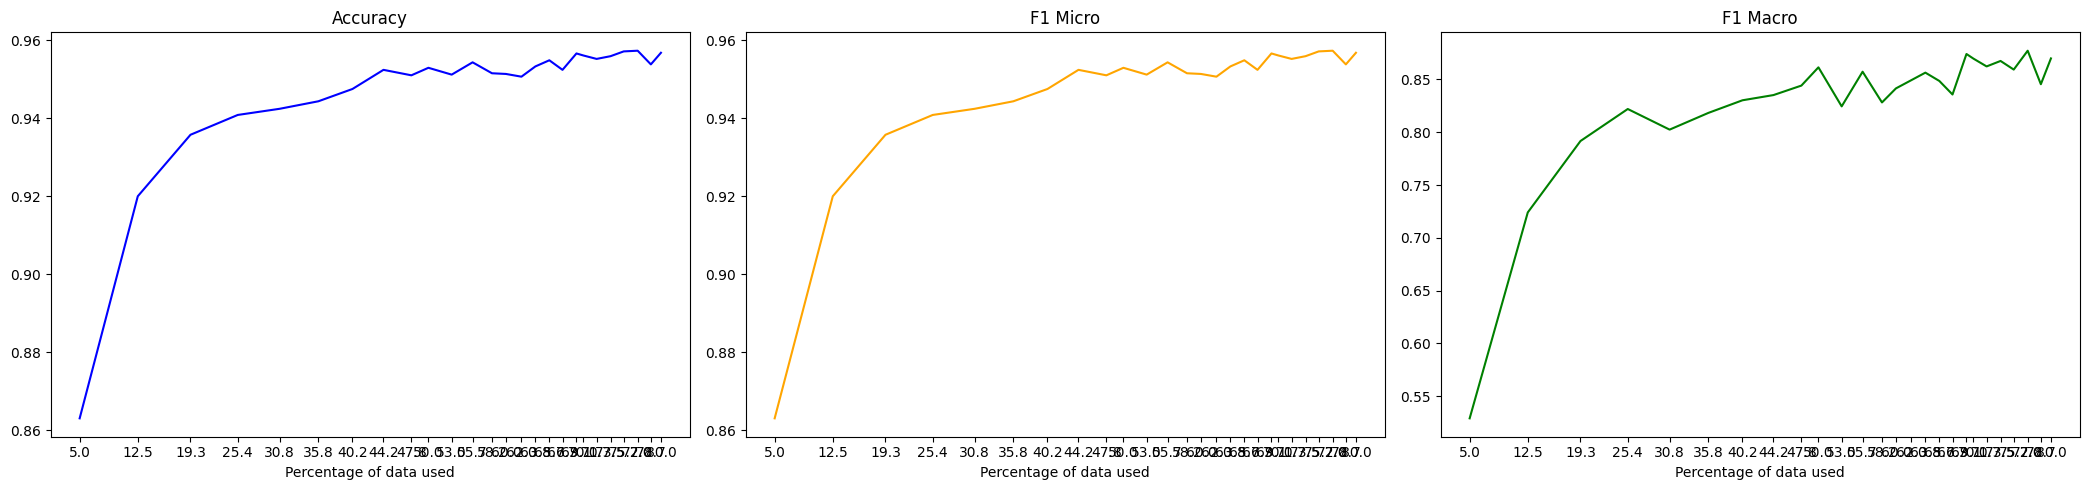

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.596952199935913 | ACCURACY: 0.8019 | F1 MACRO: 0.8841 | F1 MICRO: 0.8895
EPOCH 2 | LOSS: 2.363162040710449 | ACCURACY: 0.8059 | F1 MACRO: 0.8817 | F1 MICRO: 0.8903
EPOCH 3 | LOSS: 2.2543022632598877 | ACCURACY: 0.809 | F1 MACRO: 0.8821 | F1 MICRO: 0.8915
EPOCH 4 | LOSS: 2.1969058513641357 | ACCURACY: 0.8078 | F1 MACRO: 0.8855 | F1 MICRO: 0.8919
EPOCH 5 | LOSS: 2.18007230758667 | ACCURACY: 0.8132 | F1 MACRO: 0.8846 | F1 MICRO: 0.8935
EPOCH 6 | LOSS: 2.1536166667938232 | ACCURACY: 0.817 | F1 MACRO: 0.8869 | F1 MICRO: 0.8952
EPOCH 7 | LOSS: 2.128108263015747 | ACCURACY: 0.826 | F1 MACRO: 0.8929 | F1 MICRO: 0.9
EPOCH 8 | LOSS: 2.139995813369751 | ACCURACY: 0.834 | F1 MACRO: 0.8937 | F1 MICRO: 0.9032
EPOCH 9 | LOSS: 2.089966058731079 | ACCURACY: 0.8495 | F1 MACRO: 0.9054 | F1 MICRO: 0.912
EPOCH 10 | LOSS: 2.0640158653259277 | ACCURACY: 0.8604 | F1 MACRO: 0.9105 | F1 MICRO: 0.9176
aspect: ACCURACY 0.8604 | F1 MACRO 0.9105 | F1 MICRO 0.9176
              precision    recall 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 142: Accuracy: 0.8559, F1 Micro: 0.8559, F1 Macro: 0.5098
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.73      0.84        97
     neutral       0.94      0.92      0.93       459
    positive       0.19      0.67      0.30        15

    accuracy                           0.88       571
   macro avg       0.70      0.77      0.69       571
weighted avg       0.93      0.88      0.90       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       1.00      0.19      0.31        86
     neutral       0.85      0.99      0.92       475
    positive       0.00      0.00      0.00        10

    accuracy                           0.85       571
   macro avg       0.62      0.39      0.41       571
weighted avg       0.86      0.85      0.81       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.1478965282440186
Samples above threshold: 215
Acquired samples: 215
Sampling duration: 21.708915948867798 seconds
New train size: 357
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.305584192276001 | ACCURACY: 0.8082 | F1 MACRO: 0.8865 | F1 MICRO: 0.8924
EPOCH 2 | LOSS: 2.0496296882629395 | ACCURACY: 0.8144 | F1 MACRO: 0.8874 | F1 MICRO: 0.8948
EPOCH 3 | LOSS: 1.9574143886566162 | ACCURACY: 0.8396 | F1 MACRO: 0.9031 | F1 MICRO: 0.9082
EPOCH 4 | LOSS: 1.9806733131408691 | ACCURACY: 0.8766 | F1 MACRO: 0.9235 | F1 MICRO: 0.9278
EPOCH 5 | LOSS: 1.9420291185379028 | ACCURACY: 0.897 | F1 MACRO: 0.9325 | F1 MICRO: 0.9381
EPOCH 6 | LOSS: 1.905426025390625 | ACCURACY: 0.9087 | F1 MACRO: 0.9404 | F1 MICRO: 0.9449
EPOCH 7 | LOSS: 1.797741413116455 | ACCURACY: 0.9181 | F1 MACRO: 0.9448 | F1 MICRO: 0.9499
EPOCH 8 | LOSS: 1.7453666925430298 | ACCURACY: 0.9234 | F1 MACRO

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 20.702381134033203 | ACCURACY: 0.8533 | F1 MACRO: 0.8117 | F1 MICRO: 0.8533
EPOCH 2 | LOSS: 17.570520401000977 | ACCURACY: 0.8769 | F1 MACRO: 0.8411 | F1 MICRO: 0.8769
EPOCH 3 | LOSS: 16.77104949951172 | ACCURACY: 0.8876 | F1 MACRO: 0.8637 | F1 MICRO: 0.8876
EPOCH 4 | LOSS: 16.12554168701172 | ACCURACY: 0.8908 | F1 MACRO: 0.8647 | F1 MICRO: 0.8908
EPOCH 5 | LOSS: 15.642733573913574 | ACCURACY: 0.8961 | F1 MACRO: 0.8667 | F1 MICRO: 0.8961
EPOCH 6 | LOSS: 14.855356216430664 | ACCURACY: 0.8897 | F1 MACRO: 0.866 | F1 MICRO: 0.8897
EPOCH 7 | LOSS: 14.210644721984863 | ACCURACY: 0.8876 | F1 MACRO: 0.8662 | F1 MICRO: 0.8876
EPOCH 8 | LOSS: 13.663678169250488 | ACCURACY: 0.8758 | F1 MACRO: 0.8472 | F1 MICRO: 0.8758
EPOCH 9 | LOSS: 13.184290885925293 | ACCURACY: 0.8726 | F1 MACRO: 0.8493 | F1 MICRO: 0.8726
EPOCH 10 | LOSS: 13.332033157348633 | ACCURACY: 0.8844 | F1 MACRO: 0.8514 | F1 MICRO: 0.8844
sentiment: ACCURACY 0.8961 | F1 MACRO 0.8667 | F1 MICRO 0.8961
              preci

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.839933395385742
Samples above threshold: 193
Acquired samples: 193
Sampling duration: 31.88604998588562 seconds
New train size: 550
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.1640284061431885 | ACCURACY: 0.8062 | F1 MACRO: 0.8867 | F1 MICRO: 0.8918
EPOCH 2 | LOSS: 1.9316288232803345 | ACCURACY: 0.8403 | F1 MACRO: 0.9033 | F1 MICRO: 0.9085
EPOCH 3 | LOSS: 1.9125981330871582 | ACCURACY: 0.8917 | F1 MACRO: 0.9309 | F1 MICRO: 0.9356
EPOCH 4 | LOSS: 1.8701457977294922 | ACCURACY: 0.9144 | F1 MACRO: 0.9454 | F1 MICRO: 0.9484
EPOCH 5 | LOSS: 1.7798899412155151 | ACCURACY: 0.9269 | F1 MACRO: 0.9525 | F1 MICRO: 0.9555
EPOCH 6 | LOSS: 1.7224503755569458 | ACCURACY: 0.9332 | F1 MACRO: 0.9563 | F1 MICRO: 0.9591
EPOCH 7 | LOSS: 1.6476869583129883 | ACCURACY: 0.9312 | F1 MACRO: 0.955 | F1 MICRO: 0.958
EPOCH 8 | LOSS: 1.621634602546692 | ACCURACY: 0.9378 | F1 MACRO: 0.9593 | F1 MICRO: 0.9619
EPOCH 9 | LOSS: 1.578873872756958 | ACCURACY: 0.9378 | F1 MACRO: 0.9586 | F1 MICRO: 0.9619
EPOCH 10 | LOSS: 1.5491245985031128 | ACCURACY: 0.9408 | F1 MACRO: 0.9604 | F1 MICRO: 0.9636
aspect: ACCURACY 0.9408 | F1 MACRO 0.9604 | F1 MICRO 0.9636
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 550: Accuracy: 0.9399, F1 Micro: 0.9399, F1 Macro: 0.8019
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.87      0.90        15

    accuracy                           0.98       571
   macro avg       0.95      0.93      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.73      0.80        86
     neutral       0.95      0.99      0.97       475
    positive       0.44      0.40      0.42        10

    accuracy                           0.94       571
   macro avg       0.76      0.71      0.73       571
weighted avg       0.93      0.94      0.93       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.843820858001709
Samples above threshold: 174
Acquired samples: 174
Sampling duration: 38.23776364326477 seconds
New train size: 724
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.1223528385162354 | ACCURACY: 0.8141 | F1 MACRO: 0.89 | F1 MICRO: 0.8953
EPOCH 2 | LOSS: 1.877303957939148 | ACCURACY: 0.8689 | F1 MACRO: 0.9195 | F1 MICRO: 0.9236
EPOCH 3 | LOSS: 1.8710047006607056 | ACCURACY: 0.9101 | F1 MACRO: 0.942 | F1 MICRO: 0.9459
EPOCH 4 | LOSS: 1.7760670185089111 | ACCURACY: 0.9266 | F1 MACRO: 0.9519 | F1 MICRO: 0.9553
EPOCH 5 | LOSS: 1.6813374757766724 | ACCURACY: 0.9326 | F1 MACRO: 0.9557 | F1 MICRO: 0.9589
EPOCH 6 | LOSS: 1.6555655002593994 | ACCURACY: 0.9337 | F1 MACRO: 0.9568 | F1 MICRO: 0.9597
EPOCH 7 | LOSS: 1.5739868879318237 | ACCURACY: 0.9408 | F1 MACRO: 0.9612 | F1 MICRO: 0.9639
EPOCH 8 | LOSS: 1.5373297929763794 | ACCURACY: 0.9418 | F1 MACRO: 0.9612 | F1 MICRO: 0.9643
EPOCH 9 | LOSS: 1.5001139640808105 | ACCURACY: 0.9446 | F1 MACRO: 0.9634 | F1 MICRO: 0.9661
EPOCH 10 | LOSS: 1.4640886783599854 | ACCURACY: 0.9427 | F1 MACRO: 0.9616 | F1 MICRO: 0.9648
aspect: ACCURACY 0.9446 | F1 MACRO 0.9634 | F1 MICRO 0.9661
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 10.769157409667969 | ACCURACY: 0.8599 | F1 MACRO: 0.8126 | F1 MICRO: 0.8599
EPOCH 2 | LOSS: 8.854870796203613 | ACCURACY: 0.8873 | F1 MACRO: 0.8482 | F1 MICRO: 0.8873
EPOCH 3 | LOSS: 8.37964916229248 | ACCURACY: 0.8964 | F1 MACRO: 0.8633 | F1 MICRO: 0.8964
EPOCH 4 | LOSS: 8.010810852050781 | ACCURACY: 0.8975 | F1 MACRO: 0.8619 | F1 MICRO: 0.8975
EPOCH 5 | LOSS: 7.731402397155762 | ACCURACY: 0.8924 | F1 MACRO: 0.854 | F1 MICRO: 0.8924
EPOCH 6 | LOSS: 7.6971588134765625 | ACCURACY: 0.8802 | F1 MACRO: 0.8427 | F1 MICRO: 0.8802
EPOCH 7 | LOSS: 7.373902320861816 | ACCURACY: 0.9015 | F1 MACRO: 0.8712 | F1 MICRO: 0.9015
EPOCH 8 | LOSS: 7.248953819274902 | ACCURACY: 0.8964 | F1 MACRO: 0.864 | F1 MICRO: 0.8964
EPOCH 9 | LOSS: 6.7941975593566895 | ACCURACY: 0.8924 | F1 MACRO: 0.8579 | F1 MICRO: 0.8924
EPOCH 10 | LOSS: 6.7060370445251465 | ACCURACY: 0.8975 | F1 MACRO: 0.8662 | F1 MICRO: 0.8975
sentiment: ACCURACY 0.9015 | F1 MACRO 0.8712 | F1 MICRO 0.9015
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 724: Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.7846
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.89      0.92        97
     neutral       0.97      0.99      0.98       459
    positive       0.92      0.73      0.81        15

    accuracy                           0.97       571
   macro avg       0.95      0.87      0.91       571
weighted avg       0.97      0.97      0.97       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.96      0.74      0.84        86
     neutral       0.95      1.00      0.97       475
    positive       0.38      0.30      0.33        10

    accuracy                           0.95       571
   macro avg       0.76      0.68      0.71       571
weighted avg       0.94      0.95      0.94       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.848155879974365
Samples above threshold: 156
Acquired samples: 156
Sampling duration: 42.16323113441467 seconds
New train size: 880
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.062252998352051 | ACCURACY: 0.8135 | F1 MACRO: 0.8908 | F1 MICRO: 0.8956
EPOCH 2 | LOSS: 1.9090346097946167 | ACCURACY: 0.8964 | F1 MACRO: 0.9346 | F1 MICRO: 0.9385
EPOCH 3 | LOSS: 1.8307589292526245 | ACCURACY: 0.9285 | F1 MACRO: 0.9535 | F1 MICRO: 0.9565
EPOCH 4 | LOSS: 1.7358675003051758 | ACCURACY: 0.9354 | F1 MACRO: 0.9579 | F1 MICRO: 0.9607
EPOCH 5 | LOSS: 1.6359131336212158 | ACCURACY: 0.9411 | F1 MACRO: 0.9612 | F1 MICRO: 0.9639
EPOCH 6 | LOSS: 1.59481680393219 | ACCURACY: 0.9425 | F1 MACRO: 0.9619 | F1 MICRO: 0.9648
EPOCH 7 | LOSS: 1.565646767616272 | ACCURACY: 0.947 | F1 MACRO: 0.9648 | F1 MICRO: 0.9674
EPOCH 8 | LOSS: 1.5082803964614868 | ACCURACY: 0.945 | F1 MACRO: 0.

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 9.461331367492676 | ACCURACY: 0.8493 | F1 MACRO: 0.8009 | F1 MICRO: 0.8493
EPOCH 2 | LOSS: 7.933286666870117 | ACCURACY: 0.8738 | F1 MACRO: 0.8348 | F1 MICRO: 0.8738
EPOCH 3 | LOSS: 7.49733304977417 | ACCURACY: 0.8889 | F1 MACRO: 0.8615 | F1 MICRO: 0.8889
EPOCH 4 | LOSS: 7.230871677398682 | ACCURACY: 0.8879 | F1 MACRO: 0.8584 | F1 MICRO: 0.8879
EPOCH 5 | LOSS: 6.971343994140625 | ACCURACY: 0.8936 | F1 MACRO: 0.8678 | F1 MICRO: 0.8936
EPOCH 6 | LOSS: 6.699793338775635 | ACCURACY: 0.8823 | F1 MACRO: 0.8564 | F1 MICRO: 0.8823
EPOCH 7 | LOSS: 6.383797645568848 | ACCURACY: 0.8879 | F1 MACRO: 0.8575 | F1 MICRO: 0.8879
EPOCH 8 | LOSS: 6.086029052734375 | ACCURACY: 0.8757 | F1 MACRO: 0.8476 | F1 MICRO: 0.8757
EPOCH 9 | LOSS: 5.948652267456055 | ACCURACY: 0.8936 | F1 MACRO: 0.8692 | F1 MICRO: 0.8936
EPOCH 10 | LOSS: 5.836308002471924 | ACCURACY: 0.8964 | F1 MACRO: 0.8684 | F1 MICRO: 0.8964
sentiment: ACCURACY 0.8964 | F1 MACRO 0.8684 | F1 MICRO 0.8964
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 880: Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.8181
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.85      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.67      0.60      0.63        10

    accuracy                           0.96       571
   macro avg       0.86      0.81      0.84       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.207929611206055 | ACCURACY: 0.8525 | F1 MACRO: 0.8139 | F1 MICRO: 0.8525
EPOCH 2 | LOSS: 6.9941487312316895 | ACCURACY: 0.8757 | F1 MACRO: 0.8474 | F1 MICRO: 0.8757
EPOCH 3 | LOSS: 6.498001575469971 | ACCURACY: 0.884 | F1 MACRO: 0.8584 | F1 MICRO: 0.884
EPOCH 4 | LOSS: 6.181125640869141 | ACCURACY: 0.8794 | F1 MACRO: 0.8421 | F1 MICRO: 0.8794
EPOCH 5 | LOSS: 6.021495819091797 | ACCURACY: 0.8961 | F1 MACRO: 0.8707 | F1 MICRO: 0.8961
EPOCH 6 | LOSS: 5.85913610458374 | ACCURACY: 0.8831 | F1 MACRO: 0.8504 | F1 MICRO: 0.8831
EPOCH 7 | LOSS: 5.76870584487915 | ACCURACY: 0.8915 | F1 MACRO: 0.8642 | F1 MICRO: 0.8915
EPOCH 8 | LOSS: 5.421925067901611 | ACCURACY: 0.8859 | F1 MACRO: 0.8515 | F1 MICRO: 0.8859
EPOCH 9 | LOSS: 5.346933841705322 | ACCURACY: 0.8905 | F1 MACRO: 0.8635 | F1 MICRO: 0.8905
EPOCH 10 | LOSS: 5.17348575592041 | ACCURACY: 0.8868 | F1 MACRO: 0.8561 | F1 MICRO: 0.8868
sentiment: ACCURACY 0.8961 | F1 MACRO 0.8707 | F1 MICRO 0.8961
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1021: Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.8382
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94        97
     neutral       0.99      0.98      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.92      0.97      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.84      0.88        86
     neutral       0.97      0.99      0.98       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.78      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.8774203538894656
Samples above threshold: 127
Acquired samples: 127
Sampling duration: 50.71482586860657 seconds
New train size: 1148
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.0141308307647705 | ACCURACY: 0.8377 | F1 MACRO: 0.9014 | F1 MICRO: 0.9068
EPOCH 2 | LOSS: 1.8428341150283813 | ACCURACY: 0.9125 | F1 MACRO: 0.9437 | F1 MICRO: 0.9473
EPOCH 3 | LOSS: 1.7315902709960938 | ACCURACY: 0.9323 | F1 MACRO: 0.9564 | F1 MICRO: 0.9589
EPOCH 4 | LOSS: 1.644736886024475 | ACCURACY: 0.9431 | F1 MACRO: 0.9618 | F1 MICRO: 0.9649
EPOCH 5 | LOSS: 1.5770548582077026 | ACCURACY: 0.9436 | F1 MACRO: 0.962 | F1 MICRO: 0.9653
EPOCH 6 | LOSS: 1.5423012971878052 | ACCURACY: 0.9476 | F1 MACRO: 0.965 | F1 MICRO: 0.9676
EPOCH 7 | LOSS: 1.4831793308258057 | ACCURACY: 0.9479 | F1 MACRO: 0.9646 | F1 MICRO: 0.9678
EPOCH 8 | LOSS: 1.4444825649261475 | ACCURACY: 0.9526 | F1 MACR

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 7.183681011199951 | ACCURACY: 0.8574 | F1 MACRO: 0.8273 | F1 MICRO: 0.8574
EPOCH 2 | LOSS: 6.001057147979736 | ACCURACY: 0.8725 | F1 MACRO: 0.8474 | F1 MICRO: 0.8725
EPOCH 3 | LOSS: 5.700220584869385 | ACCURACY: 0.8791 | F1 MACRO: 0.8436 | F1 MICRO: 0.8791
EPOCH 4 | LOSS: 5.485783100128174 | ACCURACY: 0.8924 | F1 MACRO: 0.8682 | F1 MICRO: 0.8924
EPOCH 5 | LOSS: 5.265107154846191 | ACCURACY: 0.8999 | F1 MACRO: 0.8765 | F1 MICRO: 0.8999
EPOCH 6 | LOSS: 5.168152809143066 | ACCURACY: 0.8952 | F1 MACRO: 0.8689 | F1 MICRO: 0.8952
EPOCH 7 | LOSS: 4.937956809997559 | ACCURACY: 0.8952 | F1 MACRO: 0.8697 | F1 MICRO: 0.8952
EPOCH 8 | LOSS: 4.757309913635254 | ACCURACY: 0.9027 | F1 MACRO: 0.8804 | F1 MICRO: 0.9027
EPOCH 9 | LOSS: 4.641403675079346 | ACCURACY: 0.9027 | F1 MACRO: 0.8784 | F1 MICRO: 0.9027
EPOCH 10 | LOSS: 4.536088943481445 | ACCURACY: 0.9018 | F1 MACRO: 0.8776 | F1 MICRO: 0.9018
sentiment: ACCURACY 0.9027 | F1 MACRO 0.8784 | F1 MICRO 0.9027
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1148: Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.8385
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.95      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.88      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.86      0.79      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.8831226348876955
Samples above threshold: 114
Acquired samples: 114
Sampling duration: 53.56419491767883 seconds
New train size: 1262
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.027946710586548 | ACCURACY: 0.845 | F1 MACRO: 0.9059 | F1 MICRO: 0.9108
EPOCH 2 | LOSS: 1.858194351196289 | ACCURACY: 0.9252 | F1 MACRO: 0.9514 | F1 MICRO: 0.9545
EPOCH 3 | LOSS: 1.727559208869934 | ACCURACY: 0.9356 | F1 MACRO: 0.9583 | F1 MICRO: 0.9607
EPOCH 4 | LOSS: 1.6440852880477905 | ACCURACY: 0.9387 | F1 MACRO: 0.9597 | F1 MICRO: 0.9625
EPOCH 5 | LOSS: 1.5859688520431519 | ACCURACY: 0.946 | F1 MACRO: 0.9638 | F1 MICRO: 0.9667
EPOCH 6 | LOSS: 1.5380332469940186 | ACCURACY: 0.9505 | F1 MACRO: 0.9664 | F1 MICRO: 0.9694
EPOCH 7 | LOSS: 1.4823013544082642 | ACCURACY: 0.9488 | F1 MACRO: 0.9652 | F1 MICRO: 0.9684
EPOCH 8 | LOSS: 1.4367870092391968 | ACCURACY: 0.9523 | F1 MACRO: 0.967 | F1 MICRO: 0.9704
EPOCH 9 | LOSS: 1.4023691415786743 | ACCURACY: 0.9526 | F1 MACRO: 0.9681 | F1 MICRO: 0.9708
EPOCH 10 | LOSS: 1.371193289756775 | ACCURACY: 0.9542 | F1 MACRO: 0.9685 | F1 MICRO: 0.9716
aspect: ACCURACY 0.9542 | F1 MACRO 0.9685 | F1 MICRO 0.9716
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.856287002563477 | ACCURACY: 0.8463 | F1 MACRO: 0.8054 | F1 MICRO: 0.8463
EPOCH 2 | LOSS: 5.6145405769348145 | ACCURACY: 0.8838 | F1 MACRO: 0.8491 | F1 MICRO: 0.8838
EPOCH 3 | LOSS: 5.3798747062683105 | ACCURACY: 0.8957 | F1 MACRO: 0.865 | F1 MICRO: 0.8957
EPOCH 4 | LOSS: 5.146346569061279 | ACCURACY: 0.8939 | F1 MACRO: 0.863 | F1 MICRO: 0.8939
EPOCH 5 | LOSS: 4.932158946990967 | ACCURACY: 0.8866 | F1 MACRO: 0.8497 | F1 MICRO: 0.8866
EPOCH 6 | LOSS: 4.711199760437012 | ACCURACY: 0.8975 | F1 MACRO: 0.8662 | F1 MICRO: 0.8975
EPOCH 7 | LOSS: 4.511650085449219 | ACCURACY: 0.8866 | F1 MACRO: 0.8505 | F1 MICRO: 0.8866
EPOCH 8 | LOSS: 4.3377366065979 | ACCURACY: 0.8966 | F1 MACRO: 0.8681 | F1 MICRO: 0.8966
EPOCH 9 | LOSS: 4.304147720336914 | ACCURACY: 0.8893 | F1 MACRO: 0.8569 | F1 MICRO: 0.8893
EPOCH 10 | LOSS: 4.244021415710449 | ACCURACY: 0.8948 | F1 MACRO: 0.8646 | F1 MICRO: 0.8948
sentiment: ACCURACY 0.8975 | F1 MACRO 0.8662 | F1 MICRO 0.8975
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1262: Accuracy: 0.9527, F1 Micro: 0.9527, F1 Macro: 0.8268
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94        97
     neutral       0.99      0.98      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.94      0.97      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.83      0.87        86
     neutral       0.97      0.99      0.98       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.87      0.77      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.8369479179382324
Samples above threshold: 103
Acquired samples: 103
Sampling duration: 57.016234159469604 seconds
New train size: 1365
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9942783117294312 | ACCURACY: 0.8444 | F1 MACRO: 0.9055 | F1 MICRO: 0.9101
EPOCH 2 | LOSS: 1.8358063697814941 | ACCURACY: 0.9278 | F1 MACRO: 0.9523 | F1 MICRO: 0.9558
EPOCH 3 | LOSS: 1.696009635925293 | ACCURACY: 0.937 | F1 MACRO: 0.9586 | F1 MICRO: 0.9615
EPOCH 4 | LOSS: 1.604758620262146 | ACCURACY: 0.946 | F1 MACRO: 0.9638 | F1 MICRO: 0.9668
EPOCH 5 | LOSS: 1.5490145683288574 | ACCURACY: 0.9523 | F1 MACRO: 0.9678 | F1 MICRO: 0.9705
EPOCH 6 | LOSS: 1.4883941411972046 | ACCURACY: 0.9521 | F1 MACRO: 0.9673 | F1 MICRO: 0.9705
EPOCH 7 | LOSS: 1.456838607788086 | ACCURACY: 0.9521 | F1 MACRO: 0.9678 | F1 MICRO: 0.9705
EPOCH 8 | LOSS: 1.409638524055481 | ACCURACY: 0.951 | F1 MACRO: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.991580009460449 | ACCURACY: 0.8649 | F1 MACRO: 0.8285 | F1 MICRO: 0.8649
EPOCH 2 | LOSS: 4.954255104064941 | ACCURACY: 0.887 | F1 MACRO: 0.8523 | F1 MICRO: 0.887
EPOCH 3 | LOSS: 4.585775852203369 | ACCURACY: 0.9042 | F1 MACRO: 0.8777 | F1 MICRO: 0.9042
EPOCH 4 | LOSS: 4.433159351348877 | ACCURACY: 0.9061 | F1 MACRO: 0.8793 | F1 MICRO: 0.9061
EPOCH 5 | LOSS: 4.3160810470581055 | ACCURACY: 0.9023 | F1 MACRO: 0.8741 | F1 MICRO: 0.9023
EPOCH 6 | LOSS: 4.0688700675964355 | ACCURACY: 0.9109 | F1 MACRO: 0.8856 | F1 MICRO: 0.9109
EPOCH 7 | LOSS: 4.0578508377075195 | ACCURACY: 0.9071 | F1 MACRO: 0.8818 | F1 MICRO: 0.9071
EPOCH 8 | LOSS: 3.9070820808410645 | ACCURACY: 0.9109 | F1 MACRO: 0.8851 | F1 MICRO: 0.9109
EPOCH 9 | LOSS: 3.8852672576904297 | ACCURACY: 0.9157 | F1 MACRO: 0.8936 | F1 MICRO: 0.9157
EPOCH 10 | LOSS: 3.7231452465057373 | ACCURACY: 0.9109 | F1 MACRO: 0.8854 | F1 MICRO: 0.9109
sentiment: ACCURACY 0.9157 | F1 MACRO 0.8936 | F1 MICRO 0.9157
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1365: Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.8393
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      0.93      0.90        15

    accuracy                           0.98       571
   macro avg       0.94      0.95      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.95      0.83      0.88        86
     neutral       0.97      1.00      0.98       475
    positive       0.78      0.70      0.74        10

    accuracy                           0.96       571
   macro avg       0.90      0.84      0.87       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9894145727157593 | ACCURACY: 0.8564 | F1 MACRO: 0.9124 | F1 MICRO: 0.9168
EPOCH 2 | LOSS: 1.8059743642807007 | ACCURACY: 0.9253 | F1 MACRO: 0.9511 | F1 MICRO: 0.9545
EPOCH 3 | LOSS: 1.6766588687896729 | ACCURACY: 0.9366 | F1 MACRO: 0.9581 | F1 MICRO: 0.9613
EPOCH 4 | LOSS: 1.5860308408737183 | ACCURACY: 0.9417 | F1 MACRO: 0.9619 | F1 MICRO: 0.9644
EPOCH 5 | LOSS: 1.5402281284332275 | ACCURACY: 0.9502 | F1 MACRO: 0.9664 | F1 MICRO: 0.9693
EPOCH 6 | LOSS: 1.476157307624817 | ACCURACY: 0.9507 | F1 MACRO: 0.967 | F1 MICRO: 0.9696
EPOCH 7 | LOSS: 1.4451769590377808 | ACCURACY: 0.954 | F1 MACRO: 0.9689 | F1 MICRO: 0.9716
EPOCH 8 | LOSS: 1.4001537561416626 | ACCURACY: 0.9566 | F1 MACRO: 0.9702 | F1 MICRO: 0.9731
EPOCH 9 | LOSS: 1.3693464994430542 | ACCURACY: 0.9543 | F1 MACRO: 0.9692 | F1 MICRO: 0.9718
EPOCH 10 | LOSS: 1.34379243850708 | ACCURACY: 0.9564 | F1 MACRO: 0.9707 | F1 MICRO: 0.973
aspect: ACCURACY 0.9566 | F1 MACRO 0.9702 | F1 MICRO 0.9731
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.892287254333496 | ACCURACY: 0.8621 | F1 MACRO: 0.8237 | F1 MICRO: 0.8621
EPOCH 2 | LOSS: 4.847372055053711 | ACCURACY: 0.8557 | F1 MACRO: 0.8285 | F1 MICRO: 0.8557
EPOCH 3 | LOSS: 4.541100978851318 | ACCURACY: 0.8824 | F1 MACRO: 0.8502 | F1 MICRO: 0.8824
EPOCH 4 | LOSS: 4.415591716766357 | ACCURACY: 0.875 | F1 MACRO: 0.8341 | F1 MICRO: 0.875
EPOCH 5 | LOSS: nan | ACCURACY: 0.6967 | F1 MACRO: 0.4106 | F1 MICRO: 0.6967
EPOCH 6 | LOSS: nan | ACCURACY: 0.6967 | F1 MACRO: 0.4106 | F1 MICRO: 0.6967
EPOCH 7 | LOSS: nan | ACCURACY: 0.6967 | F1 MACRO: 0.4106 | F1 MICRO: 0.6967
EPOCH 8 | LOSS: nan | ACCURACY: 0.6967 | F1 MACRO: 0.4106 | F1 MICRO: 0.6967
EPOCH 9 | LOSS: nan | ACCURACY: 0.6967 | F1 MACRO: 0.4106 | F1 MICRO: 0.6967
EPOCH 10 | LOSS: nan | ACCURACY: 0.6967 | F1 MACRO: 0.4106 | F1 MICRO: 0.6967
sentiment: ACCURACY 0.8824 | F1 MACRO 0.8502 | F1 MICRO 0.8824
              precision    recall  f1-score   support

    negative       0.88      0.97      0.92       758
   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.8402152061462402
Samples above threshold: 86
Acquired samples: 86
Sampling duration: 61.17576003074646 seconds
New train size: 1513
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.98883855342865 | ACCURACY: 0.8707 | F1 MACRO: 0.9209 | F1 MICRO: 0.9247
EPOCH 2 | LOSS: 1.8056138753890991 | ACCURACY: 0.9262 | F1 MACRO: 0.9513 | F1 MICRO: 0.9548
EPOCH 3 | LOSS: 1.6806422472000122 | ACCURACY: 0.9394 | F1 MACRO: 0.9601 | F1 MICRO: 0.9629
EPOCH 4 | LOSS: 1.6167106628417969 | ACCURACY: 0.9472 | F1 MACRO: 0.964 | F1 MICRO: 0.9675
EPOCH 5 | LOSS: 1.5420225858688354 | ACCURACY: 0.951 | F1 MACRO: 0.9673 | F1 MICRO: 0.9698
EPOCH 6 | LOSS: 1.4948374032974243 | ACCURACY: 0.9498 | F1 MACRO: 0.9665 | F1 MICRO: 0.9691
EPOCH 7 | LOSS: 1.4471529722213745 | ACCURACY: 0.953 | F1 MACRO: 0.9678 | F1 MICRO: 0.9708
EPOCH 8 | LOSS: 1.4054909944534302 | ACCURACY: 0.955 | F1 MACRO: 0.9694 | F1 MICRO: 0.9721
EPOCH 9 | LOSS: 1.370059847831726 | ACCURACY: 0.9517 | F1 MACRO: 0.9676 | F1 MICRO: 0.9701
EPOCH 10 | LOSS: 1.3430588245391846 | ACCURACY: 0.9552 | F1 MACRO: 0.9698 | F1 MICRO: 0.9723
aspect: ACCURACY 0.9552 | F1 MACRO 0.9698 | F1 MICRO 0.9723
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1513: Accuracy: 0.9539, F1 Micro: 0.9539, F1 Macro: 0.8522
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.81      0.87        86
     neutral       0.97      1.00      0.98       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.77      0.80       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.8825132846832275
Samples above threshold: 77
Acquired samples: 77
Sampling duration: 63.159597635269165 seconds
New train size: 1590
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.974369764328003 | ACCURACY: 0.8832 | F1 MACRO: 0.9266 | F1 MICRO: 0.9308
EPOCH 2 | LOSS: 1.7858649492263794 | ACCURACY: 0.9309 | F1 MACRO: 0.9551 | F1 MICRO: 0.958
EPOCH 3 | LOSS: 1.6554737091064453 | ACCURACY: 0.9427 | F1 MACRO: 0.9623 | F1 MICRO: 0.9649
EPOCH 4 | LOSS: 1.5813952684402466 | ACCURACY: 0.9493 | F1 MACRO: 0.9659 | F1 MICRO: 0.9688
EPOCH 5 | LOSS: 1.5216429233551025 | ACCURACY: 0.9547 | F1 MACRO: 0.969 | F1 MICRO: 0.9719
EPOCH 6 | LOSS: 1.4634028673171997 | ACCURACY: 0.9502 | F1 MACRO: 0.966 | F1 MICRO: 0.9691
EPOCH 7 | LOSS: 1.421238660812378 | ACCURACY: 0.9531 | F1 MACRO: 0.9679 | F1 MICRO: 0.9709
EPOCH 8 | LOSS: 1.3829504251480103 | ACCURACY: 0.954 | F1 MACRO: 0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.311922073364258 | ACCURACY: 0.869 | F1 MACRO: 0.8254 | F1 MICRO: 0.869
EPOCH 2 | LOSS: 4.3857526779174805 | ACCURACY: 0.8977 | F1 MACRO: 0.8679 | F1 MICRO: 0.8977
EPOCH 3 | LOSS: 4.0205607414245605 | ACCURACY: 0.9044 | F1 MACRO: 0.8761 | F1 MICRO: 0.9044
EPOCH 4 | LOSS: 3.779008150100708 | ACCURACY: 0.9034 | F1 MACRO: 0.8781 | F1 MICRO: 0.9034
EPOCH 5 | LOSS: 3.711107015609741 | ACCURACY: 0.9073 | F1 MACRO: 0.8808 | F1 MICRO: 0.9073
EPOCH 6 | LOSS: 3.61561918258667 | ACCURACY: 0.9082 | F1 MACRO: 0.8805 | F1 MICRO: 0.9082
EPOCH 7 | LOSS: 3.453333616256714 | ACCURACY: 0.912 | F1 MACRO: 0.8881 | F1 MICRO: 0.912
EPOCH 8 | LOSS: 3.4321749210357666 | ACCURACY: 0.9168 | F1 MACRO: 0.8945 | F1 MICRO: 0.9168
EPOCH 9 | LOSS: 3.3504958152770996 | ACCURACY: 0.912 | F1 MACRO: 0.8891 | F1 MICRO: 0.912
EPOCH 10 | LOSS: 3.3028197288513184 | ACCURACY: 0.9054 | F1 MACRO: 0.8815 | F1 MICRO: 0.9054
sentiment: ACCURACY 0.9168 | F1 MACRO 0.8945 | F1 MICRO 0.9168
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1590: Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.8545
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.95      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.94      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.86      0.88        86
     neutral       0.98      0.99      0.98       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.86      0.78      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.883734130859375
Samples above threshold: 70
Acquired samples: 70
Sampling duration: 64.88218832015991 seconds
New train size: 1660
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9715250730514526 | ACCURACY: 0.8859 | F1 MACRO: 0.926 | F1 MICRO: 0.9319
EPOCH 2 | LOSS: 1.7787662744522095 | ACCURACY: 0.933 | F1 MACRO: 0.9558 | F1 MICRO: 0.9591
EPOCH 3 | LOSS: 1.645661473274231 | ACCURACY: 0.942 | F1 MACRO: 0.9612 | F1 MICRO: 0.9644
EPOCH 4 | LOSS: 1.5728212594985962 | ACCURACY: 0.9464 | F1 MACRO: 0.9644 | F1 MICRO: 0.9669
EPOCH 5 | LOSS: 1.5017706155776978 | ACCURACY: 0.9516 | F1 MACRO: 0.9676 | F1 MICRO: 0.9702
EPOCH 6 | LOSS: 1.4775725603103638 | ACCURACY: 0.955 | F1 MACRO: 0.9693 | F1 MICRO: 0.9722
EPOCH 7 | LOSS: 1.4121696949005127 | ACCURACY: 0.954 | F1 MACRO: 0.9689 | F1 MICRO: 0.9715
EPOCH 8 | LOSS: 1.382944941520691 | ACCURACY: 0.9561 | F1 MACRO: 0.97

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.133571624755859 | ACCURACY: 0.8562 | F1 MACRO: 0.8216 | F1 MICRO: 0.8562
EPOCH 2 | LOSS: 4.276312828063965 | ACCURACY: 0.8736 | F1 MACRO: 0.8335 | F1 MICRO: 0.8736
EPOCH 3 | LOSS: 4.01023006439209 | ACCURACY: 0.8919 | F1 MACRO: 0.8586 | F1 MICRO: 0.8919
EPOCH 4 | LOSS: 3.7979538440704346 | ACCURACY: 0.8965 | F1 MACRO: 0.866 | F1 MICRO: 0.8965
EPOCH 5 | LOSS: 3.669558048248291 | ACCURACY: 0.902 | F1 MACRO: 0.8764 | F1 MICRO: 0.902
EPOCH 6 | LOSS: 3.5617258548736572 | ACCURACY: 0.902 | F1 MACRO: 0.8743 | F1 MICRO: 0.902
EPOCH 7 | LOSS: 3.439371347427368 | ACCURACY: 0.8929 | F1 MACRO: 0.8686 | F1 MICRO: 0.8929
EPOCH 8 | LOSS: 3.353856086730957 | ACCURACY: 0.9029 | F1 MACRO: 0.8799 | F1 MICRO: 0.9029
EPOCH 9 | LOSS: 3.2475247383117676 | ACCURACY: 0.8984 | F1 MACRO: 0.8746 | F1 MICRO: 0.8984
EPOCH 10 | LOSS: 3.1860997676849365 | ACCURACY: 0.9029 | F1 MACRO: 0.8753 | F1 MICRO: 0.9029
sentiment: ACCURACY 0.9029 | F1 MACRO 0.8753 | F1 MICRO 0.9029
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.9018617153167727
Samples above threshold: 63
Acquired samples: 52
Sampling duration: 66.9362404346466 seconds
New train size: 1712
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.973913550376892 | ACCURACY: 0.8991 | F1 MACRO: 0.9354 | F1 MICRO: 0.9396
EPOCH 2 | LOSS: 1.78824782371521 | ACCURACY: 0.937 | F1 MACRO: 0.9587 | F1 MICRO: 0.9614
EPOCH 3 | LOSS: 1.655812382698059 | ACCURACY: 0.9439 | F1 MACRO: 0.9621 | F1 MICRO: 0.9654
EPOCH 4 | LOSS: 1.5764341354370117 | ACCURACY: 0.9503 | F1 MACRO: 0.9666 | F1 MICRO: 0.9694
EPOCH 5 | LOSS: 1.5235095024108887 | ACCURACY: 0.9528 | F1 MACRO: 0.9673 | F1 MICRO: 0.9707
EPOCH 6 | LOSS: 1.4725096225738525 | ACCURACY: 0.955 | F1 MACRO: 0.9695 | F1 MICRO: 0.9721
EPOCH 7 | LOSS: 1.4334979057312012 | ACCURACY: 0.9507 | F1 MACRO: 0.9669 | F1 MICRO: 0.9697
EPOCH 8 | LOSS: 1.3869394063949585 | ACCURACY: 0.9547 | F1 MACRO: 0.9692 | F1 MICRO: 0.9719
EPOCH 9 | LOSS: 1.3562273979187012 | ACCURACY: 0.9559 | F1 MACRO: 0.9699 | F1 MICRO: 0.9726
EPOCH 10 | LOSS: 1.3331971168518066 | ACCURACY: 0.9571 | F1 MACRO: 0.9705 | F1 MICRO: 0.9733
aspect: ACCURACY 0.9571 | F1 MACRO 0.9705 | F1 MICRO 0.9733
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.9098920822143555 | ACCURACY: 0.829 | F1 MACRO: 0.7576 | F1 MICRO: 0.829
EPOCH 2 | LOSS: 4.107077121734619 | ACCURACY: 0.8632 | F1 MACRO: 0.8173 | F1 MICRO: 0.8632
EPOCH 3 | LOSS: 3.8798468112945557 | ACCURACY: 0.8785 | F1 MACRO: 0.8497 | F1 MICRO: 0.8785
EPOCH 4 | LOSS: 3.7384085655212402 | ACCURACY: 0.8839 | F1 MACRO: 0.8513 | F1 MICRO: 0.8839
EPOCH 5 | LOSS: 3.5393362045288086 | ACCURACY: 0.8776 | F1 MACRO: 0.851 | F1 MICRO: 0.8776
EPOCH 6 | LOSS: 3.4976346492767334 | ACCURACY: 0.892 | F1 MACRO: 0.8624 | F1 MICRO: 0.892
EPOCH 7 | LOSS: 3.342498779296875 | ACCURACY: 0.8965 | F1 MACRO: 0.8694 | F1 MICRO: 0.8965
EPOCH 8 | LOSS: 3.243361234664917 | ACCURACY: 0.8857 | F1 MACRO: 0.8564 | F1 MICRO: 0.8857
EPOCH 9 | LOSS: 3.2300496101379395 | ACCURACY: 0.8902 | F1 MACRO: 0.8589 | F1 MICRO: 0.8902
EPOCH 10 | LOSS: 3.1681768894195557 | ACCURACY: 0.8974 | F1 MACRO: 0.8682 | F1 MICRO: 0.8974
sentiment: ACCURACY 0.8974 | F1 MACRO 0.8682 | F1 MICRO 0.8974
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1712: Accuracy: 0.9532, F1 Micro: 0.9532, F1 Macro: 0.8546
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.88      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.70      0.70      0.70        10

    accuracy                           0.97       571
   macro avg       0.87      0.86      0.86       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.8811445236206055
Samples above threshold: 58
Acquired samples: 58
Sampling duration: 68.45355343818665 seconds
New train size: 1770
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9913755655288696 | ACCURACY: 0.8922 | F1 MACRO: 0.931 | F1 MICRO: 0.9357
EPOCH 2 | LOSS: 1.7978960275650024 | ACCURACY: 0.9359 | F1 MACRO: 0.9582 | F1 MICRO: 0.9609
EPOCH 3 | LOSS: 1.6545124053955078 | ACCURACY: 0.9405 | F1 MACRO: 0.9598 | F1 MICRO: 0.9632
EPOCH 4 | LOSS: 1.5973703861236572 | ACCURACY: 0.953 | F1 MACRO: 0.9678 | F1 MICRO: 0.9709
EPOCH 5 | LOSS: 1.51337468624115 | ACCURACY: 0.9542 | F1 MACRO: 0.9683 | F1 MICRO: 0.9716
EPOCH 6 | LOSS: 1.46985924243927 | ACCURACY: 0.9563 | F1 MACRO: 0.9698 | F1 MICRO: 0.9729
EPOCH 7 | LOSS: 1.4208904504776 | ACCURACY: 0.9523 | F1 MACRO: 0.968 | F1 MICRO: 0.9706
EPOCH 8 | LOSS: 1.3831380605697632 | ACCURACY: 0.9538 | F1 MACRO: 0.9683 | F1 MICRO: 0.9714
EPOCH 9 | LOSS: 1.3518154621124268 | ACCURACY: 0.9564 | F1 MACRO: 0.9699 | F1 MICRO: 0.9729
EPOCH 10 | LOSS: 1.3270622491836548 | ACCURACY: 0.9568 | F1 MACRO: 0.9703 | F1 MICRO: 0.9732
aspect: ACCURACY 0.9568 | F1 MACRO 0.9703 | F1 MICRO 0.9732
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.797662734985352 | ACCURACY: 0.8226 | F1 MACRO: 0.745 | F1 MICRO: 0.8226
EPOCH 2 | LOSS: 3.9814693927764893 | ACCURACY: 0.8644 | F1 MACRO: 0.8187 | F1 MICRO: 0.8644
EPOCH 3 | LOSS: 3.6972553730010986 | ACCURACY: 0.8899 | F1 MACRO: 0.8603 | F1 MICRO: 0.8899
EPOCH 4 | LOSS: 3.541444778442383 | ACCURACY: 0.8935 | F1 MACRO: 0.8646 | F1 MICRO: 0.8935
EPOCH 5 | LOSS: 3.457479476928711 | ACCURACY: 0.8872 | F1 MACRO: 0.8607 | F1 MICRO: 0.8872
EPOCH 6 | LOSS: 3.342385768890381 | ACCURACY: 0.8908 | F1 MACRO: 0.8613 | F1 MICRO: 0.8908
EPOCH 7 | LOSS: 3.2031455039978027 | ACCURACY: 0.8972 | F1 MACRO: 0.8692 | F1 MICRO: 0.8972
EPOCH 8 | LOSS: 3.167950391769409 | ACCURACY: 0.8926 | F1 MACRO: 0.8633 | F1 MICRO: 0.8926
EPOCH 9 | LOSS: 3.098017692565918 | ACCURACY: 0.8944 | F1 MACRO: 0.8642 | F1 MICRO: 0.8944
EPOCH 10 | LOSS: 3.050022840499878 | ACCURACY: 0.8954 | F1 MACRO: 0.8678 | F1 MICRO: 0.8954
sentiment: ACCURACY 0.8972 | F1 MACRO 0.8692 | F1 MICRO 0.8972
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.8429049015045167
Samples above threshold: 52
Acquired samples: 52
Sampling duration: 69.96737790107727 seconds
New train size: 1822
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9652138948440552 | ACCURACY: 0.8852 | F1 MACRO: 0.9283 | F1 MICRO: 0.9324
EPOCH 2 | LOSS: 1.7679531574249268 | ACCURACY: 0.9335 | F1 MACRO: 0.9562 | F1 MICRO: 0.9593
EPOCH 3 | LOSS: 1.6301689147949219 | ACCURACY: 0.9439 | F1 MACRO: 0.9625 | F1 MICRO: 0.9656
EPOCH 4 | LOSS: 1.5662779808044434 | ACCURACY: 0.9509 | F1 MACRO: 0.9655 | F1 MICRO: 0.9695
EPOCH 5 | LOSS: 1.5041437149047852 | ACCURACY: 0.9509 | F1 MACRO: 0.9665 | F1 MICRO: 0.9696
EPOCH 6 | LOSS: 1.4342900514602661 | ACCURACY: 0.9554 | F1 MACRO: 0.9694 | F1 MICRO: 0.9724
EPOCH 7 | LOSS: 1.4050034284591675 | ACCURACY: 0.9552 | F1 MACRO: 0.969 | F1 MICRO: 0.9722
EPOCH 8 | LOSS: 1.3699406385421753 | ACCURACY: 0.9564 | F1 MACRO: 0.9702 | F1 MICRO: 0.973
EPOCH 9 | LOSS: 1.3433055877685547 | ACCURACY: 0.9549 | F1 MACRO: 0.9696 | F1 MICRO: 0.972
EPOCH 10 | LOSS: 1.3155537843704224 | ACCURACY: 0.958 | F1 MACRO: 0.9712 | F1 MICRO: 0.9739
aspect: ACCURACY 0.958 | F1 MACRO 0.9712 | F1 MICRO 0.9739
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.679427146911621 | ACCURACY: 0.8514 | F1 MACRO: 0.7985 | F1 MICRO: 0.8514
EPOCH 2 | LOSS: 3.8690638542175293 | ACCURACY: 0.8641 | F1 MACRO: 0.8138 | F1 MICRO: 0.8641
EPOCH 3 | LOSS: 3.6458520889282227 | ACCURACY: 0.894 | F1 MACRO: 0.8687 | F1 MICRO: 0.894
EPOCH 4 | LOSS: 3.5294106006622314 | ACCURACY: 0.8976 | F1 MACRO: 0.87 | F1 MICRO: 0.8976
EPOCH 5 | LOSS: 3.299281120300293 | ACCURACY: 0.8986 | F1 MACRO: 0.8705 | F1 MICRO: 0.8986
EPOCH 6 | LOSS: 3.267826557159424 | ACCURACY: 0.8995 | F1 MACRO: 0.8712 | F1 MICRO: 0.8995
EPOCH 7 | LOSS: 3.170522928237915 | ACCURACY: 0.904 | F1 MACRO: 0.879 | F1 MICRO: 0.904
EPOCH 8 | LOSS: 3.1298131942749023 | ACCURACY: 0.894 | F1 MACRO: 0.864 | F1 MICRO: 0.894
EPOCH 9 | LOSS: 2.978116035461426 | ACCURACY: 0.8958 | F1 MACRO: 0.8657 | F1 MICRO: 0.8958
EPOCH 10 | LOSS: 2.9420032501220703 | ACCURACY: 0.8995 | F1 MACRO: 0.8706 | F1 MICRO: 0.8995
sentiment: ACCURACY 0.904 | F1 MACRO 0.879 | F1 MICRO 0.904
              precision    recall 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1822: Accuracy: 0.9562, F1 Micro: 0.9562, F1 Macro: 0.8556
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.88      0.90        86
     neutral       0.98      1.00      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.79      0.83       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.8366637229919434
Samples above threshold: 47
Acquired samples: 50
Sampling duration: 70.97070169448853 seconds
New train size: 1872
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9732792377471924 | ACCURACY: 0.8981 | F1 MACRO: 0.9354 | F1 MICRO: 0.9391
EPOCH 2 | LOSS: 1.77445650100708 | ACCURACY: 0.9375 | F1 MACRO: 0.9591 | F1 MICRO: 0.9617
EPOCH 3 | LOSS: 1.6550703048706055 | ACCURACY: 0.9481 | F1 MACRO: 0.9653 | F1 MICRO: 0.9681
EPOCH 4 | LOSS: 1.5652151107788086 | ACCURACY: 0.9505 | F1 MACRO: 0.9661 | F1 MICRO: 0.9694
EPOCH 5 | LOSS: 1.508058786392212 | ACCURACY: 0.9517 | F1 MACRO: 0.9669 | F1 MICRO: 0.9701
EPOCH 6 | LOSS: 1.4534574747085571 | ACCURACY: 0.9568 | F1 MACRO: 0.97 | F1 MICRO: 0.9731
EPOCH 7 | LOSS: 1.4057801961898804 | ACCURACY: 0.9512 | F1 MACRO: 0.9671 | F1 MICRO: 0.9699
EPOCH 8 | LOSS: 1.3795547485351562 | ACCURACY: 0.9573 | F1 MACRO: 0.9705 | F1 MICRO: 0.9734
EPOCH 9 | LOSS: 1.3480730056762695 | ACCURACY: 0.9568 | F1 MACRO: 0.9705 | F1 MICRO: 0.9732
EPOCH 10 | LOSS: 1.320318579673767 | ACCURACY: 0.9578 | F1 MACRO: 0.9716 | F1 MICRO: 0.9739
aspect: ACCURACY 0.9578 | F1 MACRO 0.9716 | F1 MICRO 0.9739
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1872: Accuracy: 0.9541, F1 Micro: 0.9541, F1 Macro: 0.855
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.86      0.89        86
     neutral       0.98      1.00      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.79      0.82       571
weighted avg       0.96      0.97      0.97       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.842625617980957
Samples above threshold: 42
Acquired samples: 50
Sampling duration: 72.48140478134155 seconds
New train size: 1922
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9860856533050537 | ACCURACY: 0.8993 | F1 MACRO: 0.9346 | F1 MICRO: 0.9394
EPOCH 2 | LOSS: 1.7692792415618896 | ACCURACY: 0.9368 | F1 MACRO: 0.9584 | F1 MICRO: 0.9614
EPOCH 3 | LOSS: 1.6403721570968628 | ACCURACY: 0.9484 | F1 MACRO: 0.9659 | F1 MICRO: 0.9684
EPOCH 4 | LOSS: 1.5556020736694336 | ACCURACY: 0.9472 | F1 MACRO: 0.9647 | F1 MICRO: 0.9675
EPOCH 5 | LOSS: 1.486746907234192 | ACCURACY: 0.9556 | F1 MACRO: 0.9697 | F1 MICRO: 0.9725
EPOCH 6 | LOSS: 1.4406546354293823 | ACCURACY: 0.9552 | F1 MACRO: 0.9696 | F1 MICRO: 0.9723
EPOCH 7 | LOSS: 1.4070568084716797 | ACCURACY: 0.9592 | F1 MACRO: 0.9719 | F1 MICRO: 0.9747
EPOCH 8 | LOSS: 1.3726130723953247 | ACCURACY: 0.9561 | F1 MACRO: 0.9701 | F1 MICRO: 0.9728
EPOCH 9 | LOSS: 1.342800259590149 | ACCURACY: 0.9563 | F1 MACRO: 0.97 | F1 MICRO: 0.9729
EPOCH 10 | LOSS: 1.3180391788482666 | ACCURACY: 0.955 | F1 MACRO: 0.9693 | F1 MICRO: 0.9722
aspect: ACCURACY 0.9592 | F1 MACRO 0.9719 | F1 MICRO 0.9747
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.378523349761963 | ACCURACY: 0.85 | F1 MACRO: 0.7998 | F1 MICRO: 0.85
EPOCH 2 | LOSS: 3.542780637741089 | ACCURACY: 0.871 | F1 MACRO: 0.8255 | F1 MICRO: 0.871
EPOCH 3 | LOSS: 3.33170485496521 | ACCURACY: 0.8893 | F1 MACRO: 0.8572 | F1 MICRO: 0.8893
EPOCH 4 | LOSS: 3.1996705532073975 | ACCURACY: 0.8966 | F1 MACRO: 0.8693 | F1 MICRO: 0.8966
EPOCH 5 | LOSS: 3.064702033996582 | ACCURACY: 0.8994 | F1 MACRO: 0.8692 | F1 MICRO: 0.8994
EPOCH 6 | LOSS: 3.0339856147766113 | ACCURACY: 0.893 | F1 MACRO: 0.86 | F1 MICRO: 0.893
EPOCH 7 | LOSS: 2.8757519721984863 | ACCURACY: 0.8984 | F1 MACRO: 0.8663 | F1 MICRO: 0.8984
EPOCH 8 | LOSS: 2.826143980026245 | ACCURACY: 0.8902 | F1 MACRO: 0.856 | F1 MICRO: 0.8902
EPOCH 9 | LOSS: 2.8268749713897705 | ACCURACY: 0.8966 | F1 MACRO: 0.8661 | F1 MICRO: 0.8966
EPOCH 10 | LOSS: 2.748671531677246 | ACCURACY: 0.8911 | F1 MACRO: 0.8583 | F1 MICRO: 0.8911
sentiment: ACCURACY 0.8994 | F1 MACRO 0.8692 | F1 MICRO 0.8994
              precision    recall 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.279720783233643 | ACCURACY: 0.856 | F1 MACRO: 0.8129 | F1 MICRO: 0.856
EPOCH 2 | LOSS: 3.5143134593963623 | ACCURACY: 0.8853 | F1 MACRO: 0.8537 | F1 MICRO: 0.8853
EPOCH 3 | LOSS: 3.307589530944824 | ACCURACY: 0.8972 | F1 MACRO: 0.8679 | F1 MICRO: 0.8972
EPOCH 4 | LOSS: 3.1233460903167725 | ACCURACY: 0.9009 | F1 MACRO: 0.8729 | F1 MICRO: 0.9009
EPOCH 5 | LOSS: 3.007721185684204 | ACCURACY: 0.8963 | F1 MACRO: 0.8659 | F1 MICRO: 0.8963
EPOCH 6 | LOSS: 2.977710723876953 | ACCURACY: 0.9 | F1 MACRO: 0.8713 | F1 MICRO: 0.9
EPOCH 7 | LOSS: 2.847259998321533 | ACCURACY: 0.9028 | F1 MACRO: 0.876 | F1 MICRO: 0.9028
EPOCH 8 | LOSS: 2.772653818130493 | ACCURACY: 0.8991 | F1 MACRO: 0.8705 | F1 MICRO: 0.8991
EPOCH 9 | LOSS: 2.741015911102295 | ACCURACY: 0.9073 | F1 MACRO: 0.8847 | F1 MICRO: 0.9073
EPOCH 10 | LOSS: 2.680241584777832 | ACCURACY: 0.8982 | F1 MACRO: 0.8662 | F1 MICRO: 0.8982
sentiment: ACCURACY 0.9073 | F1 MACRO 0.8847 | F1 MICRO 0.9073
              precision    recall

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1972: Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.8719
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.95      0.92      0.93        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.92      0.97      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.87      0.90        86
     neutral       0.98      1.00      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.79      0.82       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.201507091522217 | ACCURACY: 0.8642 | F1 MACRO: 0.8257 | F1 MICRO: 0.8642
EPOCH 2 | LOSS: 3.49186635017395 | ACCURACY: 0.8651 | F1 MACRO: 0.8118 | F1 MICRO: 0.8651
EPOCH 3 | LOSS: 3.2180135250091553 | ACCURACY: 0.8912 | F1 MACRO: 0.8617 | F1 MICRO: 0.8912
EPOCH 4 | LOSS: 3.166775703430176 | ACCURACY: 0.9051 | F1 MACRO: 0.8757 | F1 MICRO: 0.9051
EPOCH 5 | LOSS: 2.990034341812134 | ACCURACY: 0.8977 | F1 MACRO: 0.8626 | F1 MICRO: 0.8977
EPOCH 6 | LOSS: 2.8669354915618896 | ACCURACY: 0.906 | F1 MACRO: 0.8759 | F1 MICRO: 0.906
EPOCH 7 | LOSS: 2.7670681476593018 | ACCURACY: 0.8986 | F1 MACRO: 0.8634 | F1 MICRO: 0.8986
EPOCH 8 | LOSS: 2.6944053173065186 | ACCURACY: 0.9014 | F1 MACRO: 0.8693 | F1 MICRO: 0.9014
EPOCH 9 | LOSS: 2.674379348754883 | ACCURACY: 0.9014 | F1 MACRO: 0.8699 | F1 MICRO: 0.9014
EPOCH 10 | LOSS: 2.6878106594085693 | ACCURACY: 0.9042 | F1 MACRO: 0.8749 | F1 MICRO: 0.9042
sentiment: ACCURACY 0.906 | F1 MACRO 0.8759 | F1 MICRO 0.906
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1997: Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.8555
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.95      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.86      0.89        86
     neutral       0.98      1.00      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.79      0.82       571
weighted avg       0.96      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.8852618932724
Samples above threshold: 29
Acquired samples: 50
Sampling duration: 75.43940711021423 seconds
New train size: 2047
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9467337131500244 | ACCURACY: 0.903 | F1 MACRO: 0.9357 | F1 MICRO: 0.9413
EPOCH 2 | LOSS: 1.7364332675933838 | ACCURACY: 0.9377 | F1 MACRO: 0.959 | F1 MICRO: 0.9619
EPOCH 3 | LOSS: 1.6160993576049805 | ACCURACY: 0.9474 | F1 MACRO: 0.9648 | F1 MICRO: 0.9677
EPOCH 4 | LOSS: 1.5431632995605469 | ACCURACY: 0.9519 | F1 MACRO: 0.9669 | F1 MICRO: 0.9703
EPOCH 5 | LOSS: 1.4791903495788574 | ACCURACY: 0.9547 | F1 MACRO: 0.969 | F1 MICRO: 0.972
EPOCH 6 | LOSS: 1.4372360706329346 | ACCURACY: 0.9559 | F1 MACRO: 0.9703 | F1 MICRO: 0.9727
EPOCH 7 | LOSS: 1.3849071264266968 | ACCURACY: 0.9569 | F1 MACRO: 0.9709 | F1 MICRO: 0.9733
EPOCH 8 | LOSS: 1.3584359884262085 | ACCURACY: 0.9569 | F1 MACRO: 0.9

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.155130863189697 | ACCURACY: 0.8391 | F1 MACRO: 0.7725 | F1 MICRO: 0.8391
EPOCH 2 | LOSS: 3.4333155155181885 | ACCURACY: 0.8693 | F1 MACRO: 0.8257 | F1 MICRO: 0.8693
EPOCH 3 | LOSS: 3.2106194496154785 | ACCURACY: 0.8857 | F1 MACRO: 0.8498 | F1 MICRO: 0.8857
EPOCH 4 | LOSS: 3.085381269454956 | ACCURACY: 0.8885 | F1 MACRO: 0.8511 | F1 MICRO: 0.8885
EPOCH 5 | LOSS: 2.9795053005218506 | ACCURACY: 0.894 | F1 MACRO: 0.8605 | F1 MICRO: 0.894
EPOCH 6 | LOSS: 2.8855879306793213 | ACCURACY: 0.8876 | F1 MACRO: 0.8505 | F1 MICRO: 0.8876
EPOCH 7 | LOSS: 2.7663116455078125 | ACCURACY: 0.8876 | F1 MACRO: 0.8539 | F1 MICRO: 0.8876
EPOCH 8 | LOSS: 2.8097758293151855 | ACCURACY: 0.8839 | F1 MACRO: 0.8525 | F1 MICRO: 0.8839
EPOCH 9 | LOSS: 2.658735990524292 | ACCURACY: 0.8985 | F1 MACRO: 0.8685 | F1 MICRO: 0.8985
EPOCH 10 | LOSS: 2.6238975524902344 | ACCURACY: 0.8848 | F1 MACRO: 0.8528 | F1 MICRO: 0.8848
sentiment: ACCURACY 0.8985 | F1 MACRO 0.8685 | F1 MICRO 0.8985
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2047: Accuracy: 0.9539, F1 Micro: 0.9539, F1 Macro: 0.8574
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.95      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.92      0.88      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.79      0.83       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.900738477706909
Samples above threshold: 24
Acquired samples: 50
Sampling duration: 76.62816882133484 seconds
New train size: 2097
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9388976097106934 | ACCURACY: 0.9106 | F1 MACRO: 0.9425 | F1 MICRO: 0.9464
EPOCH 2 | LOSS: 1.725003957748413 | ACCURACY: 0.938 | F1 MACRO: 0.9592 | F1 MICRO: 0.962
EPOCH 3 | LOSS: 1.602871060371399 | ACCURACY: 0.9474 | F1 MACRO: 0.9637 | F1 MICRO: 0.9674
EPOCH 4 | LOSS: 1.5273932218551636 | ACCURACY: 0.9516 | F1 MACRO: 0.9664 | F1 MICRO: 0.97
EPOCH 5 | LOSS: 1.4734586477279663 | ACCURACY: 0.9575 | F1 MACRO: 0.971 | F1 MICRO: 0.9737
EPOCH 6 | LOSS: 1.4238873720169067 | ACCURACY: 0.9571 | F1 MACRO: 0.9707 | F1 MICRO: 0.9734
EPOCH 7 | LOSS: 1.3918352127075195 | ACCURACY: 0.9571 | F1 MACRO: 0.9713 | F1 MICRO: 0.9735
EPOCH 8 | LOSS: 1.3497960567474365 | ACCURACY: 0.9585 | F1 MACRO: 0.97

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.026094436645508 | ACCURACY: 0.8442 | F1 MACRO: 0.7917 | F1 MICRO: 0.8442
EPOCH 2 | LOSS: 3.3569552898406982 | ACCURACY: 0.8693 | F1 MACRO: 0.8277 | F1 MICRO: 0.8693
EPOCH 3 | LOSS: 3.1995303630828857 | ACCURACY: 0.8836 | F1 MACRO: 0.8506 | F1 MICRO: 0.8836
EPOCH 4 | LOSS: 2.991848945617676 | ACCURACY: 0.8818 | F1 MACRO: 0.8512 | F1 MICRO: 0.8818
EPOCH 5 | LOSS: 2.9208197593688965 | ACCURACY: 0.8917 | F1 MACRO: 0.8611 | F1 MICRO: 0.8917
EPOCH 6 | LOSS: 2.841338872909546 | ACCURACY: 0.8827 | F1 MACRO: 0.8556 | F1 MICRO: 0.8827
EPOCH 7 | LOSS: 2.7778241634368896 | ACCURACY: 0.8953 | F1 MACRO: 0.8668 | F1 MICRO: 0.8953
EPOCH 8 | LOSS: 2.6985137462615967 | ACCURACY: 0.8872 | F1 MACRO: 0.8539 | F1 MICRO: 0.8872
EPOCH 9 | LOSS: 2.652702808380127 | ACCURACY: 0.8917 | F1 MACRO: 0.8626 | F1 MICRO: 0.8917
EPOCH 10 | LOSS: 2.542741060256958 | ACCURACY: 0.8926 | F1 MACRO: 0.865 | F1 MICRO: 0.8926
sentiment: ACCURACY 0.8953 | F1 MACRO 0.8668 | F1 MICRO 0.8953
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2097: Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.8551
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.86      0.89        86
     neutral       0.98      1.00      0.99       475
    positive       0.67      0.40      0.50        10

    accuracy                           0.96       571
   macro avg       0.86      0.75      0.79       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9582467079162598 | ACCURACY: 0.9116 | F1 MACRO: 0.9418 | F1 MICRO: 0.9465
EPOCH 2 | LOSS: 1.74126398563385 | ACCURACY: 0.9401 | F1 MACRO: 0.9608 | F1 MICRO: 0.9634
EPOCH 3 | LOSS: 1.6129812002182007 | ACCURACY: 0.9486 | F1 MACRO: 0.9655 | F1 MICRO: 0.9684
EPOCH 4 | LOSS: 1.5404140949249268 | ACCURACY: 0.9521 | F1 MACRO: 0.967 | F1 MICRO: 0.9703
EPOCH 5 | LOSS: 1.4751214981079102 | ACCURACY: 0.9535 | F1 MACRO: 0.9677 | F1 MICRO: 0.9711
EPOCH 6 | LOSS: 1.434748649597168 | ACCURACY: 0.9564 | F1 MACRO: 0.9705 | F1 MICRO: 0.9731
EPOCH 7 | LOSS: 1.3858067989349365 | ACCURACY: 0.9557 | F1 MACRO: 0.9704 | F1 MICRO: 0.9727
EPOCH 8 | LOSS: 1.3576050996780396 | ACCURACY: 0.9533 | F1 MACRO: 0.9688 | F1 MICRO: 0.9712
EPOCH 9 | LOSS: 1.3268228769302368 | ACCURACY: 0.9576 | F1 MACRO: 0.9709 | F1 MICRO: 0.9737
EPOCH 10 | LOSS: 1.3086159229278564 | ACCURACY: 0.9594 | F1 MACRO: 0.9725 | F1 MICRO: 0.9748
aspect: ACCURACY 0.9594 | F1 MACRO 0.9725 | F1 MICRO 0.9748
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.919816493988037 | ACCURACY: 0.8526 | F1 MACRO: 0.8119 | F1 MICRO: 0.8526
EPOCH 2 | LOSS: 3.2449820041656494 | ACCURACY: 0.8844 | F1 MACRO: 0.8527 | F1 MICRO: 0.8844
EPOCH 3 | LOSS: 3.0165865421295166 | ACCURACY: 0.8881 | F1 MACRO: 0.8545 | F1 MICRO: 0.8881
EPOCH 4 | LOSS: 2.894585371017456 | ACCURACY: 0.8926 | F1 MACRO: 0.8606 | F1 MICRO: 0.8926
EPOCH 5 | LOSS: 2.786386489868164 | ACCURACY: 0.8908 | F1 MACRO: 0.8655 | F1 MICRO: 0.8908
EPOCH 6 | LOSS: 2.6945221424102783 | ACCURACY: 0.8926 | F1 MACRO: 0.8624 | F1 MICRO: 0.8926
EPOCH 7 | LOSS: 2.6419429779052734 | ACCURACY: 0.9008 | F1 MACRO: 0.8749 | F1 MICRO: 0.9008
EPOCH 8 | LOSS: 2.589181661605835 | ACCURACY: 0.9008 | F1 MACRO: 0.8725 | F1 MICRO: 0.9008
EPOCH 9 | LOSS: 2.54703688621521 | ACCURACY: 0.9008 | F1 MACRO: 0.8744 | F1 MICRO: 0.9008
EPOCH 10 | LOSS: 2.4974679946899414 | ACCURACY: 0.8781 | F1 MACRO: 0.8528 | F1 MICRO: 0.8781
sentiment: ACCURACY 0.9008 | F1 MACRO 0.8744 | F1 MICRO 0.9008
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2147: Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.8593
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.88      0.90        86
     neutral       0.98      1.00      0.99       475
    positive       0.83      0.50      0.62        10

    accuracy                           0.97       571
   macro avg       0.91      0.79      0.84       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9416004419326782 | ACCURACY: 0.9082 | F1 MACRO: 0.9414 | F1 MICRO: 0.9449
EPOCH 2 | LOSS: 1.7112407684326172 | ACCURACY: 0.9453 | F1 MACRO: 0.964 | F1 MICRO: 0.9664
EPOCH 3 | LOSS: 1.5947003364562988 | ACCURACY: 0.953 | F1 MACRO: 0.9681 | F1 MICRO: 0.9709
EPOCH 4 | LOSS: 1.5224913358688354 | ACCURACY: 0.9552 | F1 MACRO: 0.9698 | F1 MICRO: 0.9723
EPOCH 5 | LOSS: 1.4574615955352783 | ACCURACY: 0.9557 | F1 MACRO: 0.9698 | F1 MICRO: 0.9726
EPOCH 6 | LOSS: 1.410497784614563 | ACCURACY: 0.9576 | F1 MACRO: 0.9715 | F1 MICRO: 0.9738
EPOCH 7 | LOSS: 1.3711392879486084 | ACCURACY: 0.9595 | F1 MACRO: 0.9727 | F1 MICRO: 0.9749
EPOCH 8 | LOSS: 1.3471838235855103 | ACCURACY: 0.9559 | F1 MACRO: 0.97 | F1 MICRO: 0.9728
EPOCH 9 | LOSS: 1.3182425498962402 | ACCURACY: 0.958 | F1 MACRO: 0.9712 | F1 MICRO: 0.9739
EPOCH 10 | LOSS: 1.2991503477096558 | ACCURACY: 0.9568 | F1 MACRO: 0.9706 | F1 MICRO: 0.9732
aspect: ACCURACY 0.9595 | F1 MACRO 0.9727 | F1 MICRO 0.9749
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.814626455307007 | ACCURACY: 0.8458 | F1 MACRO: 0.7911 | F1 MICRO: 0.8458
EPOCH 2 | LOSS: 3.1677262783050537 | ACCURACY: 0.8604 | F1 MACRO: 0.8304 | F1 MICRO: 0.8604
EPOCH 3 | LOSS: 2.9515132904052734 | ACCURACY: 0.8896 | F1 MACRO: 0.8567 | F1 MICRO: 0.8896
EPOCH 4 | LOSS: 2.8064658641815186 | ACCURACY: 0.8905 | F1 MACRO: 0.8564 | F1 MICRO: 0.8905
EPOCH 5 | LOSS: 2.763585329055786 | ACCURACY: 0.8869 | F1 MACRO: 0.8577 | F1 MICRO: 0.8869
EPOCH 6 | LOSS: 2.6297733783721924 | ACCURACY: 0.8978 | F1 MACRO: 0.8701 | F1 MICRO: 0.8978
EPOCH 7 | LOSS: 2.5663840770721436 | ACCURACY: 0.896 | F1 MACRO: 0.8636 | F1 MICRO: 0.896
EPOCH 8 | LOSS: 2.474226951599121 | ACCURACY: 0.8987 | F1 MACRO: 0.8703 | F1 MICRO: 0.8987
EPOCH 9 | LOSS: 2.4436497688293457 | ACCURACY: 0.9005 | F1 MACRO: 0.8697 | F1 MICRO: 0.9005
EPOCH 10 | LOSS: 2.415724754333496 | ACCURACY: 0.9024 | F1 MACRO: 0.8747 | F1 MICRO: 0.9024
sentiment: ACCURACY 0.9024 | F1 MACRO 0.8747 | F1 MICRO 0.9024
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2197: Accuracy: 0.9548, F1 Micro: 0.9548, F1 Macro: 0.8519
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.94      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.88      0.90        86
     neutral       0.98      1.00      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.79      0.83       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.022259831428528
Samples above threshold: 9
Acquired samples: 50
Sampling duration: 79.94774794578552 seconds
New train size: 2247
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9538675546646118 | ACCURACY: 0.9113 | F1 MACRO: 0.942 | F1 MICRO: 0.9463
EPOCH 2 | LOSS: 1.7234632968902588 | ACCURACY: 0.941 | F1 MACRO: 0.9608 | F1 MICRO: 0.9637
EPOCH 3 | LOSS: 1.6024651527404785 | ACCURACY: 0.9509 | F1 MACRO: 0.9666 | F1 MICRO: 0.9697
EPOCH 4 | LOSS: 1.526163101196289 | ACCURACY: 0.9578 | F1 MACRO: 0.9712 | F1 MICRO: 0.974
EPOCH 5 | LOSS: 1.4612733125686646 | ACCURACY: 0.9575 | F1 MACRO: 0.9706 | F1 MICRO: 0.9736
EPOCH 6 | LOSS: 1.4176456928253174 | ACCURACY: 0.9563 | F1 MACRO: 0.9703 | F1 MICRO: 0.9728
EPOCH 7 | LOSS: 1.3702635765075684 | ACCURACY: 0.9543 | F1 MACRO: 0.9687 | F1 MICRO: 0.9716
EPOCH 8 | LOSS: 1.3472248315811157 | ACCURACY: 0.9556 | F1 MACRO: 0.97 | F1 MICRO: 0.9725
EPOCH 9 | LOSS: 1.3162962198257446 | ACCURACY: 0.9566 | F1 MACRO: 0.9706 | F1 MICRO: 0.9731
EPOCH 10 | LOSS: 1.30250084400177 | ACCURACY: 0.9585 | F1 MACRO: 0.9717 | F1 MICRO: 0.9742
aspect: ACCURACY 0.9585 | F1 MACRO 0.9717 | F1 MICRO 0.9742
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.7934210300445557 | ACCURACY: 0.8573 | F1 MACRO: 0.8205 | F1 MICRO: 0.8573
EPOCH 2 | LOSS: 3.144272565841675 | ACCURACY: 0.8862 | F1 MACRO: 0.8544 | F1 MICRO: 0.8862
EPOCH 3 | LOSS: 2.947382688522339 | ACCURACY: 0.897 | F1 MACRO: 0.8694 | F1 MICRO: 0.897
EPOCH 4 | LOSS: 2.7913894653320312 | ACCURACY: 0.8943 | F1 MACRO: 0.8619 | F1 MICRO: 0.8943
EPOCH 5 | LOSS: 2.7069644927978516 | ACCURACY: 0.8907 | F1 MACRO: 0.8594 | F1 MICRO: 0.8907
EPOCH 6 | LOSS: 2.610562324523926 | ACCURACY: 0.8943 | F1 MACRO: 0.8635 | F1 MICRO: 0.8943
EPOCH 7 | LOSS: 2.5413167476654053 | ACCURACY: 0.8907 | F1 MACRO: 0.8591 | F1 MICRO: 0.8907
EPOCH 8 | LOSS: 2.463488817214966 | ACCURACY: 0.897 | F1 MACRO: 0.8641 | F1 MICRO: 0.897
EPOCH 9 | LOSS: 2.420306921005249 | ACCURACY: 0.8988 | F1 MACRO: 0.8686 | F1 MICRO: 0.8988
EPOCH 10 | LOSS: 2.4197824001312256 | ACCURACY: 0.9015 | F1 MACRO: 0.8723 | F1 MICRO: 0.9015
sentiment: ACCURACY 0.9015 | F1 MACRO 0.8723 | F1 MICRO 0.9015
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2247: Accuracy: 0.956, F1 Micro: 0.956, F1 Macro: 0.8787
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.93      0.97      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.88      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.75      0.60      0.67        10

    accuracy                           0.97       571
   macro avg       0.89      0.83      0.85       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.829772710800171
Samples above threshold: 4
Acquired samples: 36
Sampling duration: 81.43786954879761 seconds
New train size: 2283
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.941817045211792 | ACCURACY: 0.9071 | F1 MACRO: 0.9399 | F1 MICRO: 0.9441
EPOCH 2 | LOSS: 1.7184453010559082 | ACCURACY: 0.9424 | F1 MACRO: 0.9618 | F1 MICRO: 0.9647
EPOCH 3 | LOSS: 1.6070621013641357 | ACCURACY: 0.9523 | F1 MACRO: 0.9673 | F1 MICRO: 0.9705
EPOCH 4 | LOSS: 1.5244972705841064 | ACCURACY: 0.9503 | F1 MACRO: 0.9665 | F1 MICRO: 0.9694
EPOCH 5 | LOSS: 1.4595263004302979 | ACCURACY: 0.9569 | F1 MACRO: 0.9704 | F1 MICRO: 0.9734
EPOCH 6 | LOSS: 1.421886920928955 | ACCURACY: 0.9583 | F1 MACRO: 0.9713 | F1 MICRO: 0.9741
EPOCH 7 | LOSS: 1.3752717971801758 | ACCURACY: 0.9575 | F1 MACRO: 0.971 | F1 MICRO: 0.9737
EPOCH 8 | LOSS: 1.3456577062606812 | ACCURACY: 0.9554 | F1 MACRO: 0.9696 | F1 MICRO: 0.9724
EPOCH 9 | LOSS: 1.3269708156585693 | ACCURACY: 0.9592 | F1 MACRO: 0.9718 | F1 MICRO: 0.9746
EPOCH 10 | LOSS: 1.3020020723342896 | ACCURACY: 0.9568 | F1 MACRO: 0.9704 | F1 MICRO: 0.9732
aspect: ACCURACY 0.9592 | F1 MACRO 0.9718 | F1 MICRO 0.9746
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.785954475402832 | ACCURACY: 0.8503 | F1 MACRO: 0.8101 | F1 MICRO: 0.8503
EPOCH 2 | LOSS: 3.1316421031951904 | ACCURACY: 0.8841 | F1 MACRO: 0.8537 | F1 MICRO: 0.8841
EPOCH 3 | LOSS: 2.8557164669036865 | ACCURACY: 0.8806 | F1 MACRO: 0.8446 | F1 MICRO: 0.8806
EPOCH 4 | LOSS: 2.732818126678467 | ACCURACY: 0.8877 | F1 MACRO: 0.8548 | F1 MICRO: 0.8877
EPOCH 5 | LOSS: 2.6296932697296143 | ACCURACY: 0.8957 | F1 MACRO: 0.8671 | F1 MICRO: 0.8957
EPOCH 6 | LOSS: 2.5181586742401123 | ACCURACY: 0.8886 | F1 MACRO: 0.8586 | F1 MICRO: 0.8886
EPOCH 7 | LOSS: 2.4607596397399902 | ACCURACY: 0.902 | F1 MACRO: 0.8767 | F1 MICRO: 0.902
EPOCH 8 | LOSS: 2.360560894012451 | ACCURACY: 0.8957 | F1 MACRO: 0.8695 | F1 MICRO: 0.8957
EPOCH 9 | LOSS: 2.451899528503418 | ACCURACY: 0.8975 | F1 MACRO: 0.8699 | F1 MICRO: 0.8975
EPOCH 10 | LOSS: 2.3280229568481445 | ACCURACY: 0.8841 | F1 MACRO: 0.8512 | F1 MICRO: 0.8841
sentiment: ACCURACY 0.902 | F1 MACRO 0.8767 | F1 MICRO 0.902
              precision 

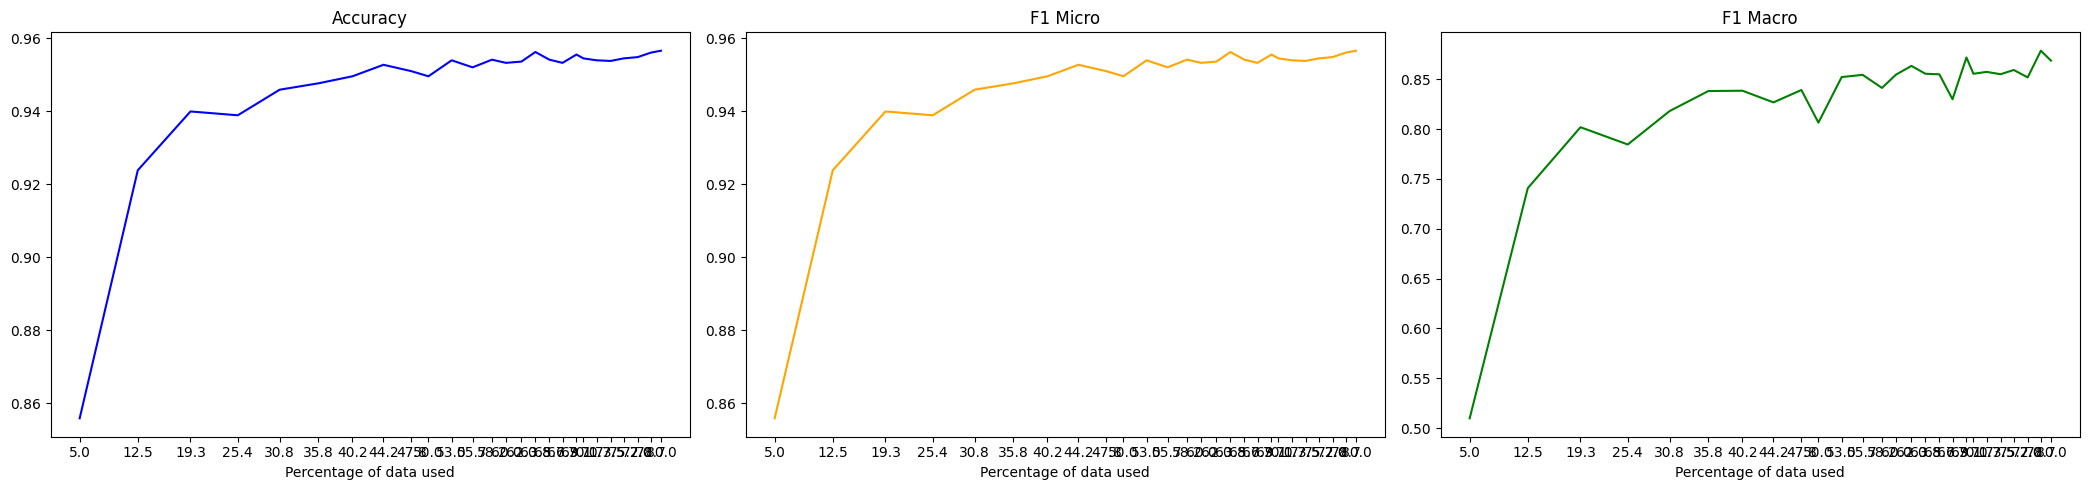

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.562457323074341 | ACCURACY: 0.7929 | F1 MACRO: 0.8755 | F1 MICRO: 0.8832
EPOCH 2 | LOSS: 2.420147180557251 | ACCURACY: 0.8012 | F1 MACRO: 0.8776 | F1 MICRO: 0.8873
EPOCH 3 | LOSS: 2.2811529636383057 | ACCURACY: 0.8024 | F1 MACRO: 0.8848 | F1 MICRO: 0.8898
EPOCH 4 | LOSS: 2.1648266315460205 | ACCURACY: 0.8167 | F1 MACRO: 0.8861 | F1 MICRO: 0.8952
EPOCH 5 | LOSS: 2.152181625366211 | ACCURACY: 0.8153 | F1 MACRO: 0.8872 | F1 MICRO: 0.8948
EPOCH 6 | LOSS: 2.1010782718658447 | ACCURACY: 0.8214 | F1 MACRO: 0.8901 | F1 MICRO: 0.8977
EPOCH 7 | LOSS: 2.086541175842285 | ACCURACY: 0.8368 | F1 MACRO: 0.8979 | F1 MICRO: 0.9055
EPOCH 8 | LOSS: 2.0817577838897705 | ACCURACY: 0.849 | F1 MACRO: 0.9046 | F1 MICRO: 0.9117
EPOCH 9 | LOSS: 2.115778684616089 | ACCURACY: 0.8552 | F1 MACRO: 0.909 | F1 MICRO: 0.9153
EPOCH 10 | LOSS: 2.102389574050

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 42.14442825317383 | ACCURACY: 0.7965 | F1 MACRO: 0.7582 | F1 MICRO: 0.7965
EPOCH 2 | LOSS: 37.51209259033203 | ACCURACY: 0.8401 | F1 MACRO: 0.8312 | F1 MICRO: 0.8401
EPOCH 3 | LOSS: 34.15577697753906 | ACCURACY: 0.8605 | F1 MACRO: 0.8461 | F1 MICRO: 0.8605
EPOCH 4 | LOSS: 31.54072380065918 | ACCURACY: 0.8532 | F1 MACRO: 0.8462 | F1 MICRO: 0.8532
EPOCH 5 | LOSS: 29.95027732849121 | ACCURACY: 0.8924 | F1 MACRO: 0.8863 | F1 MICRO: 0.8924
EPOCH 6 | LOSS: 28.108654022216797 | ACCURACY: 0.875 | F1 MACRO: 0.8624 | F1 MICRO: 0.875
EPOCH 7 | LOSS: 26.116910934448242 | ACCURACY: 0.8983 | F1 MACRO: 0.8911 | F1 MICRO: 0.8983
EPOCH 8 | LOSS: 26.22300148010254 | ACCURACY: 0.8852 | F1 MACRO: 0.8783 | F1 MICRO: 0.8852
EPOCH 9 | LOSS: 24.563007354736328 | ACCURACY: 0.891 | F1 MACRO: 0.8855 | F1 MICRO: 0.891
EPOCH 10 | LOSS: 24.191312789916992 | ACCURACY: 0.891 | F1 MACRO: 0.8804 | F1 MICRO: 0.891
sentiment: ACCURACY 0.8983 | F1 MACRO 0.8911 | F1 MICRO 0.8983
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.101980686187744
Samples above threshold: 215
Acquired samples: 215
Sampling duration: 18.64328932762146 seconds
New train size: 357
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.3548924922943115 | ACCURACY: 0.8026 | F1 MACRO: 0.8844 | F1 MICRO: 0.8898
EPOCH 2 | LOSS: 2.061702251434326 | ACCURACY: 0.8139 | F1 MACRO: 0.8903 | F1 MICRO: 0.8953
EPOCH 3 | LOSS: 1.9822245836257935 | ACCURACY: 0.8373 | F1 MACRO: 0.9004 | F1 MICRO: 0.9066
EPOCH 4 | LOSS: 1.948517918586731 | ACCURACY: 0.8649 | F1 MACRO: 0.9151 | F1 MICRO: 0.9206
EPOCH 5 | LOSS: 1.9562907218933105 | ACCURACY: 0.8868 | F1 MACRO: 0.9276 | F1 MICRO: 0.9325
EPOCH 6 | LOSS: 1.922894835472107 | ACCURACY: 0.9033 | F1 MACRO: 0.9379 | F1 MICRO: 0.942
EPOCH 7 | LOSS: 1.8086398839950562 | ACCURACY: 0.9101 | F1 MACRO: 0.9425 | F1 MICRO: 0.9457
EPOCH 8 | LOSS: 1.7476533651351929 | ACCURACY: 0.917 | F1 MACRO: 0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 19.77067756652832 | ACCURACY: 0.8447 | F1 MACRO: 0.7702 | F1 MICRO: 0.8447
EPOCH 2 | LOSS: 17.31769371032715 | ACCURACY: 0.8689 | F1 MACRO: 0.8061 | F1 MICRO: 0.8689
EPOCH 3 | LOSS: 16.47444725036621 | ACCURACY: 0.8689 | F1 MACRO: 0.8184 | F1 MICRO: 0.8689
EPOCH 4 | LOSS: 15.645991325378418 | ACCURACY: 0.88 | F1 MACRO: 0.8303 | F1 MICRO: 0.88
EPOCH 5 | LOSS: 14.776187896728516 | ACCURACY: 0.8645 | F1 MACRO: 0.8265 | F1 MICRO: 0.8645
EPOCH 6 | LOSS: 14.329788208007812 | ACCURACY: 0.8943 | F1 MACRO: 0.856 | F1 MICRO: 0.8943
EPOCH 7 | LOSS: 13.417097091674805 | ACCURACY: 0.8888 | F1 MACRO: 0.8528 | F1 MICRO: 0.8888
EPOCH 8 | LOSS: 13.20191478729248 | ACCURACY: 0.8899 | F1 MACRO: 0.8527 | F1 MICRO: 0.8899
EPOCH 9 | LOSS: 12.828124046325684 | ACCURACY: 0.8866 | F1 MACRO: 0.8511 | F1 MICRO: 0.8866
EPOCH 10 | LOSS: 12.21548843383789 | ACCURACY: 0.8822 | F1 MACRO: 0.8431 | F1 MICRO: 0.8822
sentiment: ACCURACY 0.8943 | F1 MACRO 0.856 | F1 MICRO 0.8943
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 357: Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.6963
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.98      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.87      0.72      0.79        86
     neutral       0.94      0.97      0.95       475
    positive       0.08      0.10      0.09        10

    accuracy                           0.91       571
   macro avg       0.63      0.60      0.61       571
weighted avg       0.92      0.91      0.91       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.0400785207748413
Samples above threshold: 193
Acquired samples: 193
Sampling duration: 27.126103162765503 seconds
New train size: 550
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.2457773685455322 | ACCURACY: 0.8104 | F1 MACRO: 0.887 | F1 MICRO: 0.8933
EPOCH 2 | LOSS: 1.987726092338562 | ACCURACY: 0.8403 | F1 MACRO: 0.9011 | F1 MICRO: 0.9076
EPOCH 3 | LOSS: 1.9225255250930786 | ACCURACY: 0.888 | F1 MACRO: 0.9271 | F1 MICRO: 0.933
EPOCH 4 | LOSS: 1.8752691745758057 | ACCURACY: 0.9035 | F1 MACRO: 0.937 | F1 MICRO: 0.9416
EPOCH 5 | LOSS: 1.779508352279663 | ACCURACY: 0.9146 | F1 MACRO: 0.9447 | F1 MICRO: 0.9483
EPOCH 6 | LOSS: 1.7175040245056152 | ACCURACY: 0.9253 | F1 MACRO: 0.9516 | F1 MICRO: 0.9546
EPOCH 7 | LOSS: 1.6824003458023071 | ACCURACY: 0.9333 | F1 MACRO: 0.9565 | F1 MICRO: 0.9592
EPOCH 8 | LOSS: 1.6273219585418701 | ACCURACY: 0.9351 | F1 MACRO: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 14.55642318725586 | ACCURACY: 0.8297 | F1 MACRO: 0.7527 | F1 MICRO: 0.8297
EPOCH 2 | LOSS: 12.710186958312988 | ACCURACY: 0.8632 | F1 MACRO: 0.8162 | F1 MICRO: 0.8632
EPOCH 3 | LOSS: 11.989437103271484 | ACCURACY: 0.8861 | F1 MACRO: 0.8467 | F1 MICRO: 0.8861
EPOCH 4 | LOSS: 11.513954162597656 | ACCURACY: 0.89 | F1 MACRO: 0.8534 | F1 MICRO: 0.89
EPOCH 5 | LOSS: 11.04430866241455 | ACCURACY: 0.8833 | F1 MACRO: 0.8446 | F1 MICRO: 0.8833
EPOCH 6 | LOSS: 10.550704002380371 | ACCURACY: 0.89 | F1 MACRO: 0.8534 | F1 MICRO: 0.89
EPOCH 7 | LOSS: 10.278067588806152 | ACCURACY: 0.8938 | F1 MACRO: 0.8609 | F1 MICRO: 0.8938
EPOCH 8 | LOSS: 9.914600372314453 | ACCURACY: 0.8871 | F1 MACRO: 0.8537 | F1 MICRO: 0.8871
EPOCH 9 | LOSS: 9.72703742980957 | ACCURACY: 0.8938 | F1 MACRO: 0.8648 | F1 MICRO: 0.8938
EPOCH 10 | LOSS: 9.320112228393555 | ACCURACY: 0.8861 | F1 MACRO: 0.8486 | F1 MICRO: 0.8861
sentiment: ACCURACY 0.8938 | F1 MACRO 0.8648 | F1 MICRO 0.8938
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 550: Accuracy: 0.9413, F1 Micro: 0.9413, F1 Macro: 0.8027
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.95      0.95      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.84      0.87        86
     neutral       0.98      0.97      0.98       475
    positive       0.30      0.60      0.40        10

    accuracy                           0.95       571
   macro avg       0.73      0.80      0.75       571
weighted avg       0.96      0.95      0.95       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.001091718673706
Samples above threshold: 174
Acquired samples: 174
Sampling duration: 34.025081634521484 seconds
New train size: 724
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.1334545612335205 | ACCURACY: 0.8198 | F1 MACRO: 0.889 | F1 MICRO: 0.897
EPOCH 2 | LOSS: 1.9077553749084473 | ACCURACY: 0.8691 | F1 MACRO: 0.9159 | F1 MICRO: 0.9223
EPOCH 3 | LOSS: 1.8533496856689453 | ACCURACY: 0.905 | F1 MACRO: 0.9383 | F1 MICRO: 0.9427
EPOCH 4 | LOSS: 1.7577675580978394 | ACCURACY: 0.9231 | F1 MACRO: 0.9505 | F1 MICRO: 0.9535
EPOCH 5 | LOSS: 1.6916766166687012 | ACCURACY: 0.9349 | F1 MACRO: 0.9561 | F1 MICRO: 0.96
EPOCH 6 | LOSS: 1.634770154953003 | ACCURACY: 0.9396 | F1 MACRO: 0.9595 | F1 MICRO: 0.9627
EPOCH 7 | LOSS: 1.5781092643737793 | ACCURACY: 0.9424 | F1 MACRO: 0.9618 | F1 MICRO: 0.9645
EPOCH 8 | LOSS: 1.5477476119995117 | ACCURACY: 0.9396 | F1 MACRO: 0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 11.335261344909668 | ACCURACY: 0.8529 | F1 MACRO: 0.8163 | F1 MICRO: 0.8529
EPOCH 2 | LOSS: 9.701245307922363 | ACCURACY: 0.8744 | F1 MACRO: 0.843 | F1 MICRO: 0.8744
EPOCH 3 | LOSS: 9.212875366210938 | ACCURACY: 0.8763 | F1 MACRO: 0.8444 | F1 MICRO: 0.8763
EPOCH 4 | LOSS: 8.875886917114258 | ACCURACY: 0.8772 | F1 MACRO: 0.8405 | F1 MICRO: 0.8772
EPOCH 5 | LOSS: 8.775474548339844 | ACCURACY: 0.8913 | F1 MACRO: 0.8615 | F1 MICRO: 0.8913
EPOCH 6 | LOSS: 8.342595100402832 | ACCURACY: 0.8838 | F1 MACRO: 0.8492 | F1 MICRO: 0.8838
EPOCH 7 | LOSS: 8.233500480651855 | ACCURACY: 0.8894 | F1 MACRO: 0.8615 | F1 MICRO: 0.8894
EPOCH 8 | LOSS: 7.872110843658447 | ACCURACY: 0.881 | F1 MACRO: 0.8552 | F1 MICRO: 0.881
EPOCH 9 | LOSS: 7.515881061553955 | ACCURACY: 0.8772 | F1 MACRO: 0.8526 | F1 MICRO: 0.8772
EPOCH 10 | LOSS: 7.559996604919434 | ACCURACY: 0.8819 | F1 MACRO: 0.8551 | F1 MICRO: 0.8819
sentiment: ACCURACY 0.8913 | F1 MACRO 0.8615 | F1 MICRO 0.8913
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 724: Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.8231
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.94      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.87      0.85      0.86        86
     neutral       0.97      0.99      0.98       475
    positive       0.67      0.40      0.50        10

    accuracy                           0.95       571
   macro avg       0.84      0.74      0.78       571
weighted avg       0.95      0.95      0.95       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9021323680877686
Samples above threshold: 156
Acquired samples: 156
Sampling duration: 37.90372085571289 seconds
New train size: 880
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.146763801574707 | ACCURACY: 0.8203 | F1 MACRO: 0.8879 | F1 MICRO: 0.8964
EPOCH 2 | LOSS: 1.9402939081192017 | ACCURACY: 0.8868 | F1 MACRO: 0.9249 | F1 MICRO: 0.9316
EPOCH 3 | LOSS: 1.8744934797286987 | ACCURACY: 0.9148 | F1 MACRO: 0.9441 | F1 MICRO: 0.9483
EPOCH 4 | LOSS: 1.7531601190567017 | ACCURACY: 0.926 | F1 MACRO: 0.9524 | F1 MICRO: 0.9553
EPOCH 5 | LOSS: 1.6990985870361328 | ACCURACY: 0.9351 | F1 MACRO: 0.9561 | F1 MICRO: 0.9602
EPOCH 6 | LOSS: 1.6362208127975464 | ACCURACY: 0.9431 | F1 MACRO: 0.9615 | F1 MICRO: 0.9649
EPOCH 7 | LOSS: 1.591808557510376 | ACCURACY: 0.949 | F1 MACRO: 0.9656 | F1 MICRO: 0.9684
EPOCH 8 | LOSS: 1.5515670776367188 | ACCURACY: 0.9505 | F1 MACRO:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 9.41826343536377 | ACCURACY: 0.85 | F1 MACRO: 0.8034 | F1 MICRO: 0.85
EPOCH 2 | LOSS: 8.092782020568848 | ACCURACY: 0.8593 | F1 MACRO: 0.8045 | F1 MICRO: 0.8593
EPOCH 3 | LOSS: 7.86035680770874 | ACCURACY: 0.8788 | F1 MACRO: 0.8342 | F1 MICRO: 0.8788
EPOCH 4 | LOSS: 7.366122245788574 | ACCURACY: 0.877 | F1 MACRO: 0.8367 | F1 MICRO: 0.877
EPOCH 5 | LOSS: 7.151233196258545 | ACCURACY: 0.8844 | F1 MACRO: 0.8491 | F1 MICRO: 0.8844
EPOCH 6 | LOSS: 6.856371879577637 | ACCURACY: 0.9003 | F1 MACRO: 0.87 | F1 MICRO: 0.9003
EPOCH 7 | LOSS: 6.878361225128174 | ACCURACY: 0.8938 | F1 MACRO: 0.8665 | F1 MICRO: 0.8938
EPOCH 8 | LOSS: 6.531700134277344 | ACCURACY: 0.8826 | F1 MACRO: 0.8445 | F1 MICRO: 0.8826
EPOCH 9 | LOSS: 6.2944135665893555 | ACCURACY: 0.8928 | F1 MACRO: 0.8606 | F1 MICRO: 0.8928
EPOCH 10 | LOSS: 6.180006980895996 | ACCURACY: 0.8891 | F1 MACRO: 0.8557 | F1 MICRO: 0.8891
sentiment: ACCURACY 0.9003 | F1 MACRO 0.87 | F1 MICRO 0.9003
              precision    recall  f1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 880: Accuracy: 0.9489, F1 Micro: 0.9489, F1 Macro: 0.8399
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.95      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.88      0.87      0.88        86
     neutral       0.98      0.98      0.98       475
    positive       0.56      0.50      0.53        10

    accuracy                           0.96       571
   macro avg       0.81      0.79      0.79       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9022505283355713
Samples above threshold: 141
Acquired samples: 141
Sampling duration: 41.71601176261902 seconds
New train size: 1021
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.096341133117676 | ACCURACY: 0.8273 | F1 MACRO: 0.8961 | F1 MICRO: 0.9016
EPOCH 2 | LOSS: 1.895642876625061 | ACCURACY: 0.8967 | F1 MACRO: 0.9332 | F1 MICRO: 0.9379
EPOCH 3 | LOSS: 1.8013657331466675 | ACCURACY: 0.9309 | F1 MACRO: 0.9541 | F1 MICRO: 0.9576
EPOCH 4 | LOSS: 1.6909689903259277 | ACCURACY: 0.9352 | F1 MACRO: 0.9576 | F1 MICRO: 0.9606
EPOCH 5 | LOSS: 1.6175739765167236 | ACCURACY: 0.9424 | F1 MACRO: 0.9617 | F1 MICRO: 0.9646
EPOCH 6 | LOSS: 1.5759201049804688 | ACCURACY: 0.9455 | F1 MACRO: 0.9637 | F1 MICRO: 0.9665
EPOCH 7 | LOSS: 1.533072829246521 | ACCURACY: 0.9483 | F1 MACRO: 0.9652 | F1 MICRO: 0.9681
EPOCH 8 | LOSS: 1.4980390071868896 | ACCURACY: 0.9493 | F1 MACRO: 0.966 | F1 MICRO: 0.9686
EPOCH 9 | LOSS: 1.4614384174346924 | ACCURACY: 0.9512 | F1 MACRO: 0.967 | F1 MICRO: 0.9698
EPOCH 10 | LOSS: 1.4239143133163452 | ACCURACY: 0.9503 | F1 MACRO: 0.9665 | F1 MICRO: 0.9693
aspect: ACCURACY 0.9512 | F1 MACRO 0.967 | F1 MICRO 0.9698
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.161477088928223 | ACCURACY: 0.8371 | F1 MACRO: 0.7716 | F1 MICRO: 0.8371
EPOCH 2 | LOSS: 6.985782146453857 | ACCURACY: 0.8752 | F1 MACRO: 0.8404 | F1 MICRO: 0.8752
EPOCH 3 | LOSS: 6.561962604522705 | ACCURACY: 0.878 | F1 MACRO: 0.839 | F1 MICRO: 0.878
EPOCH 4 | LOSS: 6.152890205383301 | ACCURACY: 0.8799 | F1 MACRO: 0.8418 | F1 MICRO: 0.8799
EPOCH 5 | LOSS: 6.055905818939209 | ACCURACY: 0.8659 | F1 MACRO: 0.8154 | F1 MICRO: 0.8659
EPOCH 6 | LOSS: 5.856542110443115 | ACCURACY: 0.8901 | F1 MACRO: 0.8603 | F1 MICRO: 0.8901
EPOCH 7 | LOSS: 5.6899614334106445 | ACCURACY: 0.8966 | F1 MACRO: 0.8673 | F1 MICRO: 0.8966
EPOCH 8 | LOSS: 5.516085147857666 | ACCURACY: 0.8864 | F1 MACRO: 0.855 | F1 MICRO: 0.8864
EPOCH 9 | LOSS: 5.382331371307373 | ACCURACY: 0.8911 | F1 MACRO: 0.8601 | F1 MICRO: 0.8911
EPOCH 10 | LOSS: 5.104438304901123 | ACCURACY: 0.8808 | F1 MACRO: 0.8472 | F1 MICRO: 0.8808
sentiment: ACCURACY 0.8966 | F1 MACRO 0.8673 | F1 MICRO 0.8966
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1021: Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.8111
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.94      0.92      0.93        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.92      0.97      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.86      0.88        86
     neutral       0.98      0.99      0.98       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.83      0.78      0.80       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.020391607284546
Samples above threshold: 127
Acquired samples: 127
Sampling duration: 45.1820068359375 seconds
New train size: 1148
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.0818896293640137 | ACCURACY: 0.8335 | F1 MACRO: 0.8992 | F1 MICRO: 0.9047
EPOCH 2 | LOSS: 1.8682057857513428 | ACCURACY: 0.9062 | F1 MACRO: 0.9393 | F1 MICRO: 0.9434
EPOCH 3 | LOSS: 1.7512954473495483 | ACCURACY: 0.9332 | F1 MACRO: 0.9557 | F1 MICRO: 0.9592
EPOCH 4 | LOSS: 1.6640628576278687 | ACCURACY: 0.9361 | F1 MACRO: 0.9577 | F1 MICRO: 0.961
EPOCH 5 | LOSS: 1.5876882076263428 | ACCURACY: 0.9396 | F1 MACRO: 0.9598 | F1 MICRO: 0.9629
EPOCH 6 | LOSS: 1.5309165716171265 | ACCURACY: 0.9505 | F1 MACRO: 0.967 | F1 MICRO: 0.9695
EPOCH 7 | LOSS: 1.4784876108169556 | ACCURACY: 0.9512 | F1 MACRO: 0.9671 | F1 MICRO: 0.9698
EPOCH 8 | LOSS: 1.4491122961044312 | ACCURACY: 0.9538 | F1 MACRO

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 7.0279974937438965 | ACCURACY: 0.8368 | F1 MACRO: 0.7632 | F1 MICRO: 0.8368
EPOCH 2 | LOSS: 6.050562858581543 | ACCURACY: 0.883 | F1 MACRO: 0.8528 | F1 MICRO: 0.883
EPOCH 3 | LOSS: 5.697731018066406 | ACCURACY: 0.9019 | F1 MACRO: 0.8698 | F1 MICRO: 0.9019
EPOCH 4 | LOSS: 5.5099196434021 | ACCURACY: 0.8868 | F1 MACRO: 0.8551 | F1 MICRO: 0.8868
EPOCH 5 | LOSS: 5.317168235778809 | ACCURACY: 0.9 | F1 MACRO: 0.8689 | F1 MICRO: 0.9
EPOCH 6 | LOSS: 5.152116298675537 | ACCURACY: 0.9047 | F1 MACRO: 0.8753 | F1 MICRO: 0.9047
EPOCH 7 | LOSS: 4.9270219802856445 | ACCURACY: 0.8972 | F1 MACRO: 0.8637 | F1 MICRO: 0.8972
EPOCH 8 | LOSS: 4.771358966827393 | ACCURACY: 0.8972 | F1 MACRO: 0.8641 | F1 MICRO: 0.8972
EPOCH 9 | LOSS: 4.5746660232543945 | ACCURACY: 0.9009 | F1 MACRO: 0.87 | F1 MICRO: 0.9009
EPOCH 10 | LOSS: 4.52126932144165 | ACCURACY: 0.8821 | F1 MACRO: 0.8499 | F1 MICRO: 0.8821
sentiment: ACCURACY 0.9047 | F1 MACRO 0.8753 | F1 MICRO 0.9047
              precision    recall  f

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1148: Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.8508
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.84      0.87        86
     neutral       0.98      0.99      0.98       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.83      0.78      0.80       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.833316612243652
Samples above threshold: 114
Acquired samples: 114
Sampling duration: 48.02653670310974 seconds
New train size: 1262
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0791847705841064 | ACCURACY: 0.8465 | F1 MACRO: 0.9026 | F1 MICRO: 0.9109
EPOCH 2 | LOSS: 1.8838590383529663 | ACCURACY: 0.9201 | F1 MACRO: 0.9474 | F1 MICRO: 0.9513
EPOCH 3 | LOSS: 1.747388243675232 | ACCURACY: 0.9375 | F1 MACRO: 0.9584 | F1 MICRO: 0.9617
EPOCH 4 | LOSS: 1.66710364818573 | ACCURACY: 0.9429 | F1 MACRO: 0.9611 | F1 MICRO: 0.9647
EPOCH 5 | LOSS: 1.6106712818145752 | ACCURACY: 0.9507 | F1 MACRO: 0.9668 | F1 MICRO: 0.9695
EPOCH 6 | LOSS: 1.5471352338790894 | ACCURACY: 0.9517 | F1 MACRO: 0.9677 | F1 MICRO: 0.9702
EPOCH 7 | LOSS: 1.4979274272918701 | ACCURACY: 0.9531 | F1 MACRO: 0.9684 | F1 MICRO: 0.9709
EPOCH 8 | LOSS: 1.4495124816894531 | ACCURACY: 0.9514 | F1 MACRO: 0.9673 | F1 MICRO: 0.97
EPOCH 9 | LOSS: 1.4288984537124634 | ACCURACY: 0.9523 | F1 MACRO: 0.9675 | F1 MICRO: 0.9705
EPOCH 10 | LOSS: 1.3859328031539917 | ACCURACY: 0.9535 | F1 MACRO: 0.9686 | F1 MICRO: 0.9712
aspect: ACCURACY 0.9535 | F1 MACRO 0.9686 | F1 MICRO 0.9712
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.609199047088623 | ACCURACY: 0.8513 | F1 MACRO: 0.8002 | F1 MICRO: 0.8513
EPOCH 2 | LOSS: 5.529352188110352 | ACCURACY: 0.8707 | F1 MACRO: 0.8251 | F1 MICRO: 0.8707
EPOCH 3 | LOSS: 5.337134838104248 | ACCURACY: 0.891 | F1 MACRO: 0.8602 | F1 MICRO: 0.891
EPOCH 4 | LOSS: 5.093794345855713 | ACCURACY: 0.8975 | F1 MACRO: 0.8695 | F1 MICRO: 0.8975
EPOCH 5 | LOSS: 4.802253246307373 | ACCURACY: 0.8966 | F1 MACRO: 0.8676 | F1 MICRO: 0.8966
EPOCH 6 | LOSS: 4.727517604827881 | ACCURACY: 0.8947 | F1 MACRO: 0.8621 | F1 MICRO: 0.8947
EPOCH 7 | LOSS: 4.51511812210083 | ACCURACY: 0.8846 | F1 MACRO: 0.8561 | F1 MICRO: 0.8846
EPOCH 8 | LOSS: 4.33381986618042 | ACCURACY: 0.9003 | F1 MACRO: 0.8728 | F1 MICRO: 0.9003
EPOCH 9 | LOSS: 4.230128765106201 | ACCURACY: 0.8938 | F1 MACRO: 0.8659 | F1 MICRO: 0.8938
EPOCH 10 | LOSS: 4.137594699859619 | ACCURACY: 0.9012 | F1 MACRO: 0.8752 | F1 MICRO: 0.9012
sentiment: ACCURACY 0.9012 | F1 MACRO 0.8752 | F1 MICRO 0.9012
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1262: Accuracy: 0.9513, F1 Micro: 0.9513, F1 Macro: 0.8393
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.84      0.87        86
     neutral       0.98      0.99      0.98       475
    positive       0.38      0.50      0.43        10

    accuracy                           0.96       571
   macro avg       0.76      0.77      0.76       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.001593589782715
Samples above threshold: 103
Acquired samples: 103
Sampling duration: 54.21117115020752 seconds
New train size: 1365
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.0346550941467285 | ACCURACY: 0.8573 | F1 MACRO: 0.9033 | F1 MICRO: 0.9152
EPOCH 2 | LOSS: 1.8569999933242798 | ACCURACY: 0.9198 | F1 MACRO: 0.9484 | F1 MICRO: 0.9516
EPOCH 3 | LOSS: 1.6999748945236206 | ACCURACY: 0.941 | F1 MACRO: 0.9605 | F1 MICRO: 0.9637
EPOCH 4 | LOSS: 1.6155588626861572 | ACCURACY: 0.9448 | F1 MACRO: 0.9636 | F1 MICRO: 0.9662
EPOCH 5 | LOSS: 1.5651274919509888 | ACCURACY: 0.9509 | F1 MACRO: 0.9669 | F1 MICRO: 0.9697
EPOCH 6 | LOSS: 1.505057692527771 | ACCURACY: 0.9552 | F1 MACRO: 0.97 | F1 MICRO: 0.9723
EPOCH 7 | LOSS: 1.4700731039047241 | ACCURACY: 0.9545 | F1 MACRO: 0.9692 | F1 MICRO: 0.9718
EPOCH 8 | LOSS: 1.4185258150100708 | ACCURACY: 0.9549 | F1 MACRO:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.8628106117248535 | ACCURACY: 0.859 | F1 MACRO: 0.8122 | F1 MICRO: 0.859
EPOCH 2 | LOSS: 5.081872463226318 | ACCURACY: 0.8766 | F1 MACRO: 0.8383 | F1 MICRO: 0.8766
EPOCH 3 | LOSS: 4.807430744171143 | ACCURACY: 0.8859 | F1 MACRO: 0.8479 | F1 MICRO: 0.8859
EPOCH 4 | LOSS: 4.679699420928955 | ACCURACY: 0.8813 | F1 MACRO: 0.8494 | F1 MICRO: 0.8813
EPOCH 5 | LOSS: 4.524814128875732 | ACCURACY: 0.8766 | F1 MACRO: 0.844 | F1 MICRO: 0.8766
EPOCH 6 | LOSS: 4.314780235290527 | ACCURACY: 0.8896 | F1 MACRO: 0.8532 | F1 MICRO: 0.8896
EPOCH 7 | LOSS: 4.157568454742432 | ACCURACY: 0.8915 | F1 MACRO: 0.8597 | F1 MICRO: 0.8915
EPOCH 8 | LOSS: 4.078768730163574 | ACCURACY: 0.8887 | F1 MACRO: 0.8585 | F1 MICRO: 0.8887
EPOCH 9 | LOSS: 4.038999080657959 | ACCURACY: 0.897 | F1 MACRO: 0.8712 | F1 MICRO: 0.897
EPOCH 10 | LOSS: 3.8435726165771484 | ACCURACY: 0.8701 | F1 MACRO: 0.8383 | F1 MICRO: 0.8701
sentiment: ACCURACY 0.897 | F1 MACRO 0.8712 | F1 MICRO 0.897
              precision    reca

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1365: Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.8419
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.91      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.79      1.00      0.88        15

    accuracy                           0.98       571
   macro avg       0.92      0.97      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.83      0.88        86
     neutral       0.97      0.99      0.98       475
    positive       0.54      0.70      0.61        10

    accuracy                           0.96       571
   macro avg       0.82      0.84      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9102264404296876
Samples above threshold: 92
Acquired samples: 62
Sampling duration: 56.256147384643555 seconds
New train size: 1427
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0302956104278564 | ACCURACY: 0.8653 | F1 MACRO: 0.9157 | F1 MICRO: 0.9211
EPOCH 2 | LOSS: 1.8255409002304077 | ACCURACY: 0.9262 | F1 MACRO: 0.9519 | F1 MICRO: 0.9551
EPOCH 3 | LOSS: 1.6921780109405518 | ACCURACY: 0.9422 | F1 MACRO: 0.9621 | F1 MICRO: 0.9647
EPOCH 4 | LOSS: 1.6012344360351562 | ACCURACY: 0.949 | F1 MACRO: 0.9659 | F1 MICRO: 0.9686
EPOCH 5 | LOSS: 1.5377674102783203 | ACCURACY: 0.9477 | F1 MACRO: 0.9653 | F1 MICRO: 0.9679
EPOCH 6 | LOSS: 1.4931306838989258 | ACCURACY: 0.9556 | F1 MACRO: 0.97 | F1 MICRO: 0.9725
EPOCH 7 | LOSS: 1.4524784088134766 | ACCURACY: 0.9507 | F1 MACRO: 0.9664 | F1 MICRO: 0.9696
EPOCH 8 | LOSS: 1.4114766120910645 | ACCURACY: 0.954 | F1 MACRO: 0.9693 | F1 MICRO: 0.9716
EPOCH 9 | LOSS: 1.3792568445205688 | ACCURACY: 0.9528 | F1 MACRO: 0.9675 | F1 MICRO: 0.9705
EPOCH 10 | LOSS: 1.349377155303955 | ACCURACY: 0.9542 | F1 MACRO: 0.9689 | F1 MICRO: 0.9716
aspect: ACCURACY 0.9556 | F1 MACRO 0.97 | F1 MICRO 0.9725
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.748361110687256 | ACCURACY: 0.8558 | F1 MACRO: 0.8203 | F1 MICRO: 0.8558
EPOCH 2 | LOSS: 4.834413528442383 | ACCURACY: 0.8781 | F1 MACRO: 0.8413 | F1 MICRO: 0.8781
EPOCH 3 | LOSS: 4.581799507141113 | ACCURACY: 0.8791 | F1 MACRO: 0.8393 | F1 MICRO: 0.8791
EPOCH 4 | LOSS: 4.52559232711792 | ACCURACY: 0.8884 | F1 MACRO: 0.8568 | F1 MICRO: 0.8884
EPOCH 5 | LOSS: 4.307213306427002 | ACCURACY: 0.893 | F1 MACRO: 0.8669 | F1 MICRO: 0.893
EPOCH 6 | LOSS: 4.162503719329834 | ACCURACY: 0.9014 | F1 MACRO: 0.8738 | F1 MICRO: 0.9014
EPOCH 7 | LOSS: 4.096818447113037 | ACCURACY: 0.9005 | F1 MACRO: 0.8707 | F1 MICRO: 0.9005
EPOCH 8 | LOSS: 3.941584348678589 | ACCURACY: 0.9023 | F1 MACRO: 0.8762 | F1 MICRO: 0.9023
EPOCH 9 | LOSS: 3.7632944583892822 | ACCURACY: 0.9014 | F1 MACRO: 0.8749 | F1 MICRO: 0.9014
EPOCH 10 | LOSS: 3.7235043048858643 | ACCURACY: 0.8856 | F1 MACRO: 0.8585 | F1 MICRO: 0.8856
sentiment: ACCURACY 0.9023 | F1 MACRO 0.8762 | F1 MICRO 0.9023
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0423803329467773 | ACCURACY: 0.8665 | F1 MACRO: 0.9173 | F1 MICRO: 0.9222
EPOCH 2 | LOSS: 1.861167073249817 | ACCURACY: 0.9271 | F1 MACRO: 0.9522 | F1 MICRO: 0.9556
EPOCH 3 | LOSS: 1.7131309509277344 | ACCURACY: 0.9403 | F1 MACRO: 0.9603 | F1 MICRO: 0.9633
EPOCH 4 | LOSS: 1.614755630493164 | ACCURACY: 0.9493 | F1 MACRO: 0.9657 | F1 MICRO: 0.9689
EPOCH 5 | LOSS: 1.5712693929672241 | ACCURACY: 0.9521 | F1 MACRO: 0.9676 | F1 MICRO: 0.9704
EPOCH 6 | LOSS: 1.5124802589416504 | ACCURACY: 0.9488 | F1 MACRO: 0.9657 | F1 MICRO: 0.9685
EPOCH 7 | LOSS: 1.472549319267273 | ACCURACY: 0.9523 | F1 MACRO: 0.9674 | F1 MICRO: 0.9704
EPOCH 8 | LOSS: 1.4189589023590088 | ACCURACY: 0.9576 | F1 MACRO: 0.9707 | F1 MICRO: 0.9737
EPOCH 9 | LOSS: 1.4068939685821533 | ACCURACY: 0.9575 | F1 MACRO: 0.9712 | F1 MICRO: 0.9736
EPOCH 10 | LOSS: 1.359876036643982 | ACCURACY: 0.9552 | F1 MACRO: 0.9697 | F1 MICRO: 0.9723
aspect: ACCURACY 0.9576 | F1 MACRO 0.9707 | F1 MICRO 0.9737
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.485050678253174 | ACCURACY: 0.8466 | F1 MACRO: 0.8013 | F1 MICRO: 0.8466
EPOCH 2 | LOSS: 4.6937031745910645 | ACCURACY: 0.8698 | F1 MACRO: 0.8342 | F1 MICRO: 0.8698
EPOCH 3 | LOSS: 4.451918125152588 | ACCURACY: 0.8742 | F1 MACRO: 0.8351 | F1 MICRO: 0.8742
EPOCH 4 | LOSS: 4.290492057800293 | ACCURACY: 0.8814 | F1 MACRO: 0.8513 | F1 MICRO: 0.8814
EPOCH 5 | LOSS: 4.1049604415893555 | ACCURACY: 0.8885 | F1 MACRO: 0.8616 | F1 MICRO: 0.8885
EPOCH 6 | LOSS: 3.9214389324188232 | ACCURACY: 0.8858 | F1 MACRO: 0.855 | F1 MICRO: 0.8858
EPOCH 7 | LOSS: 3.888406276702881 | ACCURACY: 0.8885 | F1 MACRO: 0.8619 | F1 MICRO: 0.8885
EPOCH 8 | LOSS: 3.7749359607696533 | ACCURACY: 0.8849 | F1 MACRO: 0.8586 | F1 MICRO: 0.8849
EPOCH 9 | LOSS: 3.6825640201568604 | ACCURACY: 0.8831 | F1 MACRO: 0.8511 | F1 MICRO: 0.8831
EPOCH 10 | LOSS: 3.5845797061920166 | ACCURACY: 0.884 | F1 MACRO: 0.8539 | F1 MICRO: 0.884
sentiment: ACCURACY 0.8885 | F1 MACRO 0.8619 | F1 MICRO 0.8885
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1513: Accuracy: 0.9501, F1 Micro: 0.9501, F1 Macro: 0.8462
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.42      0.50      0.45        10

    accuracy                           0.96       571
   macro avg       0.77      0.79      0.78       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0149519443511963 | ACCURACY: 0.8738 | F1 MACRO: 0.9196 | F1 MICRO: 0.9253
EPOCH 2 | LOSS: 1.8247811794281006 | ACCURACY: 0.9288 | F1 MACRO: 0.9531 | F1 MICRO: 0.9566
EPOCH 3 | LOSS: 1.6835408210754395 | ACCURACY: 0.9387 | F1 MACRO: 0.9598 | F1 MICRO: 0.9625
EPOCH 4 | LOSS: 1.5980851650238037 | ACCURACY: 0.9434 | F1 MACRO: 0.9622 | F1 MICRO: 0.9653
EPOCH 5 | LOSS: 1.535345435142517 | ACCURACY: 0.9505 | F1 MACRO: 0.9659 | F1 MICRO: 0.9693
EPOCH 6 | LOSS: 1.4790602922439575 | ACCURACY: 0.9554 | F1 MACRO: 0.9691 | F1 MICRO: 0.9722
EPOCH 7 | LOSS: 1.4384956359863281 | ACCURACY: 0.9554 | F1 MACRO: 0.9696 | F1 MICRO: 0.9723
EPOCH 8 | LOSS: 1.4006130695343018 | ACCURACY: 0.9538 | F1 MACRO: 0.9682 | F1 MICRO: 0.9713
EPOCH 9 | LOSS: 1.3730159997940063 | ACCURACY: 0.9576 | F1 MACRO: 0.9711 | F1 MICRO: 0.9737
EPOCH 10 | LOSS: 1.3484586477279663 | ACCURACY: 0.9585 | F1 MACRO: 0.9716 | F1 MICRO: 0.9743
aspect: ACCURACY 0.9585 | F1 MACRO 0.9716 | F1 MICRO 0.9743
              precis

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.162625789642334 | ACCURACY: 0.8575 | F1 MACRO: 0.822 | F1 MICRO: 0.8575
EPOCH 2 | LOSS: 4.443225383758545 | ACCURACY: 0.8849 | F1 MACRO: 0.8538 | F1 MICRO: 0.8849
EPOCH 3 | LOSS: 4.184212684631348 | ACCURACY: 0.8959 | F1 MACRO: 0.8715 | F1 MICRO: 0.8959
EPOCH 4 | LOSS: 3.970714569091797 | ACCURACY: 0.8977 | F1 MACRO: 0.8714 | F1 MICRO: 0.8977
EPOCH 5 | LOSS: 3.897156000137329 | ACCURACY: 0.8968 | F1 MACRO: 0.8725 | F1 MICRO: 0.8968
EPOCH 6 | LOSS: 3.706319808959961 | ACCURACY: 0.8986 | F1 MACRO: 0.8717 | F1 MICRO: 0.8986
EPOCH 7 | LOSS: 3.580533742904663 | ACCURACY: 0.8986 | F1 MACRO: 0.8743 | F1 MICRO: 0.8986
EPOCH 8 | LOSS: 3.5045862197875977 | ACCURACY: 0.8868 | F1 MACRO: 0.8608 | F1 MICRO: 0.8868
EPOCH 9 | LOSS: 3.3869950771331787 | ACCURACY: 0.9032 | F1 MACRO: 0.8776 | F1 MICRO: 0.9032
EPOCH 10 | LOSS: 3.330095052719116 | ACCURACY: 0.8913 | F1 MACRO: 0.8615 | F1 MICRO: 0.8913
sentiment: ACCURACY 0.9032 | F1 MACRO 0.8776 | F1 MICRO 0.9032
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1590: Accuracy: 0.9536, F1 Micro: 0.9536, F1 Macro: 0.8522
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.92      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.93      0.97      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.79      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.9111626625061033
Samples above threshold: 70
Acquired samples: 70
Sampling duration: 59.72439098358154 seconds
New train size: 1660
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.0202157497406006 | ACCURACY: 0.8757 | F1 MACRO: 0.921 | F1 MICRO: 0.9264
EPOCH 2 | LOSS: 1.8288280963897705 | ACCURACY: 0.9314 | F1 MACRO: 0.9552 | F1 MICRO: 0.9582
EPOCH 3 | LOSS: 1.6656904220581055 | ACCURACY: 0.9434 | F1 MACRO: 0.9626 | F1 MICRO: 0.9653
EPOCH 4 | LOSS: 1.6021450757980347 | ACCURACY: 0.9474 | F1 MACRO: 0.9648 | F1 MICRO: 0.9676
EPOCH 5 | LOSS: 1.5233216285705566 | ACCURACY: 0.9503 | F1 MACRO: 0.9662 | F1 MICRO: 0.9694
EPOCH 6 | LOSS: 1.4838711023330688 | ACCURACY: 0.9557 | F1 MACRO: 0.97 | F1 MICRO: 0.9727
EPOCH 7 | LOSS: 1.4449243545532227 | ACCURACY: 0.9552 | F1 MACRO: 0.9694 | F1 MICRO: 0.9723
EPOCH 8 | LOSS: 1.396026849746704 | ACCURACY: 0.9549 | F1 MACRO: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1660: Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.8356
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.88      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.67      0.60      0.63        10

    accuracy                           0.97       571
   macro avg       0.86      0.83      0.84       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.9219836235046386
Samples above threshold: 63
Acquired samples: 52
Sampling duration: 62.10166382789612 seconds
New train size: 1712
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0063068866729736 | ACCURACY: 0.8825 | F1 MACRO: 0.9239 | F1 MICRO: 0.93
EPOCH 2 | LOSS: 1.826055884361267 | ACCURACY: 0.9372 | F1 MACRO: 0.959 | F1 MICRO: 0.9616
EPOCH 3 | LOSS: 1.6769053936004639 | ACCURACY: 0.937 | F1 MACRO: 0.9583 | F1 MICRO: 0.9614
EPOCH 4 | LOSS: 1.6006540060043335 | ACCURACY: 0.949 | F1 MACRO: 0.9657 | F1 MICRO: 0.9687
EPOCH 5 | LOSS: 1.5357048511505127 | ACCURACY: 0.9535 | F1 MACRO: 0.968 | F1 MICRO: 0.9711
EPOCH 6 | LOSS: 1.4842859506607056 | ACCURACY: 0.9528 | F1 MACRO: 0.9679 | F1 MICRO: 0.9709
EPOCH 7 | LOSS: 1.435098648071289 | ACCURACY: 0.9602 | F1 MACRO: 0.9727 | F1 MICRO: 0.9753
EPOCH 8 | LOSS: 1.4145996570587158 | ACCURACY: 0.9566 | F1 MACRO: 0.9705 | F1 MICRO: 0.9731
EPOCH 9 | LOSS: 1.3677414655685425 | ACCURACY: 0.955 | F1 MACRO: 0.9689 | F1 MICRO: 0.9721
EPOCH 10 | LOSS: 1.34101402759552 | ACCURACY: 0.9592 | F1 MACRO: 0.9723 | F1 MICRO: 0.9747
aspect: ACCURACY 0.9602 | F1 MACRO 0.9727 | F1 MICRO 0.9753
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.850957870483398 | ACCURACY: 0.8451 | F1 MACRO: 0.7913 | F1 MICRO: 0.8451
EPOCH 2 | LOSS: 4.106970310211182 | ACCURACY: 0.8616 | F1 MACRO: 0.8106 | F1 MICRO: 0.8616
EPOCH 3 | LOSS: 3.8222572803497314 | ACCURACY: 0.8854 | F1 MACRO: 0.8507 | F1 MICRO: 0.8854
EPOCH 4 | LOSS: 3.633402109146118 | ACCURACY: 0.8873 | F1 MACRO: 0.8531 | F1 MICRO: 0.8873
EPOCH 5 | LOSS: 3.5155017375946045 | ACCURACY: 0.8973 | F1 MACRO: 0.8691 | F1 MICRO: 0.8973
EPOCH 6 | LOSS: 3.374079465866089 | ACCURACY: 0.8918 | F1 MACRO: 0.8596 | F1 MICRO: 0.8918
EPOCH 7 | LOSS: 3.3265860080718994 | ACCURACY: 0.9001 | F1 MACRO: 0.8713 | F1 MICRO: 0.9001
EPOCH 8 | LOSS: 3.24114990234375 | ACCURACY: 0.8909 | F1 MACRO: 0.8595 | F1 MICRO: 0.8909
EPOCH 9 | LOSS: 3.1514644622802734 | ACCURACY: 0.8983 | F1 MACRO: 0.8723 | F1 MICRO: 0.8983
EPOCH 10 | LOSS: 3.066232919692993 | ACCURACY: 0.8891 | F1 MACRO: 0.8581 | F1 MICRO: 0.8891
sentiment: ACCURACY 0.9001 | F1 MACRO 0.8713 | F1 MICRO 0.9001
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1712: Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.8603
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.87      0.79      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.882371187210083
Samples above threshold: 58
Acquired samples: 58
Sampling duration: 62.24835753440857 seconds
New train size: 1770
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.0180459022521973 | ACCURACY: 0.8793 | F1 MACRO: 0.9222 | F1 MICRO: 0.9279
EPOCH 2 | LOSS: 1.7980173826217651 | ACCURACY: 0.9321 | F1 MACRO: 0.9557 | F1 MICRO: 0.9587
EPOCH 3 | LOSS: 1.6493233442306519 | ACCURACY: 0.9486 | F1 MACRO: 0.9651 | F1 MICRO: 0.9681
EPOCH 4 | LOSS: 1.5746080875396729 | ACCURACY: 0.949 | F1 MACRO: 0.9654 | F1 MICRO: 0.9686
EPOCH 5 | LOSS: 1.521304726600647 | ACCURACY: 0.9531 | F1 MACRO: 0.968 | F1 MICRO: 0.971
EPOCH 6 | LOSS: 1.4751540422439575 | ACCURACY: 0.9549 | F1 MACRO: 0.9692 | F1 MICRO: 0.9721
EPOCH 7 | LOSS: 1.4205995798110962 | ACCURACY: 0.9554 | F1 MACRO: 0.9698 | F1 MICRO: 0.9724
EPOCH 8 | LOSS: 1.3910367488861084 | ACCURACY: 0.9566 | F1 MACRO: 0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.669627666473389 | ACCURACY: 0.8566 | F1 MACRO: 0.8079 | F1 MICRO: 0.8566
EPOCH 2 | LOSS: 3.9110984802246094 | ACCURACY: 0.8915 | F1 MACRO: 0.8619 | F1 MICRO: 0.8915
EPOCH 3 | LOSS: 3.655949592590332 | ACCURACY: 0.9044 | F1 MACRO: 0.8783 | F1 MICRO: 0.9044
EPOCH 4 | LOSS: 3.5238335132598877 | ACCURACY: 0.909 | F1 MACRO: 0.8819 | F1 MICRO: 0.909
EPOCH 5 | LOSS: 3.4247751235961914 | ACCURACY: 0.9026 | F1 MACRO: 0.8743 | F1 MICRO: 0.9026
EPOCH 6 | LOSS: 3.2352054119110107 | ACCURACY: 0.9017 | F1 MACRO: 0.8718 | F1 MICRO: 0.9017
EPOCH 7 | LOSS: 3.1688475608825684 | ACCURACY: 0.9108 | F1 MACRO: 0.8856 | F1 MICRO: 0.9108
EPOCH 8 | LOSS: 3.131990432739258 | ACCURACY: 0.8989 | F1 MACRO: 0.8665 | F1 MICRO: 0.8989
EPOCH 9 | LOSS: 3.0785720348358154 | ACCURACY: 0.9035 | F1 MACRO: 0.8793 | F1 MICRO: 0.9035
EPOCH 10 | LOSS: 3.0232954025268555 | ACCURACY: 0.9017 | F1 MACRO: 0.8752 | F1 MICRO: 0.9017
sentiment: ACCURACY 0.9108 | F1 MACRO 0.8856 | F1 MICRO 0.9108
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1770: Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.8695
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.83      0.88        86
     neutral       0.97      1.00      0.98       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.87      0.77      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9769530296325684 | ACCURACY: 0.891 | F1 MACRO: 0.9287 | F1 MICRO: 0.9345
EPOCH 2 | LOSS: 1.7772102355957031 | ACCURACY: 0.9323 | F1 MACRO: 0.9559 | F1 MICRO: 0.9587
EPOCH 3 | LOSS: 1.6387498378753662 | ACCURACY: 0.9462 | F1 MACRO: 0.9635 | F1 MICRO: 0.9669
EPOCH 4 | LOSS: 1.5615136623382568 | ACCURACY: 0.9486 | F1 MACRO: 0.9657 | F1 MICRO: 0.9684
EPOCH 5 | LOSS: 1.5149117708206177 | ACCURACY: 0.9521 | F1 MACRO: 0.9678 | F1 MICRO: 0.9706
EPOCH 6 | LOSS: 1.4533487558364868 | ACCURACY: 0.9554 | F1 MACRO: 0.9698 | F1 MICRO: 0.9725
EPOCH 7 | LOSS: 1.4119257926940918 | ACCURACY: 0.9523 | F1 MACRO: 0.9671 | F1 MICRO: 0.9704
EPOCH 8 | LOSS: 1.3746565580368042 | ACCURACY: 0.9554 | F1 MACRO: 0.9698 | F1 MICRO: 0.9723
EPOCH 9 | LOSS: 1.3444744348526 | ACCURACY: 0.9554 | F1 MACRO: 0.9692 | F1 MICRO: 0.9722
EPOCH 10 | LOSS: 1.3258296251296997 | ACCURACY: 0.9543 | F1 MACRO: 0.9692 | F1 MICRO: 0.9717
aspect: ACCURACY 0.9554 | F1 MACRO 0.9698 | F1 MICRO 0.9725
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.338122367858887 | ACCURACY: 0.8647 | F1 MACRO: 0.8155 | F1 MICRO: 0.8647
EPOCH 2 | LOSS: 3.660122871398926 | ACCURACY: 0.8903 | F1 MACRO: 0.8539 | F1 MICRO: 0.8903
EPOCH 3 | LOSS: 3.452392816543579 | ACCURACY: 0.913 | F1 MACRO: 0.885 | F1 MICRO: 0.913
EPOCH 4 | LOSS: 3.3388102054595947 | ACCURACY: 0.9026 | F1 MACRO: 0.8698 | F1 MICRO: 0.9026
EPOCH 5 | LOSS: 3.2174878120422363 | ACCURACY: 0.9139 | F1 MACRO: 0.887 | F1 MICRO: 0.9139
EPOCH 6 | LOSS: 3.12286639213562 | ACCURACY: 0.8988 | F1 MACRO: 0.8671 | F1 MICRO: 0.8988
EPOCH 7 | LOSS: 3.0438296794891357 | ACCURACY: 0.9007 | F1 MACRO: 0.8732 | F1 MICRO: 0.9007
EPOCH 8 | LOSS: 2.94905424118042 | ACCURACY: 0.9007 | F1 MACRO: 0.8659 | F1 MICRO: 0.9007
EPOCH 9 | LOSS: 2.8669984340667725 | ACCURACY: 0.9073 | F1 MACRO: 0.8778 | F1 MICRO: 0.9073
EPOCH 10 | LOSS: 2.8587703704833984 | ACCURACY: 0.8978 | F1 MACRO: 0.8688 | F1 MICRO: 0.8978
sentiment: ACCURACY 0.9139 | F1 MACRO 0.887 | F1 MICRO 0.9139
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1822: Accuracy: 0.9536, F1 Micro: 0.9536, F1 Macro: 0.8425
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.86      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.78      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.915287494659424
Samples above threshold: 47
Acquired samples: 50
Sampling duration: 65.14612078666687 seconds
New train size: 1872
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0024802684783936 | ACCURACY: 0.8859 | F1 MACRO: 0.9277 | F1 MICRO: 0.9324
EPOCH 2 | LOSS: 1.7949329614639282 | ACCURACY: 0.9361 | F1 MACRO: 0.9567 | F1 MICRO: 0.9605
EPOCH 3 | LOSS: 1.6486461162567139 | ACCURACY: 0.942 | F1 MACRO: 0.9616 | F1 MICRO: 0.9644
EPOCH 4 | LOSS: 1.5748283863067627 | ACCURACY: 0.9505 | F1 MACRO: 0.9665 | F1 MICRO: 0.9695
EPOCH 5 | LOSS: 1.4958133697509766 | ACCURACY: 0.9559 | F1 MACRO: 0.9698 | F1 MICRO: 0.9727
EPOCH 6 | LOSS: 1.460805058479309 | ACCURACY: 0.9557 | F1 MACRO: 0.9695 | F1 MICRO: 0.9726
EPOCH 7 | LOSS: 1.419714331626892 | ACCURACY: 0.9564 | F1 MACRO: 0.9709 | F1 MICRO: 0.9732
EPOCH 8 | LOSS: 1.377156138420105 | ACCURACY: 0.9573 | F1 MACRO: 0.9711 | F1 MICRO: 0.9735
EPOCH 9 | LOSS: 1.343497633934021 | ACCURACY: 0.9545 | F1 MACRO: 0.9687 | F1 MICRO: 0.9718
EPOCH 10 | LOSS: 1.332768440246582 | ACCURACY: 0.958 | F1 MACRO: 0.9714 | F1 MICRO: 0.974
aspect: ACCURACY 0.958 | F1 MACRO 0.9714 | F1 MICRO 0.974
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.401883125305176 | ACCURACY: 0.8452 | F1 MACRO: 0.7823 | F1 MICRO: 0.8452
EPOCH 2 | LOSS: 3.7064459323883057 | ACCURACY: 0.8636 | F1 MACRO: 0.8117 | F1 MICRO: 0.8636
EPOCH 3 | LOSS: 3.474881887435913 | ACCURACY: 0.9002 | F1 MACRO: 0.8713 | F1 MICRO: 0.9002
EPOCH 4 | LOSS: 3.3156681060791016 | ACCURACY: 0.8974 | F1 MACRO: 0.871 | F1 MICRO: 0.8974
EPOCH 5 | LOSS: 3.207772731781006 | ACCURACY: 0.9002 | F1 MACRO: 0.8711 | F1 MICRO: 0.9002
EPOCH 6 | LOSS: 3.0232226848602295 | ACCURACY: 0.9011 | F1 MACRO: 0.8697 | F1 MICRO: 0.9011
EPOCH 7 | LOSS: 3.0562071800231934 | ACCURACY: 0.9066 | F1 MACRO: 0.8787 | F1 MICRO: 0.9066
EPOCH 8 | LOSS: 2.962651014328003 | ACCURACY: 0.9038 | F1 MACRO: 0.8763 | F1 MICRO: 0.9038
EPOCH 9 | LOSS: 2.894575834274292 | ACCURACY: 0.9066 | F1 MACRO: 0.8789 | F1 MICRO: 0.9066
EPOCH 10 | LOSS: 2.8411638736724854 | ACCURACY: 0.8984 | F1 MACRO: 0.8701 | F1 MICRO: 0.8984
sentiment: ACCURACY 0.9066 | F1 MACRO 0.8789 | F1 MICRO 0.9066
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1872: Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.8725
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      0.93      0.90        15

    accuracy                           0.98       571
   macro avg       0.94      0.95      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.87      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.67      0.60      0.63        10

    accuracy                           0.97       571
   macro avg       0.86      0.82      0.84       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.9095582962036133
Samples above threshold: 42
Acquired samples: 50
Sampling duration: 66.39820265769958 seconds
New train size: 1922
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.0096068382263184 | ACCURACY: 0.8889 | F1 MACRO: 0.9277 | F1 MICRO: 0.9334
EPOCH 2 | LOSS: 1.763357400894165 | ACCURACY: 0.9394 | F1 MACRO: 0.9603 | F1 MICRO: 0.963
EPOCH 3 | LOSS: 1.642600655555725 | ACCURACY: 0.9438 | F1 MACRO: 0.9616 | F1 MICRO: 0.9652
EPOCH 4 | LOSS: 1.5559653043746948 | ACCURACY: 0.9491 | F1 MACRO: 0.9656 | F1 MICRO: 0.9686
EPOCH 5 | LOSS: 1.4945651292800903 | ACCURACY: 0.9512 | F1 MACRO: 0.9677 | F1 MICRO: 0.97
EPOCH 6 | LOSS: 1.457202434539795 | ACCURACY: 0.9528 | F1 MACRO: 0.9675 | F1 MICRO: 0.9708
EPOCH 7 | LOSS: 1.4153296947479248 | ACCURACY: 0.9583 | F1 MACRO: 0.9712 | F1 MICRO: 0.9742
EPOCH 8 | LOSS: 1.3700038194656372 | ACCURACY: 0.9573 | F1 MACRO: 0.

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.226312160491943 | ACCURACY: 0.8731 | F1 MACRO: 0.8377 | F1 MICRO: 0.8731
EPOCH 2 | LOSS: 3.528653621673584 | ACCURACY: 0.8935 | F1 MACRO: 0.8602 | F1 MICRO: 0.8935
EPOCH 3 | LOSS: 3.2822301387786865 | ACCURACY: 0.9102 | F1 MACRO: 0.8858 | F1 MICRO: 0.9102
EPOCH 4 | LOSS: 3.2389392852783203 | ACCURACY: 0.9046 | F1 MACRO: 0.8739 | F1 MICRO: 0.9046
EPOCH 5 | LOSS: 3.109504222869873 | ACCURACY: 0.9093 | F1 MACRO: 0.884 | F1 MICRO: 0.9093
EPOCH 6 | LOSS: 2.9885642528533936 | ACCURACY: 0.9 | F1 MACRO: 0.866 | F1 MICRO: 0.9
EPOCH 7 | LOSS: 2.9121556282043457 | ACCURACY: 0.9056 | F1 MACRO: 0.8798 | F1 MICRO: 0.9056
EPOCH 8 | LOSS: 2.833505153656006 | ACCURACY: 0.9065 | F1 MACRO: 0.8767 | F1 MICRO: 0.9065
EPOCH 9 | LOSS: 2.724714994430542 | ACCURACY: 0.9046 | F1 MACRO: 0.88 | F1 MICRO: 0.9046
EPOCH 10 | LOSS: 2.7016777992248535 | ACCURACY: 0.9019 | F1 MACRO: 0.8753 | F1 MICRO: 0.9019
sentiment: ACCURACY 0.9102 | F1 MACRO 0.8858 | F1 MICRO 0.9102
              precision    reca

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1922: Accuracy: 0.9548, F1 Micro: 0.9548, F1 Macro: 0.8479
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.86      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.67      0.60      0.63        10

    accuracy                           0.97       571
   macro avg       0.86      0.82      0.84       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.8445048332214355
Samples above threshold: 37
Acquired samples: 50
Sampling duration: 67.85707354545593 seconds
New train size: 1972
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9932913780212402 | ACCURACY: 0.892 | F1 MACRO: 0.9306 | F1 MICRO: 0.9357
EPOCH 2 | LOSS: 1.757164478302002 | ACCURACY: 0.9398 | F1 MACRO: 0.9605 | F1 MICRO: 0.9632
EPOCH 3 | LOSS: 1.6192501783370972 | ACCURACY: 0.9453 | F1 MACRO: 0.9635 | F1 MICRO: 0.9665
EPOCH 4 | LOSS: 1.5543545484542847 | ACCURACY: 0.9503 | F1 MACRO: 0.967 | F1 MICRO: 0.9694
EPOCH 5 | LOSS: 1.4826380014419556 | ACCURACY: 0.9524 | F1 MACRO: 0.968 | F1 MICRO: 0.9707
EPOCH 6 | LOSS: 1.4404494762420654 | ACCURACY: 0.9557 | F1 MACRO: 0.9701 | F1 MICRO: 0.9726
EPOCH 7 | LOSS: 1.388726830482483 | ACCURACY: 0.9552 | F1 MACRO: 0.9695 | F1 MICRO: 0.9723
EPOCH 8 | LOSS: 1.3563235998153687 | ACCURACY: 0.9594 | F1 MACRO: 0.9725 | F1 MICRO: 0.9748
EPOCH 9 | LOSS: 1.3368386030197144 | ACCURACY: 0.9578 | F1 MACRO: 0.9709 | F1 MICRO: 0.9737
EPOCH 10 | LOSS: 1.3067764043807983 | ACCURACY: 0.9594 | F1 MACRO: 0.9721 | F1 MICRO: 0.9748
aspect: ACCURACY 0.9594 | F1 MACRO 0.9725 | F1 MICRO 0.9748
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.249985218048096 | ACCURACY: 0.8663 | F1 MACRO: 0.8263 | F1 MICRO: 0.8663
EPOCH 2 | LOSS: 3.5946362018585205 | ACCURACY: 0.8791 | F1 MACRO: 0.8343 | F1 MICRO: 0.8791
EPOCH 3 | LOSS: 3.2746686935424805 | ACCURACY: 0.8947 | F1 MACRO: 0.8598 | F1 MICRO: 0.8947
EPOCH 4 | LOSS: 3.1062300205230713 | ACCURACY: 0.9029 | F1 MACRO: 0.8727 | F1 MICRO: 0.9029
EPOCH 5 | LOSS: 3.0400404930114746 | ACCURACY: 0.9066 | F1 MACRO: 0.8742 | F1 MICRO: 0.9066
EPOCH 6 | LOSS: 2.968367338180542 | ACCURACY: 0.8993 | F1 MACRO: 0.8647 | F1 MICRO: 0.8993
EPOCH 7 | LOSS: 2.868610382080078 | ACCURACY: 0.9093 | F1 MACRO: 0.8834 | F1 MICRO: 0.9093
EPOCH 8 | LOSS: 2.810941457748413 | ACCURACY: 0.9084 | F1 MACRO: 0.8813 | F1 MICRO: 0.9084
EPOCH 9 | LOSS: 2.754443883895874 | ACCURACY: 0.9093 | F1 MACRO: 0.881 | F1 MICRO: 0.9093
EPOCH 10 | LOSS: 2.6875545978546143 | ACCURACY: 0.9084 | F1 MACRO: 0.8791 | F1 MICRO: 0.9084
sentiment: ACCURACY 0.9093 | F1 MACRO 0.881 | F1 MICRO 0.9093
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1972: Accuracy: 0.9564, F1 Micro: 0.9564, F1 Macro: 0.8669
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.87      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.56      0.50      0.53        10

    accuracy                           0.96       571
   macro avg       0.82      0.79      0.80       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0057194232940674 | ACCURACY: 0.897 | F1 MACRO: 0.9314 | F1 MICRO: 0.9377
EPOCH 2 | LOSS: 1.7710999250411987 | ACCURACY: 0.9335 | F1 MACRO: 0.9567 | F1 MICRO: 0.9595
EPOCH 3 | LOSS: 1.6328701972961426 | ACCURACY: 0.9467 | F1 MACRO: 0.9634 | F1 MICRO: 0.9668
EPOCH 4 | LOSS: 1.5596232414245605 | ACCURACY: 0.9523 | F1 MACRO: 0.968 | F1 MICRO: 0.9706
EPOCH 5 | LOSS: 1.4972989559173584 | ACCURACY: 0.9521 | F1 MACRO: 0.9673 | F1 MICRO: 0.9704
EPOCH 6 | LOSS: 1.44942307472229 | ACCURACY: 0.9528 | F1 MACRO: 0.968 | F1 MICRO: 0.9708
EPOCH 7 | LOSS: 1.395458459854126 | ACCURACY: 0.9576 | F1 MACRO: 0.9713 | F1 MICRO: 0.9737
EPOCH 8 | LOSS: 1.3728574514389038 | ACCURACY: 0.9568 | F1 MACRO: 0.9701 | F1 MICRO: 0.9732
EPOCH 9 | LOSS: 1.3306233882904053 | ACCURACY: 0.9561 | F1 MACRO: 0.9703 | F1 MICRO: 0.9728
EPOCH 10 | LOSS: 1.3203670978546143 | ACCURACY: 0.9569 | F1 MACRO: 0.9711 | F1 MICRO: 0.9733
aspect: ACCURACY 0.9576 | F1 MACRO 0.9713 | F1 MICRO 0.9737
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.1733808517456055 | ACCURACY: 0.8618 | F1 MACRO: 0.8168 | F1 MICRO: 0.8618
EPOCH 2 | LOSS: 3.498300552368164 | ACCURACY: 0.8975 | F1 MACRO: 0.8649 | F1 MICRO: 0.8975
EPOCH 3 | LOSS: 3.254448890686035 | ACCURACY: 0.8911 | F1 MACRO: 0.852 | F1 MICRO: 0.8911
EPOCH 4 | LOSS: 3.086543083190918 | ACCURACY: 0.9094 | F1 MACRO: 0.8821 | F1 MICRO: 0.9094
EPOCH 5 | LOSS: 2.9403493404388428 | ACCURACY: 0.8975 | F1 MACRO: 0.8689 | F1 MICRO: 0.8975
EPOCH 6 | LOSS: 2.899611473083496 | ACCURACY: 0.9167 | F1 MACRO: 0.8916 | F1 MICRO: 0.9167
EPOCH 7 | LOSS: 2.8338727951049805 | ACCURACY: 0.893 | F1 MACRO: 0.8541 | F1 MICRO: 0.893
EPOCH 8 | LOSS: 2.763892412185669 | ACCURACY: 0.9058 | F1 MACRO: 0.8782 | F1 MICRO: 0.9058
EPOCH 9 | LOSS: 2.7311463356018066 | ACCURACY: 0.9122 | F1 MACRO: 0.885 | F1 MICRO: 0.9122
EPOCH 10 | LOSS: 2.6800482273101807 | ACCURACY: 0.9131 | F1 MACRO: 0.8889 | F1 MICRO: 0.9131
sentiment: ACCURACY 0.9167 | F1 MACRO 0.8916 | F1 MICRO 0.9167
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1997: Accuracy: 0.9583, F1 Micro: 0.9583, F1 Macro: 0.8612
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.85      0.89        86
     neutral       0.97      1.00      0.98       475
    positive       0.60      0.30      0.40        10

    accuracy                           0.96       571
   macro avg       0.84      0.71      0.76       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.0211204290390015
Samples above threshold: 29
Acquired samples: 50
Sampling duration: 71.77720212936401 seconds
New train size: 2047
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9785610437393188 | ACCURACY: 0.9035 | F1 MACRO: 0.9374 | F1 MICRO: 0.9418
EPOCH 2 | LOSS: 1.743578553199768 | ACCURACY: 0.9398 | F1 MACRO: 0.9601 | F1 MICRO: 0.9631
EPOCH 3 | LOSS: 1.621238350868225 | ACCURACY: 0.9432 | F1 MACRO: 0.9624 | F1 MICRO: 0.9652
EPOCH 4 | LOSS: 1.5423648357391357 | ACCURACY: 0.949 | F1 MACRO: 0.9658 | F1 MICRO: 0.9686
EPOCH 5 | LOSS: 1.4826117753982544 | ACCURACY: 0.955 | F1 MACRO: 0.9695 | F1 MICRO: 0.9722
EPOCH 6 | LOSS: 1.4335342645645142 | ACCURACY: 0.9556 | F1 MACRO: 0.9698 | F1 MICRO: 0.9725
EPOCH 7 | LOSS: 1.3971707820892334 | ACCURACY: 0.9576 | F1 MACRO: 0.971 | F1 MICRO: 0.9738
EPOCH 8 | LOSS: 1.3585615158081055 | ACCURACY: 0.958 | F1 MACRO: 0.9706 | F1 MICRO: 0.9738
EPOCH 9 | LOSS: 1.3381437063217163 | ACCURACY: 0.958 | F1 MACRO: 0.9716 | F1 MICRO: 0.974
EPOCH 10 | LOSS: 1.306291937828064 | ACCURACY: 0.9568 | F1 MACRO: 0.9701 | F1 MICRO: 0.9732
aspect: ACCURACY 0.958 | F1 MACRO 0.9716 | F1 MICRO 0.974
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2047: Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.8737
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.84      0.88        86
     neutral       0.97      0.99      0.98       475
    positive       0.56      0.50      0.53        10

    accuracy                           0.96       571
   macro avg       0.82      0.78      0.80       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9608515501022339 | ACCURACY: 0.9014 | F1 MACRO: 0.9359 | F1 MICRO: 0.9406
EPOCH 2 | LOSS: 1.736628770828247 | ACCURACY: 0.9415 | F1 MACRO: 0.9613 | F1 MICRO: 0.964
EPOCH 3 | LOSS: 1.6116424798965454 | ACCURACY: 0.9484 | F1 MACRO: 0.9655 | F1 MICRO: 0.9683
EPOCH 4 | LOSS: 1.5410258769989014 | ACCURACY: 0.9528 | F1 MACRO: 0.9678 | F1 MICRO: 0.9708
EPOCH 5 | LOSS: 1.4621227979660034 | ACCURACY: 0.9573 | F1 MACRO: 0.9709 | F1 MICRO: 0.9735
EPOCH 6 | LOSS: 1.4284552335739136 | ACCURACY: 0.9575 | F1 MACRO: 0.9707 | F1 MICRO: 0.9736
EPOCH 7 | LOSS: 1.384199857711792 | ACCURACY: 0.9563 | F1 MACRO: 0.9701 | F1 MICRO: 0.9728
EPOCH 8 | LOSS: 1.3547872304916382 | ACCURACY: 0.9602 | F1 MACRO: 0.9725 | F1 MICRO: 0.9753
EPOCH 9 | LOSS: 1.3156712055206299 | ACCURACY: 0.9543 | F1 MACRO: 0.9691 | F1 MICRO: 0.9717
EPOCH 10 | LOSS: 1.2992931604385376 | ACCURACY: 0.9582 | F1 MACRO: 0.9717 | F1 MICRO: 0.9741
aspect: ACCURACY 0.9602 | F1 MACRO 0.9725 | F1 MICRO 0.9753
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.8652098178863525 | ACCURACY: 0.8676 | F1 MACRO: 0.8311 | F1 MICRO: 0.8676
EPOCH 2 | LOSS: 3.336854934692383 | ACCURACY: 0.854 | F1 MACRO: 0.7938 | F1 MICRO: 0.854
EPOCH 3 | LOSS: 3.128239154815674 | ACCURACY: 0.8912 | F1 MACRO: 0.8597 | F1 MICRO: 0.8912
EPOCH 4 | LOSS: 2.9569435119628906 | ACCURACY: 0.8966 | F1 MACRO: 0.8726 | F1 MICRO: 0.8966
EPOCH 5 | LOSS: 2.912116050720215 | ACCURACY: 0.9012 | F1 MACRO: 0.8738 | F1 MICRO: 0.9012
EPOCH 6 | LOSS: 2.8132855892181396 | ACCURACY: 0.8894 | F1 MACRO: 0.8544 | F1 MICRO: 0.8894
EPOCH 7 | LOSS: 2.7090229988098145 | ACCURACY: 0.8994 | F1 MACRO: 0.872 | F1 MICRO: 0.8994
EPOCH 8 | LOSS: 2.6962156295776367 | ACCURACY: 0.8903 | F1 MACRO: 0.8577 | F1 MICRO: 0.8903
EPOCH 9 | LOSS: 2.6222269535064697 | ACCURACY: 0.8876 | F1 MACRO: 0.8502 | F1 MICRO: 0.8876
EPOCH 10 | LOSS: nan | ACCURACY: 0.7053 | F1 MACRO: 0.4136 | F1 MICRO: 0.7053
sentiment: ACCURACY 0.9012 | F1 MACRO 0.8738 | F1 MICRO 0.9012
              precision    recall  f1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2097: Accuracy: 0.9559, F1 Micro: 0.9559, F1 Macro: 0.8618
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.87      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.79      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.9073888063430786
Samples above threshold: 19
Acquired samples: 50
Sampling duration: 72.88384771347046 seconds
New train size: 2147
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9753880500793457 | ACCURACY: 0.9085 | F1 MACRO: 0.9386 | F1 MICRO: 0.9445
EPOCH 2 | LOSS: 1.744734287261963 | ACCURACY: 0.9408 | F1 MACRO: 0.9608 | F1 MICRO: 0.9638
EPOCH 3 | LOSS: 1.626030445098877 | ACCURACY: 0.95 | F1 MACRO: 0.9664 | F1 MICRO: 0.9692
EPOCH 4 | LOSS: 1.5445083379745483 | ACCURACY: 0.9538 | F1 MACRO: 0.9686 | F1 MICRO: 0.9715
EPOCH 5 | LOSS: 1.486157774925232 | ACCURACY: 0.9538 | F1 MACRO: 0.9688 | F1 MICRO: 0.9715
EPOCH 6 | LOSS: 1.4325870275497437 | ACCURACY: 0.955 | F1 MACRO: 0.9696 | F1 MICRO: 0.9722
EPOCH 7 | LOSS: 1.39454185962677 | ACCURACY: 0.9592 | F1 MACRO: 0.9722 | F1 MICRO: 0.9747
EPOCH 8 | LOSS: 1.3405812978744507 | ACCURACY: 0.9597 | F1 MACRO: 0.9725 | F1 MICRO: 0.975
EPOCH 9 | LOSS: 1.3283523321151733 | ACCURACY: 0.9601 | F1 MACRO: 0.973 | F1 MICRO: 0.9752
EPOCH 10 | LOSS: 1.3052359819412231 | ACCURACY: 0.9601 | F1 MACRO: 0.9728 | F1 MICRO: 0.9752
aspect: ACCURACY 0.9601 | F1 MACRO 0.973 | F1 MICRO 0.9752
              precision    rec

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.9251976013183594 | ACCURACY: 0.8693 | F1 MACRO: 0.8274 | F1 MICRO: 0.8693
EPOCH 2 | LOSS: 3.2247474193573 | ACCURACY: 0.8885 | F1 MACRO: 0.8529 | F1 MICRO: 0.8885
EPOCH 3 | LOSS: 3.0139389038085938 | ACCURACY: 0.8931 | F1 MACRO: 0.8581 | F1 MICRO: 0.8931
EPOCH 4 | LOSS: 2.901209592819214 | ACCURACY: 0.904 | F1 MACRO: 0.8747 | F1 MICRO: 0.904
EPOCH 5 | LOSS: 2.750892162322998 | ACCURACY: 0.9022 | F1 MACRO: 0.8749 | F1 MICRO: 0.9022
EPOCH 6 | LOSS: 2.734018325805664 | ACCURACY: 0.904 | F1 MACRO: 0.8744 | F1 MICRO: 0.904
EPOCH 7 | LOSS: 2.6733298301696777 | ACCURACY: 0.8985 | F1 MACRO: 0.8682 | F1 MICRO: 0.8985
EPOCH 8 | LOSS: 2.567619800567627 | ACCURACY: 0.9059 | F1 MACRO: 0.8774 | F1 MICRO: 0.9059
EPOCH 9 | LOSS: 2.5486302375793457 | ACCURACY: 0.9031 | F1 MACRO: 0.8745 | F1 MICRO: 0.9031
EPOCH 10 | LOSS: 2.4757747650146484 | ACCURACY: 0.9086 | F1 MACRO: 0.8822 | F1 MICRO: 0.9086
sentiment: ACCURACY 0.9086 | F1 MACRO 0.8822 | F1 MICRO 0.9086
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2147: Accuracy: 0.9562, F1 Micro: 0.9562, F1 Macro: 0.8598
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.86      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.78      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.8400542736053467
Samples above threshold: 14
Acquired samples: 50
Sampling duration: 73.30701875686646 seconds
New train size: 2197
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9675264358520508 | ACCURACY: 0.9078 | F1 MACRO: 0.938 | F1 MICRO: 0.9437
EPOCH 2 | LOSS: 1.7272255420684814 | ACCURACY: 0.9398 | F1 MACRO: 0.9605 | F1 MICRO: 0.9631
EPOCH 3 | LOSS: 1.5995277166366577 | ACCURACY: 0.9505 | F1 MACRO: 0.9662 | F1 MICRO: 0.9694
EPOCH 4 | LOSS: 1.5422741174697876 | ACCURACY: 0.9543 | F1 MACRO: 0.969 | F1 MICRO: 0.9718
EPOCH 5 | LOSS: 1.471813678741455 | ACCURACY: 0.9561 | F1 MACRO: 0.97 | F1 MICRO: 0.9728
EPOCH 6 | LOSS: 1.415568470954895 | ACCURACY: 0.9559 | F1 MACRO: 0.9701 | F1 MICRO: 0.9727
EPOCH 7 | LOSS: 1.3856035470962524 | ACCURACY: 0.9592 | F1 MACRO: 0.9723 | F1 MICRO: 0.9747
EPOCH 8 | LOSS: 1.3508349657058716 | ACCURACY: 0.9576 | F1 MACRO: 0.

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2197: Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.8679
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.67      0.60      0.63        10

    accuracy                           0.96       571
   macro avg       0.85      0.82      0.83       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.894788980484009
Samples above threshold: 9
Acquired samples: 50
Sampling duration: 75.34136319160461 seconds
New train size: 2247
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9944357872009277 | ACCURACY: 0.9071 | F1 MACRO: 0.9391 | F1 MICRO: 0.9437
EPOCH 2 | LOSS: 1.7387133836746216 | ACCURACY: 0.9399 | F1 MACRO: 0.9599 | F1 MICRO: 0.963
EPOCH 3 | LOSS: 1.6167813539505005 | ACCURACY: 0.9531 | F1 MACRO: 0.968 | F1 MICRO: 0.9711
EPOCH 4 | LOSS: 1.5340994596481323 | ACCURACY: 0.9557 | F1 MACRO: 0.9696 | F1 MICRO: 0.9726
EPOCH 5 | LOSS: 1.4779986143112183 | ACCURACY: 0.9559 | F1 MACRO: 0.97 | F1 MICRO: 0.9726
EPOCH 6 | LOSS: 1.4236583709716797 | ACCURACY: 0.9585 | F1 MACRO: 0.9715 | F1 MICRO: 0.9743
EPOCH 7 | LOSS: 1.380155324935913 | ACCURACY: 0.9589 | F1 MACRO: 0.972 | F1 MICRO: 0.9745
EPOCH 8 | LOSS: 1.3497698307037354 | ACCURACY: 0.9554 | F1 MACRO: 0.97 | F1 MICRO: 0.9725
EPOCH 9 | LOSS: 1.3215603828430176 | ACCURACY: 0.9578 | F1 MACRO: 0.9712 | F1 MICRO: 0.9738
EPOCH 10 | LOSS: 1.3015711307525635 | ACCURACY: 0.9576 | F1 MACRO: 0.9712 | F1 MICRO: 0.9737
aspect: ACCURACY 0.9589 | F1 MACRO 0.972 | F1 MICRO 0.9745
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.6014814376831055 | ACCURACY: 0.8651 | F1 MACRO: 0.8176 | F1 MICRO: 0.8651
EPOCH 2 | LOSS: 3.0671706199645996 | ACCURACY: 0.8983 | F1 MACRO: 0.8707 | F1 MICRO: 0.8983
EPOCH 3 | LOSS: 2.845449209213257 | ACCURACY: 0.8946 | F1 MACRO: 0.862 | F1 MICRO: 0.8946
EPOCH 4 | LOSS: 2.733980655670166 | ACCURACY: 0.8946 | F1 MACRO: 0.8607 | F1 MICRO: 0.8946
EPOCH 5 | LOSS: 2.6245508193969727 | ACCURACY: 0.8993 | F1 MACRO: 0.866 | F1 MICRO: 0.8993
EPOCH 6 | LOSS: 2.5131759643554688 | ACCURACY: 0.8891 | F1 MACRO: 0.8508 | F1 MICRO: 0.8891
EPOCH 7 | LOSS: 2.430360794067383 | ACCURACY: 0.8974 | F1 MACRO: 0.8645 | F1 MICRO: 0.8974
EPOCH 8 | LOSS: 2.382654905319214 | ACCURACY: 0.9057 | F1 MACRO: 0.8777 | F1 MICRO: 0.9057
EPOCH 9 | LOSS: 2.405985116958618 | ACCURACY: 0.9011 | F1 MACRO: 0.8724 | F1 MICRO: 0.9011
EPOCH 10 | LOSS: 2.316699981689453 | ACCURACY: 0.9067 | F1 MACRO: 0.8788 | F1 MICRO: 0.9067
sentiment: ACCURACY 0.9067 | F1 MACRO 0.8788 | F1 MICRO 0.9067
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2247: Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.8592
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.92      0.84      0.88        86
     neutral       0.98      1.00      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.78      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 2.9694652557373047
Samples above threshold: 4
Acquired samples: 36
Sampling duration: 76.52072954177856 seconds
New train size: 2283
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.976804256439209 | ACCURACY: 0.9078 | F1 MACRO: 0.9404 | F1 MICRO: 0.9447
EPOCH 2 | LOSS: 1.727484107017517 | ACCURACY: 0.9411 | F1 MACRO: 0.9613 | F1 MICRO: 0.964
EPOCH 3 | LOSS: 1.6148325204849243 | ACCURACY: 0.9516 | F1 MACRO: 0.9668 | F1 MICRO: 0.97
EPOCH 4 | LOSS: 1.5298666954040527 | ACCURACY: 0.9519 | F1 MACRO: 0.9673 | F1 MICRO: 0.9702
EPOCH 5 | LOSS: 1.4692566394805908 | ACCURACY: 0.958 | F1 MACRO: 0.9712 | F1 MICRO: 0.974
EPOCH 6 | LOSS: 1.4320775270462036 | ACCURACY: 0.9576 | F1 MACRO: 0.9711 | F1 MICRO: 0.9737
EPOCH 7 | LOSS: 1.3763645887374878 | ACCURACY: 0.9561 | F1 MACRO: 0.9703 | F1 MICRO: 0.9728
EPOCH 8 | LOSS: 1.3525543212890625 | ACCURACY: 0.9578 | F1 MACRO: 0.9715 | F1 MICRO: 0.9739
EPOCH 9 | LOSS: 1.3276361227035522 | ACCURACY: 0.9613 | F1 MACRO: 0.9736 | F1 MICRO: 0.9759
EPOCH 10 | LOSS: 1.3072272539138794 | ACCURACY: 0.9616 | F1 MACRO: 0.9741 | F1 MICRO: 0.9762
aspect: ACCURACY 0.9616 | F1 MACRO 0.9741 | F1 MICRO 0.9762
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.648430109024048 | ACCURACY: 0.8448 | F1 MACRO: 0.7704 | F1 MICRO: 0.8448
EPOCH 2 | LOSS: 3.048161268234253 | ACCURACY: 0.8586 | F1 MACRO: 0.7955 | F1 MICRO: 0.8586
EPOCH 3 | LOSS: 2.8544294834136963 | ACCURACY: 0.9073 | F1 MACRO: 0.8796 | F1 MICRO: 0.9073
EPOCH 4 | LOSS: 2.7575509548187256 | ACCURACY: 0.8953 | F1 MACRO: 0.8655 | F1 MICRO: 0.8953
EPOCH 5 | LOSS: 2.617914915084839 | ACCURACY: 0.8935 | F1 MACRO: 0.8565 | F1 MICRO: 0.8935
EPOCH 6 | LOSS: 2.4970996379852295 | ACCURACY: 0.8944 | F1 MACRO: 0.8638 | F1 MICRO: 0.8944
EPOCH 7 | LOSS: 2.4420440196990967 | ACCURACY: 0.9054 | F1 MACRO: 0.8769 | F1 MICRO: 0.9054
EPOCH 8 | LOSS: 2.3707404136657715 | ACCURACY: 0.9027 | F1 MACRO: 0.8705 | F1 MICRO: 0.9027
EPOCH 9 | LOSS: 2.3338260650634766 | ACCURACY: 0.8999 | F1 MACRO: 0.8709 | F1 MICRO: 0.8999
EPOCH 10 | LOSS: 2.2998876571655273 | ACCURACY: 0.9045 | F1 MACRO: 0.8738 | F1 MICRO: 0.9045
sentiment: ACCURACY 0.9073 | F1 MACRO 0.8796 | F1 MICRO 0.9073
              preci

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2283: Accuracy: 0.9571, F1 Micro: 0.9571, F1 Macro: 0.8586
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.92      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.83      1.00      0.91        15

    accuracy                           0.98       571
   macro avg       0.93      0.97      0.95       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.96      0.87      0.91        86
     neutral       0.98      1.00      0.99       475
    positive       0.64      0.70      0.67        10

    accuracy                           0.97       571
   macro avg       0.86      0.86      0.86       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

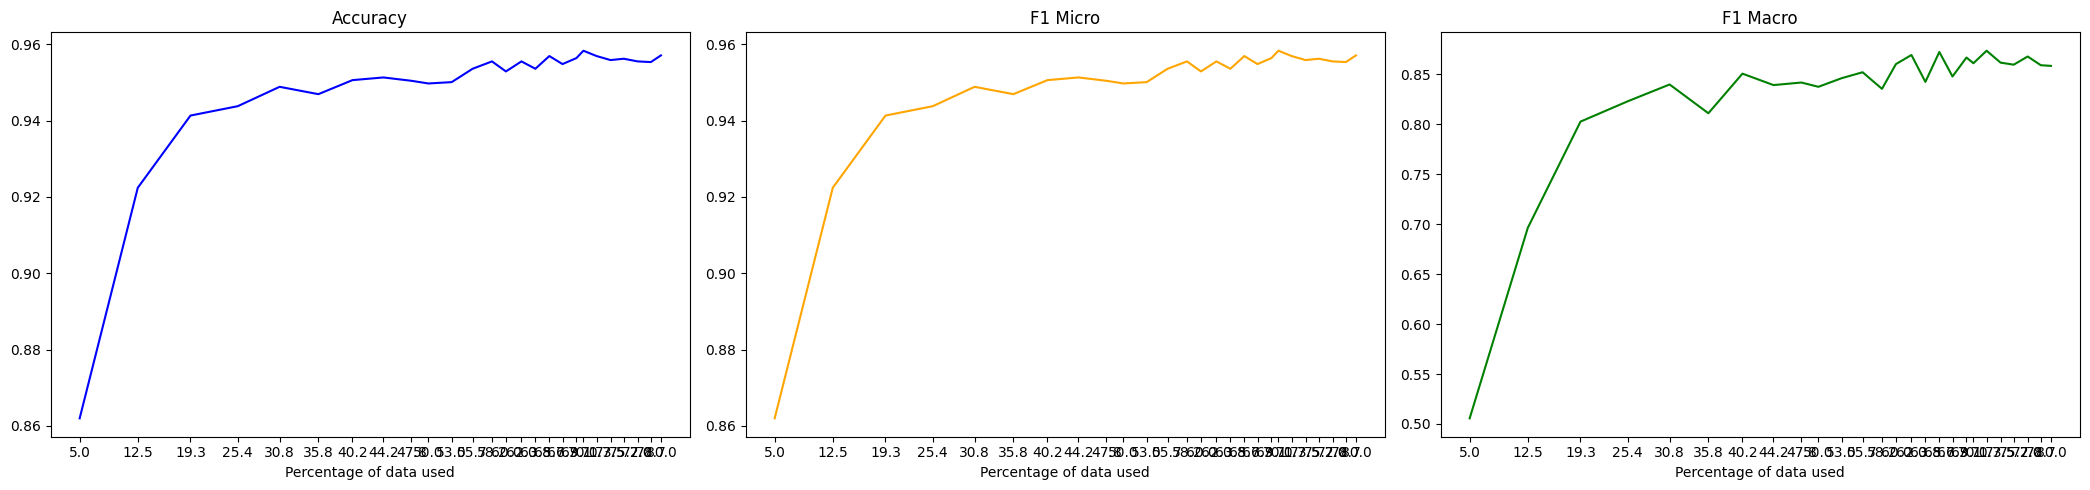

In [28]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.5820891857147217 | ACCURACY: 0.7998 | F1 MACRO: 0.8795 | F1 MICRO: 0.8873
EPOCH 2 | LOSS: 2.345266819000244 | ACCURACY: 0.8014 | F1 MACRO: 0.8843 | F1 MICRO: 0.8892
EPOCH 3 | LOSS: 2.2658588886260986 | ACCURACY: 0.8021 | F1 MACRO: 0.8827 | F1 MICRO: 0.8885
EPOCH 4 | LOSS: 2.213557481765747 | ACCURACY: 0.8092 | F1 MACRO: 0.8799 | F1 MICRO: 0.8902
EPOCH 5 | LOSS: 2.151737689971924 | ACCURACY: 0.8123 | F1 MACRO: 0.8811 | F1 MICRO: 0.8921
EPOCH 6 | LOSS: 2.1129658222198486 | ACCURACY: 0.8196 | F1 MACRO: 0.8889 | F1 MICRO: 0.8966
EPOCH 7 | LOSS: 2.0752482414245605 | ACCURACY: 0.8266 | F1 MACRO: 0.8915 | F1 MICRO: 0.8996
EPOCH 8 | LOSS: 2.084022045135498 | ACCURACY: 0.8363 | F1 MACRO: 0.8957 | F1 MICRO: 0.9045
EPOCH 9 | LOSS: 2.061579704284668 | ACCURACY: 0.8502 | F1 MACRO: 0.9053 | F1 MICRO: 0.9122
EPOCH 10 | LOSS: 2.071838855743408 | ACCURACY: 0.8566 | F1 MACRO: 0.9083 | F1 MICRO: 0.9152
aspect: ACCURACY 0.8566 | F1 MACRO 0.9083 | F1 MICRO 0.9152
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 39.89052200317383 | ACCURACY: 0.765 | F1 MACRO: 0.7555 | F1 MICRO: 0.765
EPOCH 2 | LOSS: 35.35344314575195 | ACCURACY: 0.8141 | F1 MACRO: 0.7887 | F1 MICRO: 0.8141
EPOCH 3 | LOSS: 31.97340965270996 | ACCURACY: 0.8449 | F1 MACRO: 0.8405 | F1 MICRO: 0.8449
EPOCH 4 | LOSS: 29.98813819885254 | ACCURACY: 0.871 | F1 MACRO: 0.8646 | F1 MICRO: 0.871
EPOCH 5 | LOSS: 27.7890625 | ACCURACY: 0.8694 | F1 MACRO: 0.8613 | F1 MICRO: 0.8694
EPOCH 6 | LOSS: 25.7657413482666 | ACCURACY: 0.874 | F1 MACRO: 0.8656 | F1 MICRO: 0.874
EPOCH 7 | LOSS: 24.497404098510742 | ACCURACY: 0.8848 | F1 MACRO: 0.8792 | F1 MICRO: 0.8848
EPOCH 8 | LOSS: 23.146024703979492 | ACCURACY: 0.8817 | F1 MACRO: 0.8763 | F1 MICRO: 0.8817
EPOCH 9 | LOSS: 22.60674476623535 | ACCURACY: 0.8541 | F1 MACRO: 0.8491 | F1 MICRO: 0.8541
EPOCH 10 | LOSS: 22.409378051757812 | ACCURACY: 0.8863 | F1 MACRO: 0.8789 | F1 MICRO: 0.8863
sentiment: ACCURACY 0.8863 | F1 MACRO 0.8789 | F1 MICRO 0.8863
              precision    recall  f1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 142: Accuracy: 0.8552, F1 Micro: 0.8552, F1 Macro: 0.4784
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.93      0.43      0.59        97
     neutral       0.87      0.96      0.91       459
    positive       0.05      0.07      0.06        15

    accuracy                           0.84       571
   macro avg       0.62      0.49      0.52       571
weighted avg       0.86      0.84      0.83       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.80      0.05      0.09        86
     neutral       0.84      1.00      0.91       475
    positive       0.00      0.00      0.00        10

    accuracy                           0.84       571
   macro avg       0.55      0.35      0.33       571
weighted avg       0.82      0.84      0.77       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.082324266433716
Samples above threshold: 215
Acquired samples: 215
Sampling duration: 19.283891201019287 seconds
New train size: 357
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.3005034923553467 | ACCURACY: 0.8009 | F1 MACRO: 0.8846 | F1 MICRO: 0.8892
EPOCH 2 | LOSS: 2.0670344829559326 | ACCURACY: 0.8153 | F1 MACRO: 0.8882 | F1 MICRO: 0.8954
EPOCH 3 | LOSS: 1.9892667531967163 | ACCURACY: 0.8347 | F1 MACRO: 0.9012 | F1 MICRO: 0.9061
EPOCH 4 | LOSS: 1.935109257698059 | ACCURACY: 0.8741 | F1 MACRO: 0.9216 | F1 MICRO: 0.9261
EPOCH 5 | LOSS: 1.8951631784439087 | ACCURACY: 0.8872 | F1 MACRO: 0.9285 | F1 MICRO: 0.9331
EPOCH 6 | LOSS: 1.8593101501464844 | ACCURACY: 0.9016 | F1 MACRO: 0.937 | F1 MICRO: 0.941
EPOCH 7 | LOSS: 1.8045390844345093 | ACCURACY: 0.9085 | F1 MACRO: 0.9414 | F1 MICRO: 0.945
EPOCH 8 | LOSS: 1.8022857904434204 | ACCURACY: 0.913 | F1 MACRO: 0.9442 | F1 MICRO: 0.9477
EPOCH 9 | LOSS: 1.7382164001464844 | ACCURACY: 0.9212 | F1 MACRO: 0.9486 | F1 MICRO: 0.9522
EPOCH 10 | LOSS: 1.6788299083709717 | ACCURACY: 0.9302 | F1 MACRO: 0.9538 | F1 MICRO: 0.9573
aspect: ACCURACY 0.9302 | F1 MACRO 0.9538 | F1 MICRO 0.9573
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 20.669727325439453 | ACCURACY: 0.7998 | F1 MACRO: 0.6837 | F1 MICRO: 0.7998
EPOCH 2 | LOSS: 17.82566261291504 | ACCURACY: 0.8741 | F1 MACRO: 0.836 | F1 MICRO: 0.8741
EPOCH 3 | LOSS: 16.769018173217773 | ACCURACY: 0.8844 | F1 MACRO: 0.847 | F1 MICRO: 0.8844
EPOCH 4 | LOSS: 15.92668342590332 | ACCURACY: 0.8844 | F1 MACRO: 0.8454 | F1 MICRO: 0.8844
EPOCH 5 | LOSS: 15.544577598571777 | ACCURACY: 0.8927 | F1 MACRO: 0.862 | F1 MICRO: 0.8927
EPOCH 6 | LOSS: 14.865219116210938 | ACCURACY: 0.8844 | F1 MACRO: 0.8483 | F1 MICRO: 0.8844
EPOCH 7 | LOSS: 14.231213569641113 | ACCURACY: 0.8958 | F1 MACRO: 0.8654 | F1 MICRO: 0.8958
EPOCH 8 | LOSS: 13.682738304138184 | ACCURACY: 0.8906 | F1 MACRO: 0.8636 | F1 MICRO: 0.8906
EPOCH 9 | LOSS: 13.29903507232666 | ACCURACY: 0.8885 | F1 MACRO: 0.8588 | F1 MICRO: 0.8885
EPOCH 10 | LOSS: 12.847445487976074 | ACCURACY: 0.8824 | F1 MACRO: 0.8439 | F1 MICRO: 0.8824
sentiment: ACCURACY 0.8958 | F1 MACRO 0.8654 | F1 MICRO 0.8958
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 357: Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.7763
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.89      0.92        97
     neutral       0.97      0.99      0.98       459
    positive       0.87      0.87      0.87        15

    accuracy                           0.97       571
   macro avg       0.93      0.91      0.92       571
weighted avg       0.97      0.97      0.97       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.92      0.70      0.79        86
     neutral       0.94      0.99      0.96       475
    positive       0.50      0.30      0.37        10

    accuracy                           0.93       571
   macro avg       0.79      0.66      0.71       571
weighted avg       0.93      0.93      0.93       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 3.0083818435668945
Samples above threshold: 193
Acquired samples: 193
Sampling duration: 28.42501449584961 seconds
New train size: 550
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.1906898021698 | ACCURACY: 0.8057 | F1 MACRO: 0.8867 | F1 MICRO: 0.8915
EPOCH 2 | LOSS: 1.9742863178253174 | ACCURACY: 0.8342 | F1 MACRO: 0.8949 | F1 MICRO: 0.9041
EPOCH 3 | LOSS: 1.9038522243499756 | ACCURACY: 0.8733 | F1 MACRO: 0.9203 | F1 MICRO: 0.9255
EPOCH 4 | LOSS: 1.8477754592895508 | ACCURACY: 0.8948 | F1 MACRO: 0.9316 | F1 MICRO: 0.9369
EPOCH 5 | LOSS: 1.8065495491027832 | ACCURACY: 0.9099 | F1 MACRO: 0.9398 | F1 MICRO: 0.9453
EPOCH 6 | LOSS: 1.7723767757415771 | ACCURACY: 0.9226 | F1 MACRO: 0.9488 | F1 MICRO: 0.9529
EPOCH 7 | LOSS: 1.6980955600738525 | ACCURACY: 0.9325 | F1 MACRO: 0.9558 | F1 MICRO: 0.9589
EPOCH 8 | LOSS: 1.6334325075149536 | ACCURACY: 0.9333 | F1 MACRO: 0.956 | F1 MICRO: 0.9593
EPOCH 9 | LOSS: 1.6007471084594727 | ACCURACY: 0.9352 | F1 MACRO: 0.9567 | F1 MICRO: 0.9604
EPOCH 10 | LOSS: 1.5577399730682373 | ACCURACY: 0.9396 | F1 MACRO: 0.9586 | F1 MICRO: 0.9627
aspect: ACCURACY 0.9396 | F1 MACRO 0.9586 | F1 MICRO 0.9627
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 14.584539413452148 | ACCURACY: 0.8503 | F1 MACRO: 0.8116 | F1 MICRO: 0.8503
EPOCH 2 | LOSS: 12.638587951660156 | ACCURACY: 0.8685 | F1 MACRO: 0.8329 | F1 MICRO: 0.8685
EPOCH 3 | LOSS: 11.750951766967773 | ACCURACY: 0.8791 | F1 MACRO: 0.8504 | F1 MICRO: 0.8791
EPOCH 4 | LOSS: 11.484077453613281 | ACCURACY: 0.8887 | F1 MACRO: 0.8605 | F1 MICRO: 0.8887
EPOCH 5 | LOSS: 11.18602466583252 | ACCURACY: 0.8839 | F1 MACRO: 0.8534 | F1 MICRO: 0.8839
EPOCH 6 | LOSS: 10.897839546203613 | ACCURACY: 0.8858 | F1 MACRO: 0.8603 | F1 MICRO: 0.8858
EPOCH 7 | LOSS: 10.314009666442871 | ACCURACY: 0.8839 | F1 MACRO: 0.8585 | F1 MICRO: 0.8839
EPOCH 8 | LOSS: 9.87376594543457 | ACCURACY: 0.8887 | F1 MACRO: 0.8623 | F1 MICRO: 0.8887
EPOCH 9 | LOSS: 9.478056907653809 | ACCURACY: 0.8992 | F1 MACRO: 0.8768 | F1 MICRO: 0.8992
EPOCH 10 | LOSS: 9.306365013122559 | ACCURACY: 0.8848 | F1 MACRO: 0.8535 | F1 MICRO: 0.8848
sentiment: ACCURACY 0.8992 | F1 MACRO 0.8768 | F1 MICRO 0.8992
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 550: Accuracy: 0.9364, F1 Micro: 0.9364, F1 Macro: 0.7881
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.92      0.94        97
     neutral       0.98      0.99      0.99       459
    positive       0.88      0.93      0.90        15

    accuracy                           0.98       571
   macro avg       0.94      0.95      0.94       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.83      0.86        86
     neutral       0.97      0.99      0.98       475
    positive       0.50      0.30      0.37        10

    accuracy                           0.95       571
   macro avg       0.78      0.70      0.74       571
weighted avg       0.95      0.95      0.95       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9956113815307592
Samples above threshold: 174
Acquired samples: 174
Sampling duration: 33.442434310913086 seconds
New train size: 724
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.110280990600586 | ACCURACY: 0.8108 | F1 MACRO: 0.8828 | F1 MICRO: 0.8924
EPOCH 2 | LOSS: 1.8878240585327148 | ACCURACY: 0.851 | F1 MACRO: 0.9094 | F1 MICRO: 0.9143
EPOCH 3 | LOSS: 1.8326261043548584 | ACCURACY: 0.8991 | F1 MACRO: 0.9354 | F1 MICRO: 0.9396
EPOCH 4 | LOSS: 1.7638503313064575 | ACCURACY: 0.9161 | F1 MACRO: 0.9452 | F1 MICRO: 0.949
EPOCH 5 | LOSS: 1.6953625679016113 | ACCURACY: 0.9323 | F1 MACRO: 0.9553 | F1 MICRO: 0.9585
EPOCH 6 | LOSS: 1.6303396224975586 | ACCURACY: 0.9342 | F1 MACRO: 0.9566 | F1 MICRO: 0.9599
EPOCH 7 | LOSS: 1.595745325088501 | ACCURACY: 0.9361 | F1 MACRO: 0.9574 | F1 MICRO: 0.9609
EPOCH 8 | LOSS: 1.5352778434753418 | ACCURACY: 0.9408 | F1 MACRO

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 11.427600860595703 | ACCURACY: 0.8497 | F1 MACRO: 0.8059 | F1 MICRO: 0.8497
EPOCH 2 | LOSS: 9.889913558959961 | ACCURACY: 0.8611 | F1 MACRO: 0.8223 | F1 MICRO: 0.8611
EPOCH 3 | LOSS: 9.179757118225098 | ACCURACY: 0.8801 | F1 MACRO: 0.843 | F1 MICRO: 0.8801
EPOCH 4 | LOSS: 8.870809555053711 | ACCURACY: 0.8991 | F1 MACRO: 0.8741 | F1 MICRO: 0.8991
EPOCH 5 | LOSS: 8.36623477935791 | ACCURACY: 0.8877 | F1 MACRO: 0.8663 | F1 MICRO: 0.8877
EPOCH 6 | LOSS: 8.295929908752441 | ACCURACY: 0.8896 | F1 MACRO: 0.8681 | F1 MICRO: 0.8896
EPOCH 7 | LOSS: 7.903655529022217 | ACCURACY: 0.8896 | F1 MACRO: 0.8639 | F1 MICRO: 0.8896
EPOCH 8 | LOSS: 7.611546516418457 | ACCURACY: 0.8982 | F1 MACRO: 0.8761 | F1 MICRO: 0.8982
EPOCH 9 | LOSS: 7.245011329650879 | ACCURACY: 0.8906 | F1 MACRO: 0.8655 | F1 MICRO: 0.8906
EPOCH 10 | LOSS: 7.2471394538879395 | ACCURACY: 0.8953 | F1 MACRO: 0.8732 | F1 MICRO: 0.8953
sentiment: ACCURACY 0.8991 | F1 MACRO 0.8741 | F1 MICRO 0.8991
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 724: Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.8222
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.81      0.86        86
     neutral       0.97      0.99      0.98       475
    positive       0.33      0.20      0.25        10

    accuracy                           0.95       571
   macro avg       0.74      0.67      0.70       571
weighted avg       0.95      0.95      0.95       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.1106209754943848 | ACCURACY: 0.817 | F1 MACRO: 0.8861 | F1 MICRO: 0.8956
EPOCH 2 | LOSS: 1.8791272640228271 | ACCURACY: 0.8844 | F1 MACRO: 0.9263 | F1 MICRO: 0.9312
EPOCH 3 | LOSS: 1.8073363304138184 | ACCURACY: 0.9163 | F1 MACRO: 0.9451 | F1 MICRO: 0.9493
EPOCH 4 | LOSS: 1.786698341369629 | ACCURACY: 0.9306 | F1 MACRO: 0.9543 | F1 MICRO: 0.9575
EPOCH 5 | LOSS: 1.6789469718933105 | ACCURACY: 0.9377 | F1 MACRO: 0.958 | F1 MICRO: 0.9618
EPOCH 6 | LOSS: 1.6269786357879639 | ACCURACY: 0.9438 | F1 MACRO: 0.9623 | F1 MICRO: 0.9655
EPOCH 7 | LOSS: 1.5753284692764282 | ACCURACY: 0.9484 | F1 MACRO: 0.9656 | F1 MICRO: 0.9683
EPOCH 8 | LOSS: 1.5370947122573853 | ACCURACY: 0.947 | F1 MACRO: 0.9641 | F1 MICRO: 0.9673
EPOCH 9 | LOSS: 1.484448790550232 | ACCURACY: 0.945 | F1 MACRO: 0.9631 | F1 MICRO: 0.9663
EPOCH 10 | LOSS: 1.4610041379928589 | ACCURACY: 0.9484 | F1 MACRO: 0.9645 | F1 MICRO: 0.9681
aspect: ACCURACY 0.9484 | F1 MACRO 0.9656 | F1 MICRO 0.9683
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 9.398065567016602 | ACCURACY: 0.8315 | F1 MACRO: 0.7566 | F1 MICRO: 0.8315
EPOCH 2 | LOSS: 8.134302139282227 | ACCURACY: 0.8812 | F1 MACRO: 0.8437 | F1 MICRO: 0.8812
EPOCH 3 | LOSS: 7.586794853210449 | ACCURACY: 0.8851 | F1 MACRO: 0.8457 | F1 MICRO: 0.8851
EPOCH 4 | LOSS: 7.185915470123291 | ACCURACY: 0.89 | F1 MACRO: 0.8561 | F1 MICRO: 0.89
EPOCH 5 | LOSS: 6.950759410858154 | ACCURACY: 0.8978 | F1 MACRO: 0.8646 | F1 MICRO: 0.8978
EPOCH 6 | LOSS: 6.668793678283691 | ACCURACY: 0.889 | F1 MACRO: 0.8594 | F1 MICRO: 0.889
EPOCH 7 | LOSS: 6.558876991271973 | ACCURACY: 0.8783 | F1 MACRO: 0.8464 | F1 MICRO: 0.8783
EPOCH 8 | LOSS: 6.302846431732178 | ACCURACY: 0.8909 | F1 MACRO: 0.8631 | F1 MICRO: 0.8909
EPOCH 9 | LOSS: 6.091414928436279 | ACCURACY: 0.8802 | F1 MACRO: 0.846 | F1 MICRO: 0.8802
EPOCH 10 | LOSS: 5.8592610359191895 | ACCURACY: 0.8929 | F1 MACRO: 0.8605 | F1 MICRO: 0.8929
sentiment: ACCURACY 0.8978 | F1 MACRO 0.8646 | F1 MICRO 0.8978
              precision    recal

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9183732986450197
Samples above threshold: 141
Acquired samples: 141
Sampling duration: 44.475958585739136 seconds
New train size: 1021
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.048884153366089 | ACCURACY: 0.8191 | F1 MACRO: 0.8929 | F1 MICRO: 0.8981
EPOCH 2 | LOSS: 1.8468775749206543 | ACCURACY: 0.8908 | F1 MACRO: 0.931 | F1 MICRO: 0.9351
EPOCH 3 | LOSS: 1.7650282382965088 | ACCURACY: 0.9259 | F1 MACRO: 0.952 | F1 MICRO: 0.955
EPOCH 4 | LOSS: 1.6958807706832886 | ACCURACY: 0.9359 | F1 MACRO: 0.9575 | F1 MICRO: 0.9608
EPOCH 5 | LOSS: 1.6246057748794556 | ACCURACY: 0.9398 | F1 MACRO: 0.9598 | F1 MICRO: 0.9632
EPOCH 6 | LOSS: 1.5528498888015747 | ACCURACY: 0.9507 | F1 MACRO: 0.9664 | F1 MICRO: 0.9695
EPOCH 7 | LOSS: 1.5213106870651245 | ACCURACY: 0.9474 | F1 MACRO: 0.9644 | F1 MICRO: 0.9675
EPOCH 8 | LOSS: 1.47087562084198 | ACCURACY: 0.9509 | F1 MACRO:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1021: Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.8366
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.98      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.92      0.84      0.88        86
     neutral       0.97      0.99      0.98       475
    positive       0.50      0.40      0.44        10

    accuracy                           0.96       571
   macro avg       0.80      0.74      0.77       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9223124504089357
Samples above threshold: 127
Acquired samples: 127
Sampling duration: 48.58732342720032 seconds
New train size: 1148
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0346736907958984 | ACCURACY: 0.8253 | F1 MACRO: 0.8969 | F1 MICRO: 0.9015
EPOCH 2 | LOSS: 1.8207467794418335 | ACCURACY: 0.903 | F1 MACRO: 0.938 | F1 MICRO: 0.942
EPOCH 3 | LOSS: 1.7428714036941528 | ACCURACY: 0.9269 | F1 MACRO: 0.953 | F1 MICRO: 0.9557
EPOCH 4 | LOSS: 1.6514644622802734 | ACCURACY: 0.9424 | F1 MACRO: 0.9616 | F1 MICRO: 0.9645
EPOCH 5 | LOSS: 1.5751228332519531 | ACCURACY: 0.9479 | F1 MACRO: 0.965 | F1 MICRO: 0.968
EPOCH 6 | LOSS: 1.532508134841919 | ACCURACY: 0.9486 | F1 MACRO: 0.9652 | F1 MICRO: 0.9682
EPOCH 7 | LOSS: 1.4733167886734009 | ACCURACY: 0.9519 | F1 MACRO: 0.9673 | F1 MICRO: 0.9704
EPOCH 8 | LOSS: 1.4543907642364502 | ACCURACY: 0.9516 | F1 MACRO: 0.9669 | F1 MICRO: 0.9701
EPOCH 9 | LOSS: 1.412253737449646 | ACCURACY: 0.9535 | F1 MACRO: 0.9686 | F1 MICRO: 0.9713
EPOCH 10 | LOSS: 1.3761768341064453 | ACCURACY: 0.9543 | F1 MACRO: 0.969 | F1 MICRO: 0.9718
aspect: ACCURACY 0.9543 | F1 MACRO 0.969 | F1 MICRO 0.9718
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 7.260853290557861 | ACCURACY: 0.848 | F1 MACRO: 0.8094 | F1 MICRO: 0.848
EPOCH 2 | LOSS: 6.158451080322266 | ACCURACY: 0.8724 | F1 MACRO: 0.8368 | F1 MICRO: 0.8724
EPOCH 3 | LOSS: 5.899755954742432 | ACCURACY: 0.8987 | F1 MACRO: 0.8718 | F1 MICRO: 0.8987
EPOCH 4 | LOSS: 5.66079568862915 | ACCURACY: 0.8959 | F1 MACRO: 0.8654 | F1 MICRO: 0.8959
EPOCH 5 | LOSS: 5.402370452880859 | ACCURACY: 0.894 | F1 MACRO: 0.866 | F1 MICRO: 0.894
EPOCH 6 | LOSS: 5.208140850067139 | ACCURACY: 0.9006 | F1 MACRO: 0.8725 | F1 MICRO: 0.9006
EPOCH 7 | LOSS: 5.066710948944092 | ACCURACY: 0.8921 | F1 MACRO: 0.864 | F1 MICRO: 0.8921
EPOCH 8 | LOSS: 4.925508499145508 | ACCURACY: 0.9015 | F1 MACRO: 0.8744 | F1 MICRO: 0.9015
EPOCH 9 | LOSS: 4.69759464263916 | ACCURACY: 0.894 | F1 MACRO: 0.866 | F1 MICRO: 0.894
EPOCH 10 | LOSS: 4.652849197387695 | ACCURACY: 0.8959 | F1 MACRO: 0.8619 | F1 MICRO: 0.8959
sentiment: ACCURACY 0.9015 | F1 MACRO 0.8744 | F1 MICRO 0.9015
              precision    recall  f1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1148: Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.8437
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.89        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.87      0.79      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9077821731567384
Samples above threshold: 114
Acquired samples: 114
Sampling duration: 50.99547338485718 seconds
New train size: 1262
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0430948734283447 | ACCURACY: 0.8503 | F1 MACRO: 0.9064 | F1 MICRO: 0.9125
EPOCH 2 | LOSS: 1.8555607795715332 | ACCURACY: 0.9184 | F1 MACRO: 0.9472 | F1 MICRO: 0.9507
EPOCH 3 | LOSS: 1.759100079536438 | ACCURACY: 0.9339 | F1 MACRO: 0.9566 | F1 MICRO: 0.9597
EPOCH 4 | LOSS: 1.6526367664337158 | ACCURACY: 0.9401 | F1 MACRO: 0.9595 | F1 MICRO: 0.9632
EPOCH 5 | LOSS: 1.5958937406539917 | ACCURACY: 0.9481 | F1 MACRO: 0.9651 | F1 MICRO: 0.9681
EPOCH 6 | LOSS: 1.53401517868042 | ACCURACY: 0.9495 | F1 MACRO: 0.9661 | F1 MICRO: 0.969
EPOCH 7 | LOSS: 1.4928852319717407 | ACCURACY: 0.9455 | F1 MACRO: 0.964 | F1 MICRO: 0.9665
EPOCH 8 | LOSS: 1.4417937994003296 | ACCURACY: 0.9538 | F1 MACRO: 0.9686 | F1 MICRO: 0.9715
EPOCH 9 | LOSS: 1.4144500494003296 | ACCURACY: 0.9554 | F1 MACRO: 0.9697 | F1 MICRO: 0.9724
EPOCH 10 | LOSS: 1.3904235363006592 | ACCURACY: 0.9517 | F1 MACRO: 0.9677 | F1 MICRO: 0.9703
aspect: ACCURACY 0.9554 | F1 MACRO 0.9697 | F1 MICRO 0.9724
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 6.432621002197266 | ACCURACY: 0.8299 | F1 MACRO: 0.7557 | F1 MICRO: 0.8299
EPOCH 2 | LOSS: 5.582277774810791 | ACCURACY: 0.8652 | F1 MACRO: 0.8169 | F1 MICRO: 0.8652
EPOCH 3 | LOSS: 5.238722801208496 | ACCURACY: 0.8885 | F1 MACRO: 0.859 | F1 MICRO: 0.8885
EPOCH 4 | LOSS: 5.031440734863281 | ACCURACY: 0.8875 | F1 MACRO: 0.8535 | F1 MICRO: 0.8875
EPOCH 5 | LOSS: 4.856542587280273 | ACCURACY: 0.8913 | F1 MACRO: 0.8615 | F1 MICRO: 0.8913
EPOCH 6 | LOSS: 4.789237022399902 | ACCURACY: 0.8764 | F1 MACRO: 0.8358 | F1 MICRO: 0.8764
EPOCH 7 | LOSS: 4.514093399047852 | ACCURACY: 0.8913 | F1 MACRO: 0.8593 | F1 MICRO: 0.8913
EPOCH 8 | LOSS: 4.376348495483398 | ACCURACY: 0.8959 | F1 MACRO: 0.8678 | F1 MICRO: 0.8959
EPOCH 9 | LOSS: 4.308900833129883 | ACCURACY: 0.8931 | F1 MACRO: 0.8667 | F1 MICRO: 0.8931
EPOCH 10 | LOSS: 4.120083808898926 | ACCURACY: 0.8968 | F1 MACRO: 0.8683 | F1 MICRO: 0.8968
sentiment: ACCURACY 0.8968 | F1 MACRO 0.8683 | F1 MICRO 0.8968
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1262: Accuracy: 0.9501, F1 Micro: 0.9501, F1 Macro: 0.8271
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.85      0.88        86
     neutral       0.98      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.84      0.78      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.9007205963134766
Samples above threshold: 103
Acquired samples: 103
Sampling duration: 51.26254844665527 seconds
New train size: 1365
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0202476978302 | ACCURACY: 0.8571 | F1 MACRO: 0.9121 | F1 MICRO: 0.9169
EPOCH 2 | LOSS: 1.8191288709640503 | ACCURACY: 0.9186 | F1 MACRO: 0.9468 | F1 MICRO: 0.9505
EPOCH 3 | LOSS: 1.702271580696106 | ACCURACY: 0.9335 | F1 MACRO: 0.9564 | F1 MICRO: 0.9595
EPOCH 4 | LOSS: 1.6288166046142578 | ACCURACY: 0.9448 | F1 MACRO: 0.9626 | F1 MICRO: 0.966
EPOCH 5 | LOSS: 1.5543968677520752 | ACCURACY: 0.9512 | F1 MACRO: 0.9676 | F1 MICRO: 0.9701
EPOCH 6 | LOSS: 1.5077216625213623 | ACCURACY: 0.9519 | F1 MACRO: 0.9671 | F1 MICRO: 0.9702
EPOCH 7 | LOSS: 1.4617024660110474 | ACCURACY: 0.9523 | F1 MACRO: 0.9674 | F1 MICRO: 0.9705
EPOCH 8 | LOSS: 1.4171538352966309 | ACCURACY: 0.9495 | F1 MACRO: 0.966 | F1 MICRO: 0.9689
EPOCH 9 | LOSS: 1.3795815706253052 | ACCURACY: 0.9564 | F1 MACRO: 0.9702 | F1 MICRO: 0.9731
EPOCH 10 | LOSS: 1.3557019233703613 | ACCURACY: 0.9547 | F1 MACRO: 0.969 | F1 MICRO: 0.972
aspect: ACCURACY 0.9564 | F1 MACRO 0.9702 | F1 MICRO 0.9731
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1365: Accuracy: 0.9497, F1 Micro: 0.9497, F1 Macro: 0.8406
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.95      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.89      0.86      0.88        86
     neutral       0.98      0.99      0.98       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.86      0.78      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1427
Threshold: 2.914831280708313
Samples above threshold: 92
Acquired samples: 62
Sampling duration: 53.69892883300781 seconds
New train size: 1427
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9951750040054321 | ACCURACY: 0.8589 | F1 MACRO: 0.9131 | F1 MICRO: 0.918
EPOCH 2 | LOSS: 1.8030022382736206 | ACCURACY: 0.9222 | F1 MACRO: 0.948 | F1 MICRO: 0.9525
EPOCH 3 | LOSS: 1.7135411500930786 | ACCURACY: 0.9411 | F1 MACRO: 0.961 | F1 MICRO: 0.9639
EPOCH 4 | LOSS: 1.6193333864212036 | ACCURACY: 0.9469 | F1 MACRO: 0.9643 | F1 MICRO: 0.9672
EPOCH 5 | LOSS: 1.5468465089797974 | ACCURACY: 0.949 | F1 MACRO: 0.9655 | F1 MICRO: 0.9685
EPOCH 6 | LOSS: 1.500943660736084 | ACCURACY: 0.954 | F1 MACRO: 0.9682 | F1 MICRO: 0.9715
EPOCH 7 | LOSS: 1.4481124877929688 | ACCURACY: 0.9526 | F1 MACRO: 0.9676 | F1 MICRO: 0.9707
EPOCH 8 | LOSS: 1.4056894779205322 | ACCURACY: 0.9524 | F1 MACRO: 0.9676 | F1 MICRO: 0.9706
EPOCH 9 | LOSS: 1.3768588304519653 | ACCURACY: 0.9545 | F1 MACRO: 0.9689 | F1 MICRO: 0.9718
EPOCH 10 | LOSS: 1.3430567979812622 | ACCURACY: 0.9561 | F1 MACRO: 0.9702 | F1 MICRO: 0.9729
aspect: ACCURACY 0.9561 | F1 MACRO 0.9702 | F1 MICRO 0.9729
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.971632957458496 | ACCURACY: 0.8202 | F1 MACRO: 0.7285 | F1 MICRO: 0.8202
EPOCH 2 | LOSS: 5.008134365081787 | ACCURACY: 0.8879 | F1 MACRO: 0.8575 | F1 MICRO: 0.8879
EPOCH 3 | LOSS: 4.6270551681518555 | ACCURACY: 0.8889 | F1 MACRO: 0.8524 | F1 MICRO: 0.8889
EPOCH 4 | LOSS: 4.543849945068359 | ACCURACY: 0.903 | F1 MACRO: 0.8744 | F1 MICRO: 0.903
EPOCH 5 | LOSS: 4.248154640197754 | ACCURACY: 0.8974 | F1 MACRO: 0.8655 | F1 MICRO: 0.8974
EPOCH 6 | LOSS: 4.191271781921387 | ACCURACY: 0.9021 | F1 MACRO: 0.8767 | F1 MICRO: 0.9021
EPOCH 7 | LOSS: 4.063937664031982 | ACCURACY: 0.8945 | F1 MACRO: 0.8639 | F1 MICRO: 0.8945
EPOCH 8 | LOSS: 3.9913864135742188 | ACCURACY: 0.9002 | F1 MACRO: 0.8703 | F1 MICRO: 0.9002
EPOCH 9 | LOSS: 3.7823646068573 | ACCURACY: 0.8945 | F1 MACRO: 0.8616 | F1 MICRO: 0.8945
EPOCH 10 | LOSS: 3.8262367248535156 | ACCURACY: 0.9049 | F1 MACRO: 0.8782 | F1 MICRO: 0.9049
sentiment: ACCURACY 0.9049 | F1 MACRO 0.8782 | F1 MICRO 0.9049
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1427: Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.8537
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.95      0.94      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.86      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.67      0.40      0.50        10

    accuracy                           0.96       571
   macro avg       0.85      0.75      0.79       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.9117867946624756
Samples above threshold: 86
Acquired samples: 86
Sampling duration: 55.76661038398743 seconds
New train size: 1513
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 2.0255661010742188 | ACCURACY: 0.8689 | F1 MACRO: 0.9182 | F1 MICRO: 0.9233
EPOCH 2 | LOSS: 1.8201037645339966 | ACCURACY: 0.9245 | F1 MACRO: 0.9507 | F1 MICRO: 0.9541
EPOCH 3 | LOSS: 1.6967484951019287 | ACCURACY: 0.9394 | F1 MACRO: 0.9603 | F1 MICRO: 0.963
EPOCH 4 | LOSS: 1.6170591115951538 | ACCURACY: 0.949 | F1 MACRO: 0.9653 | F1 MICRO: 0.9684
EPOCH 5 | LOSS: 1.548599123954773 | ACCURACY: 0.9528 | F1 MACRO: 0.9679 | F1 MICRO: 0.9709
EPOCH 6 | LOSS: 1.5028245449066162 | ACCURACY: 0.9533 | F1 MACRO: 0.9683 | F1 MICRO: 0.9711
EPOCH 7 | LOSS: 1.4633855819702148 | ACCURACY: 0.9533 | F1 MACRO: 0.9677 | F1 MICRO: 0.971
EPOCH 8 | LOSS: 1.4150826930999756 | ACCURACY: 0.958 | F1 MACRO: 0.9713 | F1 MICRO: 0.974
EPOCH 9 | LOSS: 1.3756295442581177 | ACCURACY: 0.9545 | F1 MACRO: 0.9691 | F1 MICRO: 0.9718
EPOCH 10 | LOSS: 1.355035662651062 | ACCURACY: 0.9566 | F1 MACRO: 0.9703 | F1 MICRO: 0.9731
aspect: ACCURACY 0.958 | F1 MACRO 0.9713 | F1 MICRO 0.974
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.534363746643066 | ACCURACY: 0.8561 | F1 MACRO: 0.8054 | F1 MICRO: 0.8561
EPOCH 2 | LOSS: 4.683384418487549 | ACCURACY: 0.871 | F1 MACRO: 0.827 | F1 MICRO: 0.871
EPOCH 3 | LOSS: 4.3790764808654785 | ACCURACY: 0.8963 | F1 MACRO: 0.8694 | F1 MICRO: 0.8963
EPOCH 4 | LOSS: 4.233485221862793 | ACCURACY: 0.8804 | F1 MACRO: 0.8395 | F1 MICRO: 0.8804
EPOCH 5 | LOSS: 3.967177629470825 | ACCURACY: 0.8963 | F1 MACRO: 0.8721 | F1 MICRO: 0.8963
EPOCH 6 | LOSS: 3.9212770462036133 | ACCURACY: 0.9056 | F1 MACRO: 0.8809 | F1 MICRO: 0.9056
EPOCH 7 | LOSS: 3.7547214031219482 | ACCURACY: 0.9028 | F1 MACRO: 0.8754 | F1 MICRO: 0.9028
EPOCH 8 | LOSS: 3.5843517780303955 | ACCURACY: 0.8981 | F1 MACRO: 0.8704 | F1 MICRO: 0.8981
EPOCH 9 | LOSS: 3.6056618690490723 | ACCURACY: 0.9019 | F1 MACRO: 0.8757 | F1 MICRO: 0.9019
EPOCH 10 | LOSS: 3.514766216278076 | ACCURACY: 0.8953 | F1 MACRO: 0.8676 | F1 MICRO: 0.8953
sentiment: ACCURACY 0.9056 | F1 MACRO 0.8809 | F1 MICRO 0.9056
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.8875630378723143
Samples above threshold: 77
Acquired samples: 77
Sampling duration: 57.73190450668335 seconds
New train size: 1590
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9906437397003174 | ACCURACY: 0.8799 | F1 MACRO: 0.9232 | F1 MICRO: 0.9286
EPOCH 2 | LOSS: 1.8038593530654907 | ACCURACY: 0.9285 | F1 MACRO: 0.9529 | F1 MICRO: 0.9564
EPOCH 3 | LOSS: 1.6790436506271362 | ACCURACY: 0.942 | F1 MACRO: 0.96 | F1 MICRO: 0.9641
EPOCH 4 | LOSS: 1.6010006666183472 | ACCURACY: 0.9484 | F1 MACRO: 0.9646 | F1 MICRO: 0.968
EPOCH 5 | LOSS: 1.5256290435791016 | ACCURACY: 0.9479 | F1 MACRO: 0.9646 | F1 MICRO: 0.9679
EPOCH 6 | LOSS: 1.4698115587234497 | ACCURACY: 0.95 | F1 MACRO: 0.9666 | F1 MICRO: 0.9693
EPOCH 7 | LOSS: 1.435471773147583 | ACCURACY: 0.9545 | F1 MACRO: 0.9684 | F1 MICRO: 0.9718
EPOCH 8 | LOSS: 1.3933509588241577 | ACCURACY: 0.955 | F1 MACRO: 0.9694 | F1 MICRO: 0.9722
EPOCH 9 | LOSS: 1.3662912845611572 | ACCURACY: 0.9536 | F1 MACRO: 0.9683 | F1 MICRO: 0.9713
EPOCH 10 | LOSS: 1.3393332958221436 | ACCURACY: 0.9554 | F1 MACRO: 0.9698 | F1 MICRO: 0.9724
aspect: ACCURACY 0.9554 | F1 MACRO 0.9698 | F1 MICRO 0.9724
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.291112422943115 | ACCURACY: 0.8474 | F1 MACRO: 0.812 | F1 MICRO: 0.8474
EPOCH 2 | LOSS: 4.408501625061035 | ACCURACY: 0.8577 | F1 MACRO: 0.802 | F1 MICRO: 0.8577
EPOCH 3 | LOSS: 4.0905585289001465 | ACCURACY: 0.8856 | F1 MACRO: 0.8473 | F1 MICRO: 0.8856
EPOCH 4 | LOSS: 4.1387248039245605 | ACCURACY: 0.8874 | F1 MACRO: 0.8557 | F1 MICRO: 0.8874
EPOCH 5 | LOSS: 3.8079545497894287 | ACCURACY: 0.9014 | F1 MACRO: 0.8735 | F1 MICRO: 0.9014
EPOCH 6 | LOSS: 3.7542762756347656 | ACCURACY: 0.894 | F1 MACRO: 0.8607 | F1 MICRO: 0.894
EPOCH 7 | LOSS: 3.600132942199707 | ACCURACY: 0.9042 | F1 MACRO: 0.8772 | F1 MICRO: 0.9042
EPOCH 8 | LOSS: 3.565906047821045 | ACCURACY: 0.8958 | F1 MACRO: 0.8666 | F1 MICRO: 0.8958
EPOCH 9 | LOSS: 3.546703338623047 | ACCURACY: 0.8986 | F1 MACRO: 0.8695 | F1 MICRO: 0.8986
EPOCH 10 | LOSS: 3.414124011993408 | ACCURACY: 0.9023 | F1 MACRO: 0.8731 | F1 MICRO: 0.9023
sentiment: ACCURACY 0.9042 | F1 MACRO 0.8772 | F1 MICRO 0.9042
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1590: Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.845
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.85      0.89        86
     neutral       0.98      1.00      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.85      0.78      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1712
Threshold: 2.9065124034881595
Samples above threshold: 70
Acquired samples: 70
Sampling duration: 59.749497413635254 seconds
New train size: 1660
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9843049049377441 | ACCURACY: 0.8835 | F1 MACRO: 0.9253 | F1 MICRO: 0.9304
EPOCH 2 | LOSS: 1.7878462076187134 | ACCURACY: 0.9302 | F1 MACRO: 0.9549 | F1 MICRO: 0.9577
EPOCH 3 | LOSS: 1.6661068201065063 | ACCURACY: 0.9373 | F1 MACRO: 0.9584 | F1 MICRO: 0.9617
EPOCH 4 | LOSS: 1.5923171043395996 | ACCURACY: 0.9502 | F1 MACRO: 0.9659 | F1 MICRO: 0.9691
EPOCH 5 | LOSS: 1.5308772325515747 | ACCURACY: 0.9547 | F1 MACRO: 0.9689 | F1 MICRO: 0.972
EPOCH 6 | LOSS: 1.4831973314285278 | ACCURACY: 0.9519 | F1 MACRO: 0.9673 | F1 MICRO: 0.9703
EPOCH 7 | LOSS: 1.4281821250915527 | ACCURACY: 0.9543 | F1 MACRO: 0.9693 | F1 MICRO: 0.9718
EPOCH 8 | LOSS: 1.3978593349456787 | ACCURACY: 0.9561 | F1 MAC

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 5.056095600128174 | ACCURACY: 0.8623 | F1 MACRO: 0.8287 | F1 MICRO: 0.8623
EPOCH 2 | LOSS: 4.335872173309326 | ACCURACY: 0.8835 | F1 MACRO: 0.8482 | F1 MICRO: 0.8835
EPOCH 3 | LOSS: 4.080228328704834 | ACCURACY: 0.8946 | F1 MACRO: 0.8677 | F1 MICRO: 0.8946
EPOCH 4 | LOSS: 3.8549413681030273 | ACCURACY: 0.8919 | F1 MACRO: 0.8652 | F1 MICRO: 0.8919
EPOCH 5 | LOSS: 3.724867820739746 | ACCURACY: 0.8928 | F1 MACRO: 0.8654 | F1 MICRO: 0.8928
EPOCH 6 | LOSS: 3.644596576690674 | ACCURACY: 0.8974 | F1 MACRO: 0.8668 | F1 MICRO: 0.8974
EPOCH 7 | LOSS: 3.4432194232940674 | ACCURACY: 0.8974 | F1 MACRO: 0.8658 | F1 MICRO: 0.8974
EPOCH 8 | LOSS: 3.350285530090332 | ACCURACY: 0.903 | F1 MACRO: 0.8745 | F1 MICRO: 0.903
EPOCH 9 | LOSS: 3.297886848449707 | ACCURACY: 0.8946 | F1 MACRO: 0.8639 | F1 MICRO: 0.8946
EPOCH 10 | LOSS: 3.1970884799957275 | ACCURACY: 0.9011 | F1 MACRO: 0.8747 | F1 MICRO: 0.9011
sentiment: ACCURACY 0.903 | F1 MACRO 0.8745 | F1 MICRO 0.903
              precision    

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1660: Accuracy: 0.9536, F1 Micro: 0.9536, F1 Macro: 0.8592
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.85      0.89        86
     neutral       0.98      1.00      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.96       571
   macro avg       0.85      0.78      0.81       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.911453723907471 | ACCURACY: 0.8467 | F1 MACRO: 0.7848 | F1 MICRO: 0.8467
EPOCH 2 | LOSS: 4.103072166442871 | ACCURACY: 0.8843 | F1 MACRO: 0.8493 | F1 MICRO: 0.8843
EPOCH 3 | LOSS: 3.8470396995544434 | ACCURACY: 0.8843 | F1 MACRO: 0.8464 | F1 MICRO: 0.8843
EPOCH 4 | LOSS: 3.661078453063965 | ACCURACY: 0.8975 | F1 MACRO: 0.8698 | F1 MICRO: 0.8975
EPOCH 5 | LOSS: 3.483297348022461 | ACCURACY: 0.8928 | F1 MACRO: 0.8643 | F1 MICRO: 0.8928
EPOCH 6 | LOSS: 3.4318437576293945 | ACCURACY: 0.8984 | F1 MACRO: 0.8714 | F1 MICRO: 0.8984
EPOCH 7 | LOSS: 3.3435707092285156 | ACCURACY: 0.9022 | F1 MACRO: 0.8731 | F1 MICRO: 0.9022
EPOCH 8 | LOSS: 3.2464215755462646 | ACCURACY: 0.8956 | F1 MACRO: 0.871 | F1 MICRO: 0.8956
EPOCH 9 | LOSS: 3.1812288761138916 | ACCURACY: 0.9022 | F1 MACRO: 0.8734 | F1 MICRO: 0.9022
EPOCH 10 | LOSS: 3.113553047180176 | ACCURACY: 0.8993 | F1 MACRO: 0.8751 | F1 MICRO: 0.8993
sentiment: ACCURACY 0.9022 | F1 MACRO 0.8734 | F1 MICRO 0.9022
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1712: Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.8551
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.97      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.85      0.87        86
     neutral       0.98      0.99      0.98       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.86      0.78      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.909761905670166
Samples above threshold: 58
Acquired samples: 58
Sampling duration: 63.36662793159485 seconds
New train size: 1770
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9825676679611206 | ACCURACY: 0.8887 | F1 MACRO: 0.9297 | F1 MICRO: 0.9341
EPOCH 2 | LOSS: 1.7804245948791504 | ACCURACY: 0.934 | F1 MACRO: 0.9574 | F1 MICRO: 0.9598
EPOCH 3 | LOSS: 1.6650187969207764 | ACCURACY: 0.9413 | F1 MACRO: 0.9612 | F1 MICRO: 0.964
EPOCH 4 | LOSS: 1.591566562652588 | ACCURACY: 0.9502 | F1 MACRO: 0.9661 | F1 MICRO: 0.9693
EPOCH 5 | LOSS: 1.5217033624649048 | ACCURACY: 0.9516 | F1 MACRO: 0.9668 | F1 MICRO: 0.97
EPOCH 6 | LOSS: 1.474522590637207 | ACCURACY: 0.9523 | F1 MACRO: 0.9675 | F1 MICRO: 0.9704
EPOCH 7 | LOSS: 1.4296058416366577 | ACCURACY: 0.9531 | F1 MACRO: 0.9684 | F1 MICRO: 0.9711
EPOCH 8 | LOSS: 1.388491153717041 | ACCURACY: 0.9566 | F1 MACRO: 0.97

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.731274604797363 | ACCURACY: 0.8579 | F1 MACRO: 0.8195 | F1 MICRO: 0.8579
EPOCH 2 | LOSS: 3.9245426654815674 | ACCURACY: 0.8897 | F1 MACRO: 0.8592 | F1 MICRO: 0.8897
EPOCH 3 | LOSS: 3.6953647136688232 | ACCURACY: 0.8888 | F1 MACRO: 0.86 | F1 MICRO: 0.8888
EPOCH 4 | LOSS: 3.5484583377838135 | ACCURACY: 0.8935 | F1 MACRO: 0.8615 | F1 MICRO: 0.8935
EPOCH 5 | LOSS: 3.401737689971924 | ACCURACY: 0.9065 | F1 MACRO: 0.8791 | F1 MICRO: 0.9065
EPOCH 6 | LOSS: 3.301273822784424 | ACCURACY: 0.8935 | F1 MACRO: 0.8605 | F1 MICRO: 0.8935
EPOCH 7 | LOSS: 3.228642702102661 | ACCURACY: 0.8963 | F1 MACRO: 0.8637 | F1 MICRO: 0.8963
EPOCH 8 | LOSS: 3.1038527488708496 | ACCURACY: 0.9 | F1 MACRO: 0.8713 | F1 MICRO: 0.9
EPOCH 9 | LOSS: 3.0193800926208496 | ACCURACY: 0.8991 | F1 MACRO: 0.8703 | F1 MICRO: 0.8991
EPOCH 10 | LOSS: 3.021766185760498 | ACCURACY: 0.9037 | F1 MACRO: 0.8767 | F1 MICRO: 0.9037
sentiment: ACCURACY 0.9065 | F1 MACRO 0.8791 | F1 MICRO 0.9065
              precision    re

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1770: Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.8651
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.86      0.89        86
     neutral       0.98      0.99      0.98       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.96       571
   macro avg       0.87      0.78      0.82       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.8394845008850096
Samples above threshold: 52
Acquired samples: 52
Sampling duration: 64.84182381629944 seconds
New train size: 1822
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9805032014846802 | ACCURACY: 0.8837 | F1 MACRO: 0.9261 | F1 MICRO: 0.931
EPOCH 2 | LOSS: 1.778842568397522 | ACCURACY: 0.9278 | F1 MACRO: 0.9534 | F1 MICRO: 0.9563
EPOCH 3 | LOSS: 1.6428582668304443 | ACCURACY: 0.9439 | F1 MACRO: 0.9623 | F1 MICRO: 0.9654
EPOCH 4 | LOSS: 1.5727143287658691 | ACCURACY: 0.9493 | F1 MACRO: 0.9654 | F1 MICRO: 0.9687
EPOCH 5 | LOSS: 1.5065548419952393 | ACCURACY: 0.9516 | F1 MACRO: 0.9673 | F1 MICRO: 0.9701
EPOCH 6 | LOSS: 1.4514710903167725 | ACCURACY: 0.9531 | F1 MACRO: 0.9678 | F1 MICRO: 0.9709
EPOCH 7 | LOSS: 1.4122295379638672 | ACCURACY: 0.9543 | F1 MACRO: 0.9687 | F1 MICRO: 0.9716
EPOCH 8 | LOSS: 1.3824665546417236 | ACCURACY: 0.9556 | F1 MACRO: 0.9697 | F1 MICRO: 0.9725
EPOCH 9 | LOSS: 1.355818748474121 | ACCURACY: 0.9582 | F1 MACRO: 0.9713 | F1 MICRO: 0.9741
EPOCH 10 | LOSS: 1.3171839714050293 | ACCURACY: 0.9578 | F1 MACRO: 0.9712 | F1 MICRO: 0.9739
aspect: ACCURACY 0.9582 | F1 MACRO 0.9713 | F1 MICRO 0.9741
              precisio

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.5291748046875 | ACCURACY: 0.8403 | F1 MACRO: 0.7754 | F1 MICRO: 0.8403
EPOCH 2 | LOSS: 3.8245656490325928 | ACCURACY: 0.8837 | F1 MACRO: 0.8536 | F1 MICRO: 0.8837
EPOCH 3 | LOSS: 3.5697181224823 | ACCURACY: 0.8938 | F1 MACRO: 0.8668 | F1 MICRO: 0.8938
EPOCH 4 | LOSS: 3.4218740463256836 | ACCURACY: 0.8975 | F1 MACRO: 0.8722 | F1 MICRO: 0.8975
EPOCH 5 | LOSS: 3.2614176273345947 | ACCURACY: 0.8892 | F1 MACRO: 0.8644 | F1 MICRO: 0.8892
EPOCH 6 | LOSS: 3.217538595199585 | ACCURACY: 0.8984 | F1 MACRO: 0.8678 | F1 MICRO: 0.8984
EPOCH 7 | LOSS: 3.109182357788086 | ACCURACY: 0.8957 | F1 MACRO: 0.8685 | F1 MICRO: 0.8957
EPOCH 8 | LOSS: 3.0142507553100586 | ACCURACY: 0.892 | F1 MACRO: 0.8687 | F1 MICRO: 0.892
EPOCH 9 | LOSS: 2.9665801525115967 | ACCURACY: 0.9049 | F1 MACRO: 0.8809 | F1 MICRO: 0.9049
EPOCH 10 | LOSS: 2.9109511375427246 | ACCURACY: 0.9012 | F1 MACRO: 0.8763 | F1 MICRO: 0.9012
sentiment: ACCURACY 0.9049 | F1 MACRO 0.8809 | F1 MICRO 0.9049
              precision   

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 3.0184073448181152
Samples above threshold: 47
Acquired samples: 50
Sampling duration: 68.62409210205078 seconds
New train size: 1872
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.979496955871582 | ACCURACY: 0.8851 | F1 MACRO: 0.9283 | F1 MICRO: 0.9323
EPOCH 2 | LOSS: 1.783233880996704 | ACCURACY: 0.937 | F1 MACRO: 0.9588 | F1 MICRO: 0.9615
EPOCH 3 | LOSS: 1.6663436889648438 | ACCURACY: 0.9448 | F1 MACRO: 0.9618 | F1 MICRO: 0.966
EPOCH 4 | LOSS: 1.5735758543014526 | ACCURACY: 0.9505 | F1 MACRO: 0.9663 | F1 MICRO: 0.9695
EPOCH 5 | LOSS: 1.5118963718414307 | ACCURACY: 0.9505 | F1 MACRO: 0.9664 | F1 MICRO: 0.9694
EPOCH 6 | LOSS: 1.4591941833496094 | ACCURACY: 0.9561 | F1 MACRO: 0.9698 | F1 MICRO: 0.9728
EPOCH 7 | LOSS: 1.4185987710952759 | ACCURACY: 0.9536 | F1 MACRO: 0.9685 | F1 MICRO: 0.9714
EPOCH 8 | LOSS: 1.3758385181427002 | ACCURACY: 0.9531 | F1 MACRO: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1872: Accuracy: 0.9543, F1 Micro: 0.9543, F1 Macro: 0.864
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.80      0.83       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.9177184104919434
Samples above threshold: 42
Acquired samples: 50
Sampling duration: 69.80461835861206 seconds
New train size: 1922
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 1.9771538972854614 | ACCURACY: 0.8894 | F1 MACRO: 0.9275 | F1 MICRO: 0.9337
EPOCH 2 | LOSS: 1.7785990238189697 | ACCURACY: 0.9347 | F1 MACRO: 0.957 | F1 MICRO: 0.9602
EPOCH 3 | LOSS: 1.6445529460906982 | ACCURACY: 0.9474 | F1 MACRO: 0.9646 | F1 MICRO: 0.9678
EPOCH 4 | LOSS: 1.564630389213562 | ACCURACY: 0.9531 | F1 MACRO: 0.9682 | F1 MICRO: 0.9711
EPOCH 5 | LOSS: 1.5043004751205444 | ACCURACY: 0.9493 | F1 MACRO: 0.9659 | F1 MICRO: 0.9689
EPOCH 6 | LOSS: 1.4561779499053955 | ACCURACY: 0.9563 | F1 MACRO: 0.9701 | F1 MICRO: 0.9729
EPOCH 7 | LOSS: 1.409846305847168 | ACCURACY: 0.9517 | F1 MACRO: 0.9672 | F1 MICRO: 0.9702
EPOCH 8 | LOSS: 1.3704922199249268 | ACCURACY: 0.958 | F1 MACRO: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.350081920623779 | ACCURACY: 0.8537 | F1 MACRO: 0.8139 | F1 MICRO: 0.8537
EPOCH 2 | LOSS: 3.7024574279785156 | ACCURACY: 0.8689 | F1 MACRO: 0.8447 | F1 MICRO: 0.8689
EPOCH 3 | LOSS: 3.3994743824005127 | ACCURACY: 0.8716 | F1 MACRO: 0.8305 | F1 MICRO: 0.8716
EPOCH 4 | LOSS: 3.2650020122528076 | ACCURACY: 0.8923 | F1 MACRO: 0.8654 | F1 MICRO: 0.8923
EPOCH 5 | LOSS: 3.1379337310791016 | ACCURACY: 0.8923 | F1 MACRO: 0.862 | F1 MICRO: 0.8923
EPOCH 6 | LOSS: 3.015329360961914 | ACCURACY: 0.8869 | F1 MACRO: 0.8578 | F1 MICRO: 0.8869
EPOCH 7 | LOSS: 2.9001879692077637 | ACCURACY: 0.8959 | F1 MACRO: 0.8685 | F1 MICRO: 0.8959
EPOCH 8 | LOSS: 2.8202097415924072 | ACCURACY: 0.8977 | F1 MACRO: 0.8719 | F1 MICRO: 0.8977
EPOCH 9 | LOSS: 2.7904860973358154 | ACCURACY: 0.8941 | F1 MACRO: 0.8657 | F1 MICRO: 0.8941
EPOCH 10 | LOSS: 2.697436571121216 | ACCURACY: 0.8896 | F1 MACRO: 0.863 | F1 MICRO: 0.8896
sentiment: ACCURACY 0.8977 | F1 MACRO 0.8719 | F1 MICRO 0.8977
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1922: Accuracy: 0.9541, F1 Micro: 0.9541, F1 Macro: 0.8535
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.85      0.89        86
     neutral       0.98      1.00      0.99       475
    positive       0.50      0.50      0.50        10

    accuracy                           0.96       571
   macro avg       0.81      0.78      0.79       571
weighted avg       0.96      0.96      0.96       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 2.909264087677002
Samples above threshold: 37
Acquired samples: 50
Sampling duration: 68.4360020160675 seconds
New train size: 1972
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9621708393096924 | ACCURACY: 0.892 | F1 MACRO: 0.9317 | F1 MICRO: 0.936
EPOCH 2 | LOSS: 1.747787594795227 | ACCURACY: 0.9314 | F1 MACRO: 0.9553 | F1 MICRO: 0.9583
EPOCH 3 | LOSS: 1.636074423789978 | ACCURACY: 0.9413 | F1 MACRO: 0.9612 | F1 MICRO: 0.9642
EPOCH 4 | LOSS: 1.557348370552063 | ACCURACY: 0.9524 | F1 MACRO: 0.9677 | F1 MICRO: 0.9707
EPOCH 5 | LOSS: 1.4979522228240967 | ACCURACY: 0.9538 | F1 MACRO: 0.9686 | F1 MICRO: 0.9716
EPOCH 6 | LOSS: 1.4405817985534668 | ACCURACY: 0.9561 | F1 MACRO: 0.9696 | F1 MICRO: 0.9727
EPOCH 7 | LOSS: 1.390068769454956 | ACCURACY: 0.9559 | F1 MACRO: 0.97 | F1 MICRO: 0.9727
EPOCH 8 | LOSS: 1.3687061071395874 | ACCURACY: 0.9595 | F1 MACRO: 0.9722 | F1 MICRO: 0.9749
EPOCH 9 | LOSS: 1.3307682275772095 | ACCURACY: 0.9561 | F1 MACRO: 0.9697 | F1 MICRO: 0.9728
EPOCH 10 | LOSS: 1.313035488128662 | ACCURACY: 0.9578 | F1 MACRO: 0.9709 | F1 MICRO: 0.9739
aspect: ACCURACY 0.9595 | F1 MACRO 0.9722 | F1 MICRO 0.9749
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.185115337371826 | ACCURACY: 0.8662 | F1 MACRO: 0.8292 | F1 MICRO: 0.8662
EPOCH 2 | LOSS: 3.5425291061401367 | ACCURACY: 0.8781 | F1 MACRO: 0.8441 | F1 MICRO: 0.8781
EPOCH 3 | LOSS: 3.3187339305877686 | ACCURACY: 0.889 | F1 MACRO: 0.8565 | F1 MICRO: 0.889
EPOCH 4 | LOSS: 3.140354871749878 | ACCURACY: 0.8944 | F1 MACRO: 0.8653 | F1 MICRO: 0.8944
EPOCH 5 | LOSS: 3.0182909965515137 | ACCURACY: 0.8935 | F1 MACRO: 0.8628 | F1 MICRO: 0.8935
EPOCH 6 | LOSS: 2.9454877376556396 | ACCURACY: 0.8944 | F1 MACRO: 0.8626 | F1 MICRO: 0.8944
EPOCH 7 | LOSS: 2.859562873840332 | ACCURACY: 0.8944 | F1 MACRO: 0.8617 | F1 MICRO: 0.8944
EPOCH 8 | LOSS: 2.754715919494629 | ACCURACY: 0.8981 | F1 MACRO: 0.8667 | F1 MICRO: 0.8981
EPOCH 9 | LOSS: 2.687466621398926 | ACCURACY: 0.9008 | F1 MACRO: 0.8708 | F1 MICRO: 0.9008
EPOCH 10 | LOSS: 2.675908088684082 | ACCURACY: 0.8917 | F1 MACRO: 0.8573 | F1 MICRO: 0.8917
sentiment: ACCURACY 0.9008 | F1 MACRO 0.8708 | F1 MICRO 0.9008
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1972: Accuracy: 0.955, F1 Micro: 0.955, F1 Macro: 0.8509
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89        86
     neutral       0.99      0.99      0.99       475
    positive       0.50      0.50      0.50        10

    accuracy                           0.97       571
   macro avg       0.80      0.79      0.79       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
       

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 1997
Threshold: 3.02010440826416
Samples above threshold: 32
Acquired samples: 25
Sampling duration: 69.11486601829529 seconds
New train size: 1997
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9699605703353882 | ACCURACY: 0.8924 | F1 MACRO: 0.9307 | F1 MICRO: 0.9354
EPOCH 2 | LOSS: 1.765311598777771 | ACCURACY: 0.9387 | F1 MACRO: 0.9595 | F1 MICRO: 0.9624
EPOCH 3 | LOSS: 1.636160969734192 | ACCURACY: 0.9464 | F1 MACRO: 0.9638 | F1 MICRO: 0.9669
EPOCH 4 | LOSS: 1.5609794855117798 | ACCURACY: 0.9526 | F1 MACRO: 0.9678 | F1 MICRO: 0.9706
EPOCH 5 | LOSS: 1.4976232051849365 | ACCURACY: 0.9552 | F1 MACRO: 0.9697 | F1 MICRO: 0.9723
EPOCH 6 | LOSS: 1.4458597898483276 | ACCURACY: 0.9516 | F1 MACRO: 0.9672 | F1 MICRO: 0.9702
EPOCH 7 | LOSS: 1.4070719480514526 | ACCURACY: 0.9569 | F1 MACRO: 0.9706 | F1 MICRO: 0.9733
EPOCH 8 | LOSS: 1.3685380220413208 | ACCURACY: 0.9582 | F1 MACRO: 0.9717 | F1 MICRO: 0.9741
EPOCH 9 | LOSS: 1.3370490074157715 | ACCURACY: 0.9557 | F1 MACRO: 0.9697 | F1 MICRO: 0.9725
EPOCH 10 | LOSS: 1.3191065788269043 | ACCURACY: 0.9594 | F1 MACRO: 0.9721 | F1 MICRO: 0.9748
aspect: ACCURACY 0.9594 | F1 MACRO 0.9721 | F1 MICRO 0.9748
              precisi

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.251789569854736 | ACCURACY: 0.8508 | F1 MACRO: 0.804 | F1 MICRO: 0.8508
EPOCH 2 | LOSS: 3.5529143810272217 | ACCURACY: 0.8717 | F1 MACRO: 0.832 | F1 MICRO: 0.8717
EPOCH 3 | LOSS: 3.3218305110931396 | ACCURACY: 0.8926 | F1 MACRO: 0.8653 | F1 MICRO: 0.8926
EPOCH 4 | LOSS: 3.1127769947052 | ACCURACY: 0.8881 | F1 MACRO: 0.8558 | F1 MICRO: 0.8881
EPOCH 5 | LOSS: 2.9852259159088135 | ACCURACY: 0.8908 | F1 MACRO: 0.8592 | F1 MICRO: 0.8908
EPOCH 6 | LOSS: 2.829841136932373 | ACCURACY: 0.8981 | F1 MACRO: 0.8694 | F1 MICRO: 0.8981
EPOCH 7 | LOSS: 2.82096266746521 | ACCURACY: 0.8908 | F1 MACRO: 0.8598 | F1 MICRO: 0.8908
EPOCH 8 | LOSS: 2.7234106063842773 | ACCURACY: 0.8972 | F1 MACRO: 0.869 | F1 MICRO: 0.8972
EPOCH 9 | LOSS: 2.71808123588562 | ACCURACY: 0.9035 | F1 MACRO: 0.8769 | F1 MICRO: 0.9035
EPOCH 10 | LOSS: 2.6671934127807617 | ACCURACY: 0.8899 | F1 MACRO: 0.8606 | F1 MICRO: 0.8899
sentiment: ACCURACY 0.9035 | F1 MACRO 0.8769 | F1 MICRO 0.9035
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 1997: Accuracy: 0.9541, F1 Micro: 0.9541, F1 Macro: 0.8631
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.94      0.87      0.90        86
     neutral       0.98      1.00      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.88      0.79      0.83       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.023047924041748
Samples above threshold: 29
Acquired samples: 50
Sampling duration: 70.54749703407288 seconds
New train size: 2047
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9656238555908203 | ACCURACY: 0.8955 | F1 MACRO: 0.933 | F1 MICRO: 0.9375
EPOCH 2 | LOSS: 1.736384630203247 | ACCURACY: 0.9372 | F1 MACRO: 0.9584 | F1 MICRO: 0.9616
EPOCH 3 | LOSS: 1.6142497062683105 | ACCURACY: 0.9462 | F1 MACRO: 0.9639 | F1 MICRO: 0.9668
EPOCH 4 | LOSS: 1.539525032043457 | ACCURACY: 0.9519 | F1 MACRO: 0.9678 | F1 MICRO: 0.9704
EPOCH 5 | LOSS: 1.473498821258545 | ACCURACY: 0.9536 | F1 MACRO: 0.9681 | F1 MICRO: 0.9712
EPOCH 6 | LOSS: 1.4417593479156494 | ACCURACY: 0.9575 | F1 MACRO: 0.9707 | F1 MICRO: 0.9736
EPOCH 7 | LOSS: 1.3847324848175049 | ACCURACY: 0.9576 | F1 MACRO: 0.9713 | F1 MICRO: 0.9738
EPOCH 8 | LOSS: 1.3669121265411377 | ACCURACY: 0.9575 | F1 MACRO: 0.971 | F1 MICRO: 0.9736
EPOCH 9 | LOSS: 1.3302522897720337 | ACCURACY: 0.9601 | F1 MACRO: 0.9728 | F1 MICRO: 0.9752
EPOCH 10 | LOSS: 1.3059546947479248 | ACCURACY: 0.9578 | F1 MACRO: 0.971 | F1 MICRO: 0.9738
aspect: ACCURACY 0.9601 | F1 MACRO 0.9728 | F1 MICRO 0.9752
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 4.131794452667236 | ACCURACY: 0.857 | F1 MACRO: 0.8118 | F1 MICRO: 0.857
EPOCH 2 | LOSS: 3.530055522918701 | ACCURACY: 0.8732 | F1 MACRO: 0.8365 | F1 MICRO: 0.8732
EPOCH 3 | LOSS: 3.2358927726745605 | ACCURACY: 0.8876 | F1 MACRO: 0.8537 | F1 MICRO: 0.8876
EPOCH 4 | LOSS: 3.089298963546753 | ACCURACY: 0.8714 | F1 MACRO: 0.8292 | F1 MICRO: 0.8714
EPOCH 5 | LOSS: 2.9461073875427246 | ACCURACY: 0.8894 | F1 MACRO: 0.8573 | F1 MICRO: 0.8894
EPOCH 6 | LOSS: 2.851857900619507 | ACCURACY: 0.8885 | F1 MACRO: 0.8531 | F1 MICRO: 0.8885
EPOCH 7 | LOSS: 2.8157765865325928 | ACCURACY: 0.8804 | F1 MACRO: 0.8561 | F1 MICRO: 0.8804
EPOCH 8 | LOSS: 2.7229552268981934 | ACCURACY: 0.8948 | F1 MACRO: 0.8643 | F1 MICRO: 0.8948
EPOCH 9 | LOSS: 2.6672873497009277 | ACCURACY: 0.893 | F1 MACRO: 0.8652 | F1 MICRO: 0.893
EPOCH 10 | LOSS: 2.6111888885498047 | ACCURACY: 0.8912 | F1 MACRO: 0.8597 | F1 MICRO: 0.8912
sentiment: ACCURACY 0.8948 | F1 MACRO 0.8643 | F1 MICRO 0.8948
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2047: Accuracy: 0.9539, F1 Micro: 0.9539, F1 Macro: 0.8588
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.93      0.93      0.93        15

    accuracy                           0.98       571
   macro avg       0.96      0.95      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.92      0.90      0.91        86
     neutral       0.98      0.99      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.87      0.80      0.83       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.0186291933059692
Samples above threshold: 24
Acquired samples: 50
Sampling duration: 72.03820538520813 seconds
New train size: 2097
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9614498615264893 | ACCURACY: 0.896 | F1 MACRO: 0.9339 | F1 MICRO: 0.938
EPOCH 2 | LOSS: 1.7463895082473755 | ACCURACY: 0.9387 | F1 MACRO: 0.9599 | F1 MICRO: 0.9626
EPOCH 3 | LOSS: 1.6155756711959839 | ACCURACY: 0.9535 | F1 MACRO: 0.9685 | F1 MICRO: 0.9713
EPOCH 4 | LOSS: 1.5474997758865356 | ACCURACY: 0.9524 | F1 MACRO: 0.9682 | F1 MICRO: 0.9707
EPOCH 5 | LOSS: 1.4798744916915894 | ACCURACY: 0.955 | F1 MACRO: 0.9696 | F1 MICRO: 0.9722
EPOCH 6 | LOSS: 1.4210377931594849 | ACCURACY: 0.9556 | F1 MACRO: 0.9701 | F1 MICRO: 0.9725
EPOCH 7 | LOSS: 1.3917912244796753 | ACCURACY: 0.9569 | F1 MACRO: 0.9708 | F1 MICRO: 0.9732
EPOCH 8 | LOSS: 1.350240707397461 | ACCURACY: 0.9561 | F1 MACRO: 0.9701 | F1 MICRO: 0.9728
EPOCH 9 | LOSS: 1.3350785970687866 | ACCURACY: 0.9601 | F1 MACRO: 0.9727 | F1 MICRO: 0.9752
EPOCH 10 | LOSS: 1.2986243963241577 | ACCURACY: 0.9573 | F1 MACRO: 0.9712 | F1 MICRO: 0.9736
aspect: ACCURACY 0.9601 | F1 MACRO 0.9727 | F1 MICRO 0.9752
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.9401750564575195 | ACCURACY: 0.8544 | F1 MACRO: 0.8099 | F1 MICRO: 0.8544
EPOCH 2 | LOSS: 3.369422197341919 | ACCURACY: 0.8808 | F1 MACRO: 0.854 | F1 MICRO: 0.8808
EPOCH 3 | LOSS: 3.1352109909057617 | ACCURACY: 0.8906 | F1 MACRO: 0.8632 | F1 MICRO: 0.8906
EPOCH 4 | LOSS: 2.970158338546753 | ACCURACY: 0.8994 | F1 MACRO: 0.8737 | F1 MICRO: 0.8994
EPOCH 5 | LOSS: 2.8954691886901855 | ACCURACY: 0.8994 | F1 MACRO: 0.8756 | F1 MICRO: 0.8994
EPOCH 6 | LOSS: 2.794273853302002 | ACCURACY: 0.8994 | F1 MACRO: 0.8724 | F1 MICRO: 0.8994
EPOCH 7 | LOSS: 2.777895927429199 | ACCURACY: 0.9038 | F1 MACRO: 0.8803 | F1 MICRO: 0.9038
EPOCH 8 | LOSS: 2.643550395965576 | ACCURACY: 0.8941 | F1 MACRO: 0.8681 | F1 MICRO: 0.8941
EPOCH 9 | LOSS: 2.579270362854004 | ACCURACY: 0.9011 | F1 MACRO: 0.8769 | F1 MICRO: 0.9011
EPOCH 10 | LOSS: 2.5920629501342773 | ACCURACY: 0.8985 | F1 MACRO: 0.8744 | F1 MICRO: 0.8985
sentiment: ACCURACY 0.9038 | F1 MACRO 0.8803 | F1 MICRO 0.9038
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2097: Accuracy: 0.9562, F1 Micro: 0.9562, F1 Macro: 0.8778
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.91      0.93      0.92        86
     neutral       0.99      0.99      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.97       571
   macro avg       0.84      0.81      0.82       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.0207269191741943
Samples above threshold: 19
Acquired samples: 50
Sampling duration: 72.79996299743652 seconds
New train size: 2147
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9593483209609985 | ACCURACY: 0.903 | F1 MACRO: 0.9377 | F1 MICRO: 0.9418
EPOCH 2 | LOSS: 1.7334043979644775 | ACCURACY: 0.9378 | F1 MACRO: 0.959 | F1 MICRO: 0.9621
EPOCH 3 | LOSS: 1.6232631206512451 | ACCURACY: 0.945 | F1 MACRO: 0.9636 | F1 MICRO: 0.9663
EPOCH 4 | LOSS: 1.5463892221450806 | ACCURACY: 0.9514 | F1 MACRO: 0.9669 | F1 MICRO: 0.97
EPOCH 5 | LOSS: 1.480527400970459 | ACCURACY: 0.9556 | F1 MACRO: 0.9695 | F1 MICRO: 0.9725
EPOCH 6 | LOSS: 1.4289089441299438 | ACCURACY: 0.9559 | F1 MACRO: 0.97 | F1 MICRO: 0.9727
EPOCH 7 | LOSS: 1.3936092853546143 | ACCURACY: 0.9582 | F1 MACRO: 0.9715 | F1 MICRO: 0.974
EPOCH 8 | LOSS: 1.361205816268921 | ACCURACY: 0.958 | F1 MACRO: 0.9713 | F1 MICRO: 0.974
EPOCH 9 | LOSS: 1.3311156034469604 | ACCURACY: 0.9575 | F1 MACRO: 0.9708 | F1 MICRO: 0.9737
EPOCH 10 | LOSS: 1.3046467304229736 | ACCURACY: 0.9592 | F1 MACRO: 0.9721 | F1 MICRO: 0.9747
aspect: ACCURACY 0.9592 | F1 MACRO 0.9721 | F1 MICRO 0.9747
              precision    reca

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.8908958435058594 | ACCURACY: 0.859 | F1 MACRO: 0.8189 | F1 MICRO: 0.859
EPOCH 2 | LOSS: 3.2970852851867676 | ACCURACY: 0.8743 | F1 MACRO: 0.8359 | F1 MICRO: 0.8743
EPOCH 3 | LOSS: 3.070136547088623 | ACCURACY: 0.8906 | F1 MACRO: 0.8591 | F1 MICRO: 0.8906
EPOCH 4 | LOSS: 2.8905701637268066 | ACCURACY: 0.8951 | F1 MACRO: 0.861 | F1 MICRO: 0.8951
EPOCH 5 | LOSS: 2.788602828979492 | ACCURACY: 0.8987 | F1 MACRO: 0.8667 | F1 MICRO: 0.8987
EPOCH 6 | LOSS: 2.726215362548828 | ACCURACY: 0.8951 | F1 MACRO: 0.8651 | F1 MICRO: 0.8951
EPOCH 7 | LOSS: 2.6960582733154297 | ACCURACY: 0.9005 | F1 MACRO: 0.8691 | F1 MICRO: 0.9005
EPOCH 8 | LOSS: 2.6478066444396973 | ACCURACY: 0.8996 | F1 MACRO: 0.8721 | F1 MICRO: 0.8996
EPOCH 9 | LOSS: nan | ACCURACY: 0.708 | F1 MACRO: 0.4145 | F1 MICRO: 0.708
EPOCH 10 | LOSS: nan | ACCURACY: 0.708 | F1 MACRO: 0.4145 | F1 MICRO: 0.708
sentiment: ACCURACY 0.9005 | F1 MACRO 0.8691 | F1 MICRO 0.9005
              precision    recall  f1-score   support

 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2147: Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.871
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.94      1.00      0.97        15

    accuracy                           0.98       571
   macro avg       0.96      0.98      0.97       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.91      0.92        86
     neutral       0.99      1.00      0.99       475
    positive       0.71      0.50      0.59        10

    accuracy                           0.97       571
   macro avg       0.88      0.80      0.83       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
      

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.0188136100769043
Samples above threshold: 14
Acquired samples: 50
Sampling duration: 74.09456467628479 seconds
New train size: 2197
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9429181814193726 | ACCURACY: 0.8972 | F1 MACRO: 0.9328 | F1 MICRO: 0.938
EPOCH 2 | LOSS: 1.7206915616989136 | ACCURACY: 0.938 | F1 MACRO: 0.9593 | F1 MICRO: 0.962
EPOCH 3 | LOSS: 1.6154811382293701 | ACCURACY: 0.9469 | F1 MACRO: 0.9642 | F1 MICRO: 0.9673
EPOCH 4 | LOSS: 1.5332444906234741 | ACCURACY: 0.9528 | F1 MACRO: 0.9681 | F1 MICRO: 0.9707
EPOCH 5 | LOSS: 1.467401146888733 | ACCURACY: 0.9583 | F1 MACRO: 0.9719 | F1 MICRO: 0.9742
EPOCH 6 | LOSS: 1.425721287727356 | ACCURACY: 0.9575 | F1 MACRO: 0.971 | F1 MICRO: 0.9736
EPOCH 7 | LOSS: 1.3883298635482788 | ACCURACY: 0.9559 | F1 MACRO: 0.97 | F1 MICRO: 0.9726
EPOCH 8 | LOSS: 1.3479894399642944 | ACCURACY: 0.9597 | F1 MACRO: 0.9728 | F1 MICRO: 0.975
EPOCH 9 | LOSS: 1.3331137895584106 | ACCURACY: 0.9576 | F1 MACRO: 0.9715 | F1 MICRO: 0.9738
EPOCH 10 | LOSS: 1.2985321283340454 | ACCURACY: 0.9616 | F1 MACRO: 0.9739 | F1 MICRO: 0.9762
aspect: ACCURACY 0.9616 | F1 MACRO 0.9739 | F1 MICRO 0.9762
              precision    r

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.7646658420562744 | ACCURACY: 0.8751 | F1 MACRO: 0.8414 | F1 MICRO: 0.8751
EPOCH 2 | LOSS: 3.1241815090179443 | ACCURACY: 0.8915 | F1 MACRO: 0.8622 | F1 MICRO: 0.8915
EPOCH 3 | LOSS: 2.9471614360809326 | ACCURACY: 0.9052 | F1 MACRO: 0.877 | F1 MICRO: 0.9052
EPOCH 4 | LOSS: 2.812368392944336 | ACCURACY: 0.8933 | F1 MACRO: 0.8582 | F1 MICRO: 0.8933
EPOCH 5 | LOSS: 2.698488473892212 | ACCURACY: 0.9006 | F1 MACRO: 0.8724 | F1 MICRO: 0.9006
EPOCH 6 | LOSS: 2.59889817237854 | ACCURACY: 0.9025 | F1 MACRO: 0.8733 | F1 MICRO: 0.9025
EPOCH 7 | LOSS: 2.603722095489502 | ACCURACY: 0.9061 | F1 MACRO: 0.8781 | F1 MICRO: 0.9061
EPOCH 8 | LOSS: 2.5266358852386475 | ACCURACY: 0.8943 | F1 MACRO: 0.8658 | F1 MICRO: 0.8943
EPOCH 9 | LOSS: 2.4372549057006836 | ACCURACY: 0.9034 | F1 MACRO: 0.8766 | F1 MICRO: 0.9034
EPOCH 10 | LOSS: 2.4419760704040527 | ACCURACY: 0.9006 | F1 MACRO: 0.873 | F1 MICRO: 0.9006
sentiment: ACCURACY 0.9061 | F1 MACRO 0.8781 | F1 MICRO 0.9061
              precision

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2197: Accuracy: 0.9578, F1 Micro: 0.9578, F1 Macro: 0.8586
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.95      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.92      0.92      0.92        86
     neutral       0.99      1.00      0.99       475
    positive       0.80      0.40      0.53        10

    accuracy                           0.97       571
   macro avg       0.90      0.77      0.81       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 2283
Threshold: 3.021377921104431
Samples above threshold: 9
Acquired samples: 50
Sampling duration: 75.50949573516846 seconds
New train size: 2247
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 1.9530788660049438 | ACCURACY: 0.8946 | F1 MACRO: 0.933 | F1 MICRO: 0.9372
EPOCH 2 | LOSS: 1.7439242601394653 | ACCURACY: 0.9387 | F1 MACRO: 0.9596 | F1 MICRO: 0.9623
EPOCH 3 | LOSS: 1.6212862730026245 | ACCURACY: 0.947 | F1 MACRO: 0.9641 | F1 MICRO: 0.9673
EPOCH 4 | LOSS: 1.537197470664978 | ACCURACY: 0.9552 | F1 MACRO: 0.9698 | F1 MICRO: 0.9724
EPOCH 5 | LOSS: 1.4835150241851807 | ACCURACY: 0.9545 | F1 MACRO: 0.9691 | F1 MICRO: 0.9719
EPOCH 6 | LOSS: 1.4321577548980713 | ACCURACY: 0.9571 | F1 MACRO: 0.9713 | F1 MICRO: 0.9735
EPOCH 7 | LOSS: 1.3860732316970825 | ACCURACY: 0.9597 | F1 MACRO: 0.9724 | F1 MICRO: 0.975
EPOCH 8 | LOSS: 1.3621234893798828 | ACCURACY: 0.9601 | F1 MACRO: 0.9723 | F1 MICRO: 0.9751
EPOCH 9 | LOSS: 1.3269978761672974 | ACCURACY: 0.958 | F1 MACRO: 0.9712 | F1 MICRO: 0.9739
EPOCH 10 | LOSS: 1.3057875633239746 | ACCURACY: 0.9578 | F1 MACRO: 0.9707 | F1 MICRO: 0.9738
aspect: ACCURACY 0.9601 | F1 MACRO 0.9723 | F1 MICRO 0.9751
              precision 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.7255568504333496 | ACCURACY: 0.8558 | F1 MACRO: 0.8168 | F1 MICRO: 0.8558
EPOCH 2 | LOSS: 3.107419729232788 | ACCURACY: 0.8876 | F1 MACRO: 0.8564 | F1 MICRO: 0.8876
EPOCH 3 | LOSS: 2.9291558265686035 | ACCURACY: 0.8982 | F1 MACRO: 0.8723 | F1 MICRO: 0.8982
EPOCH 4 | LOSS: 2.736959218978882 | ACCURACY: 0.8876 | F1 MACRO: 0.8545 | F1 MICRO: 0.8876
EPOCH 5 | LOSS: 2.636366844177246 | ACCURACY: 0.892 | F1 MACRO: 0.8607 | F1 MICRO: 0.892
EPOCH 6 | LOSS: 2.570622444152832 | ACCURACY: 0.8912 | F1 MACRO: 0.8597 | F1 MICRO: 0.8912
EPOCH 7 | LOSS: 2.5316431522369385 | ACCURACY: 0.8929 | F1 MACRO: 0.8659 | F1 MICRO: 0.8929
EPOCH 8 | LOSS: 2.460552215576172 | ACCURACY: 0.8965 | F1 MACRO: 0.8704 | F1 MICRO: 0.8965
EPOCH 9 | LOSS: 2.385307550430298 | ACCURACY: 0.8894 | F1 MACRO: 0.8574 | F1 MICRO: 0.8894
EPOCH 10 | LOSS: 2.426880121231079 | ACCURACY: 0.8982 | F1 MACRO: 0.8721 | F1 MICRO: 0.8982
sentiment: ACCURACY 0.8982 | F1 MACRO 0.8721 | F1 MICRO 0.8982
              precision  

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


--------------------------------------------------
Iteration 2247: Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.8672
--------------------------------------------------
Aspect ac report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        97
     neutral       0.99      0.99      0.99       459
    positive       0.88      1.00      0.94        15

    accuracy                           0.98       571
   macro avg       0.94      0.97      0.96       571
weighted avg       0.98      0.98      0.98       571

Aspect air_panas report:
              precision    recall  f1-score   support

    negative       0.93      0.91      0.92        86
     neutral       0.99      1.00      0.99       475
    positive       0.62      0.50      0.56        10

    accuracy                           0.97       571
   macro avg       0.85      0.80      0.82       571
weighted avg       0.97      0.97      0.97       571

Aspect bau report:
     

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 3.5836868286132812 | ACCURACY: 0.8562 | F1 MACRO: 0.8011 | F1 MICRO: 0.8562
EPOCH 2 | LOSS: 2.965614080429077 | ACCURACY: 0.8737 | F1 MACRO: 0.8301 | F1 MICRO: 0.8737
EPOCH 3 | LOSS: 2.8018319606781006 | ACCURACY: 0.9005 | F1 MACRO: 0.8694 | F1 MICRO: 0.9005
EPOCH 4 | LOSS: 2.6319851875305176 | ACCURACY: 0.8986 | F1 MACRO: 0.8688 | F1 MICRO: 0.8986
EPOCH 5 | LOSS: 2.5506725311279297 | ACCURACY: 0.8922 | F1 MACRO: 0.8577 | F1 MICRO: 0.8922
EPOCH 6 | LOSS: 2.499124526977539 | ACCURACY: 0.9023 | F1 MACRO: 0.8727 | F1 MICRO: 0.9023
EPOCH 7 | LOSS: 2.4465909004211426 | ACCURACY: 0.9014 | F1 MACRO: 0.8728 | F1 MICRO: 0.9014
EPOCH 8 | LOSS: 2.3525640964508057 | ACCURACY: 0.8959 | F1 MACRO: 0.8591 | F1 MICRO: 0.8959
EPOCH 9 | LOSS: 2.318305015563965 | ACCURACY: 0.9005 | F1 MACRO: 0.8738 | F1 MICRO: 0.9005
EPOCH 10 | LOSS: 2.270266532897949 | ACCURACY: 0.8922 | F1 MACRO: 0.8631 | F1 MICRO: 0.8922
sentiment: ACCURACY 0.9023 | F1 MACRO 0.8727 | F1 MICRO 0.9023
              precis

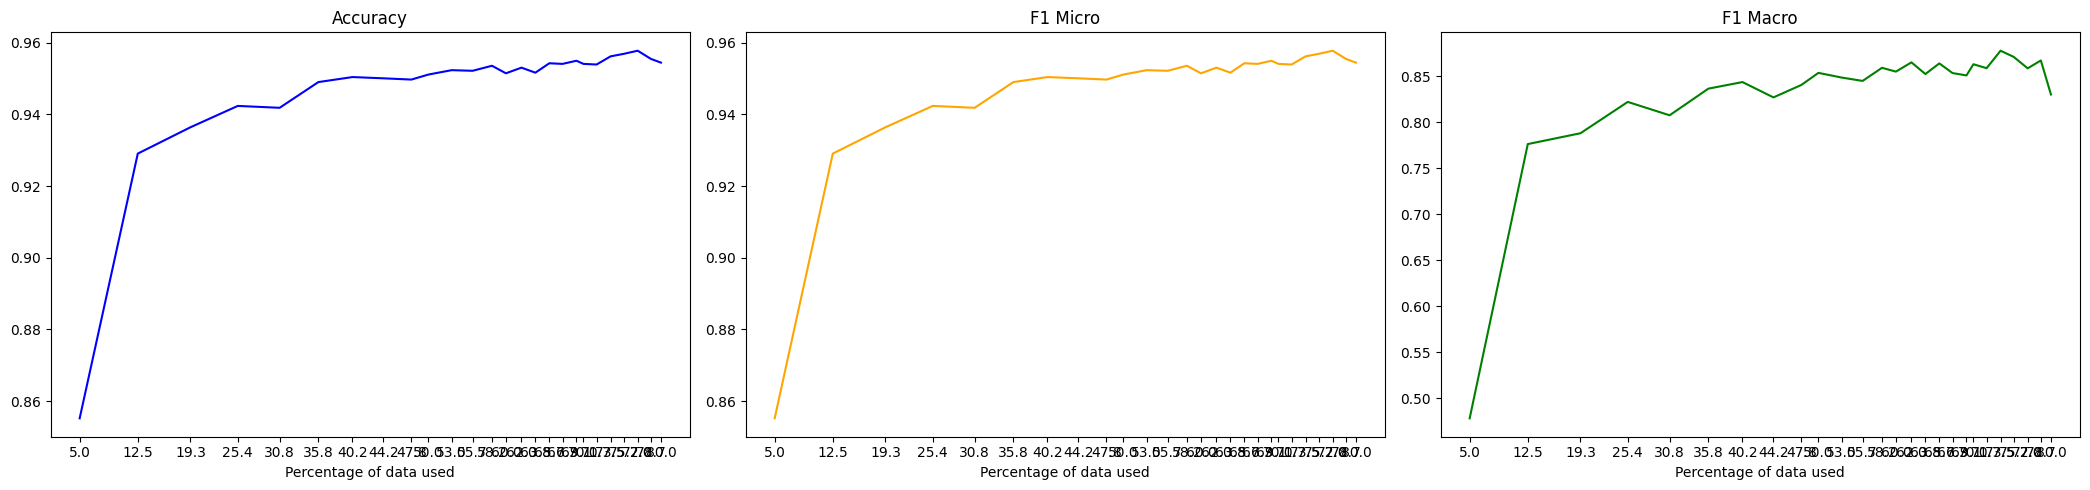

In [29]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 2.6457126140594482 | ACCURACY: 0.8035 | F1 MACRO: 0.8853 | F1 MICRO: 0.8904
EPOCH 2 | LOSS: 2.381070852279663 | ACCURACY: 0.8056 | F1 MACRO: 0.8802 | F1 MICRO: 0.8894
EPOCH 3 | LOSS: 2.305818796157837 | ACCURACY: 0.8043 | F1 MACRO: 0.8708 | F1 MICRO: 0.8869
EPOCH 4 | LOSS: 2.247757911682129 | ACCURACY: 0.8134 | F1 MACRO: 0.8822 | F1 MICRO: 0.893
EPOCH 5 | LOSS: 2.172611951828003 | ACCURACY: 0.8175 | F1 MACRO: 0.8858 | F1 MICRO: 0.8954
EPOCH 6 | LOSS: 2.1293091773986816 | ACCURACY: 0.8262 | F1 MACRO: 0.8899 | F1 MICRO: 0.8997
EPOCH 7 | LOSS: 2.1170997619628906 | ACCURACY: 0.8339 | F1 MACRO: 0.8977 | F1 MICRO: 0.9045
EPOCH 8 | LOSS: 2.075870990753174 | ACCURACY: 0.8446 | F1 MACRO: 0.9017 | F1 MICRO: 0.9094
EPOCH 9 | LOSS: 2.0561635494232178 | ACCURACY: 0.853 | F1 MACRO: 0.9069 | F1 MICRO: 0.9141
EPOCH 10 | LOSS: 2.059260606765747 | ACCURACY: 0.8583 | F1 MACRO: 0.9105 | F1 MICRO: 0.9169
aspect: ACCURACY 0.8583 | F1 MACRO 0.9105 | F1 MICRO 0.9169
              precision    

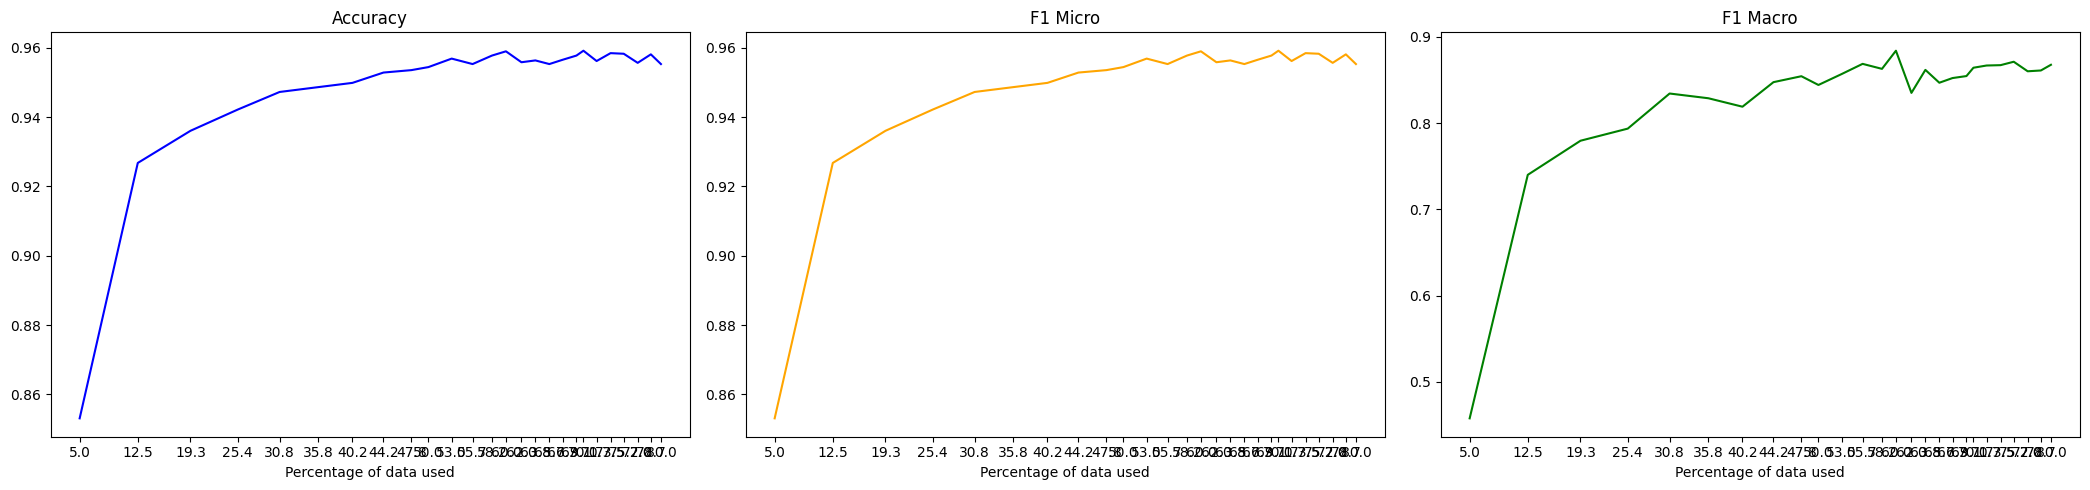

In [ ]:
active_learning(seeds[4], 4)